In [1]:
import fitz  # PyMuPDF
import pandas as pd
import numpy as np
import re
import os
from PIL import Image
import io
import matplotlib.pyplot as plt

In [2]:
pdf_file = '/Users/rodrigocarrillo/Documents/Natural Language Processing Projects/Examen Residentado Peru/CONAREME/Year2025/ESPECIALIADAD B.pdf'

In [3]:
def extract_questions(pdf_path):
    doc = fitz.open(pdf_path)
    questions_data = []  # List to store questions

    # Updated regular expression: handle questions with or without a '?'
    #question_pattern = re.compile(r"(\d+)\.\s(.*?)(?:\?)?\s*(?=A\.)", re.DOTALL)
    question_pattern = re.compile(r"(\d+)\.\s(.*?\??)\s*(?=A\.)", re.DOTALL)

    for page in doc:
        text = page.get_text("text")  # Extract full page text
        
        # Find all questions in the text using findall()
        questions = question_pattern.findall(text)
        
        # Append all the questions to the questions_data list
        for _, question in questions:
            questions_data.append(question.strip())  # Store the cleaned question text

    # Convert extracted questions to DataFrame
    questions_df = pd.DataFrame(questions_data, columns=["question"])
    return questions_df

In [4]:
def extract_answers(pdf_path):
    doc = fitz.open(pdf_path)
    answers_data = []  # List to store answers for each question

    # Regular expression for extracting answers
    answer_pattern = re.compile(r"^(A|B|C|D)\.\s(.+)", re.MULTILINE)

    for page in doc:
        text = page.get_text("text")  # Extract full page text
        lines = text.split("\n")  # Split into lines for structured parsing

        current_answers = []  # List to store answers for a given question
        for line in lines:
            answer_match = answer_pattern.match(line)
            if answer_match:
                opt, ans_text = answer_match.groups()
                current_answers.append(ans_text.strip())

            # After four options are found, store them as one row in answers_data
            if len(current_answers) == 4:
                answers_data.append(current_answers)
                current_answers = []  # Reset for next question

    # Convert extracted answers to DataFrame with four columns
    answers_df = pd.DataFrame(answers_data, columns = ["option_A", "option_B", "option_C", "option_D"])
    return answers_df

In [5]:
def get_largest_rectangle(rects):
    """Return the largest rectangle from a list of rectangles."""
    if not rects:
        return None
    
    # Calculate area for each rectangle and store with index
    areas = [(abs((rect.br.x - rect.tl.x) * (rect.br.y - rect.tl.y)), idx) 
             for idx, rect in enumerate(rects)]
    
    # Sort by area (first element of tuple)
    areas.sort(key=lambda x: x[0], reverse=True)
    
    # Return the rectangle with largest area
    return rects[areas[0][1]]

def extract_correct_answers(pdf_path):
    doc = fitz.open(pdf_path)
    correct_answers = []
    missing_questions = []  # Track questions that were skipped
    
    # Flexible regex for answer choices (handles missing spaces like "A." and "A. ")
    answer_pattern = re.compile(r"^(A|B|C|D)\.\s(.+)", re.MULTILINE)
    
    for page_num, page in enumerate(doc, start=1):
        text = page.get_text("text")  # Extract full page text
        lines = text.split("\n")  # Split into lines
        
        # Extract valid answer positions using regex
        answer_positions = {key: [] for key in ["A", "B", "C", "D"]}
        
        for line in lines:
            match = answer_pattern.match(line)
            if match:
                answer_letter, answer_text = match.groups()
                
                # Try different search variations to find the best match
                search_texts = [
                    match.group(0),  # Original matched text
                    match.group(0).strip(),  # Stripped version
                    answer_letter + '.' + answer_text,  # Without space after period
                    answer_letter.upper() + '. ' + answer_text,  # Different case
                ]
                
                rects = None
                used_search_text = ""
                
                # Find the first successful search
                for search_text in search_texts:
                    rects = page.search_for(search_text)
                    if rects:
                        used_search_text = search_text
                        break
                
                if rects:
                    # Select the largest rectangle
                    largest_rect = get_largest_rectangle(rects)
                    if largest_rect:
                        answer_positions[answer_letter].append(largest_rect)
        
        # Find the maximum number of questions on the page
        num_questions = max(len(answer_positions["A"]), len(answer_positions["B"]),
                          len(answer_positions["C"]), len(answer_positions["D"]))
        
        # Debugging: Show how many answers were found
        print(f"\nPage {page_num}: Found {num_questions} questions")
        
        for idx in range(num_questions):
            best_answer = None
            best_yellow_pixels = 0  # Track the highest number of yellow pixels
            has_all_options = True  # Flag to check if we have all 4 options
            
            for answer_letter in ["A", "B", "C", "D"]:
                rects = answer_positions[answer_letter]
                if idx >= len(rects):
                    has_all_options = False  # Missing one or more options
                    continue
                
                rect = rects[idx]
                
                # Debugging: Print detected answer positions
                print(f"Page {page_num}, Q{idx+1} - {answer_letter}: Detected box: "
                      f"x0={rect.x0:.1f}, y0={rect.y0:.1f}, x1={rect.x1:.1f}, y1={rect.y1:.1f}")
                
                # Expand bounding box only to the right
                expanded_rect = fitz.Rect(rect.x0, rect.y0, rect.x1 + 50, rect.y1)
                
                # Extract pixels from the expanded region
                pixmap = page.get_pixmap(clip=expanded_rect)
                img = np.frombuffer(pixmap.samples, dtype=np.uint8).reshape(pixmap.h, pixmap.w, pixmap.n)
                
                # Count yellow pixels (pixels with high red and green, low blue)
                yellow_mask = (
                    (img[:, :, 0] > 200) &  # High red
                    (img[:, :, 1] > 200) &  # High green
                    (img[:, :, 2] < 150)    # Low blue
                )
                yellow_pixels = np.sum(yellow_mask)
                
                # Count total non-white pixels
                nonwhite_mask = ~np.all(img > 250, axis=2)
                total_pixels = np.sum(nonwhite_mask)
                
                # Debug information
                print(f"Page {page_num}, Q{idx+1}, {answer_letter}: Yellow pixels: {yellow_pixels}")
                print(f"Page {page_num}, Q{idx+1}, {answer_letter}: Total non-white pixels: {total_pixels}")
                
                if total_pixels > 0:
                    yellow_percentage = (yellow_pixels / total_pixels) * 100
                    print(f"Page {page_num}, Q{idx+1}, {answer_letter}: Yellow percentage: {yellow_percentage:.1f}%")
                
                # Display the box in the notebook
                plt.figure(figsize=(8, 4))
                plt.imshow(img)
                plt.gca().add_patch(plt.Rectangle((0, 0), expanded_rect.width, expanded_rect.height,
                                                fill=False, color='red', linewidth=2))
                plt.title(f'Page {page_num}, Q{idx+1}, Answer {answer_letter}\nYellow pixels: {yellow_pixels}')
                plt.axis('off')
                plt.show()
                
                # Store the best answer based on the highest number of yellow pixels
                if yellow_pixels > best_yellow_pixels:
                    best_yellow_pixels = yellow_pixels
                    best_answer = answer_letter
            
            # If missing options, log missing questions
            if not has_all_options:
                missing_questions.append(f"Page {page_num}, Q{idx+1}")
            
            if best_answer:
                correct_answers.append(best_answer)
                print(f"\nPage {page_num}, Q{idx+1} - Selected Answer: {best_answer} (based on yellow pixel count)")
                print("====================================================================================================")
                print("\n")
                print("\n")
    
    # Debugging: Print missing questions
    if missing_questions:
        print("\n⚠️ The following questions were skipped due to missing options:")
        for q in missing_questions:
            print(q)
    
    return pd.DataFrame(correct_answers, columns=["correct_answer"])


Page 1: Found 8 questions
Page 1, Q1 - A: Detected box: x0=68.3, y0=116.4, x1=148.7, y1=127.4
Page 1, Q1, A: Yellow pixels: 0
Page 1, Q1, A: Total non-white pixels: 394
Page 1, Q1, A: Yellow percentage: 0.0%


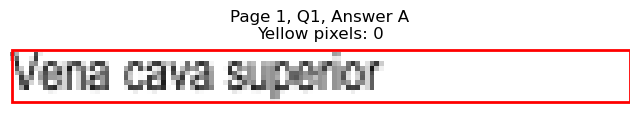

Page 1, Q1 - B: Detected box: x0=68.3, y0=129.0, x1=112.6, y1=140.0
Page 1, Q1, B: Yellow pixels: 0
Page 1, Q1, B: Total non-white pixels: 236
Page 1, Q1, B: Yellow percentage: 0.0%


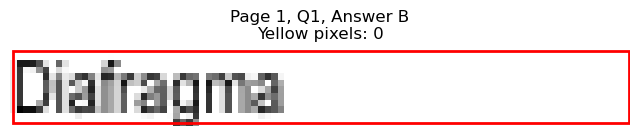

Page 1, Q1 - C: Detected box: x0=327.5, y0=116.4, x1=421.4, y1=127.4
Page 1, Q1, C: Yellow pixels: 1251
Page 1, Q1, C: Total non-white pixels: 1740
Page 1, Q1, C: Yellow percentage: 71.9%


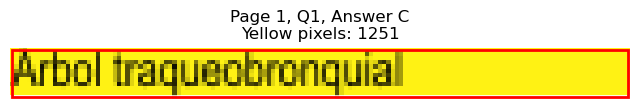

Page 1, Q1 - D: Detected box: x0=327.5, y0=129.0, x1=420.7, y1=140.0
Page 1, Q1, D: Yellow pixels: 0
Page 1, Q1, D: Total non-white pixels: 481
Page 1, Q1, D: Yellow percentage: 0.0%


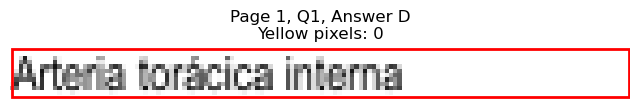


Page 1, Q1 - Selected Answer: C (based on yellow pixel count)




Page 1, Q2 - A: Detected box: x0=68.3, y0=192.1, x1=104.9, y1=203.1
Page 1, Q2, A: Yellow pixels: 0
Page 1, Q2, A: Total non-white pixels: 163
Page 1, Q2, A: Yellow percentage: 0.0%


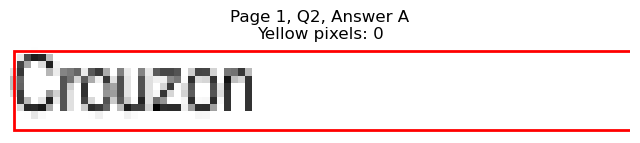

Page 1, Q2 - B: Detected box: x0=68.3, y0=204.7, x1=92.4, y1=215.7
Page 1, Q2, B: Yellow pixels: 0
Page 1, Q2, B: Total non-white pixels: 119
Page 1, Q2, B: Yellow percentage: 0.0%


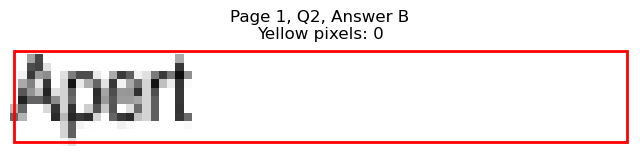

Page 1, Q2 - C: Detected box: x0=327.5, y0=192.1, x1=395.6, y1=203.1
Page 1, Q2, C: Yellow pixels: 119
Page 1, Q2, C: Total non-white pixels: 582
Page 1, Q2, C: Yellow percentage: 20.4%


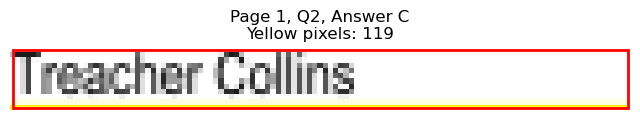

Page 1, Q2 - D: Detected box: x0=327.5, y0=204.7, x1=353.0, y1=215.7
Page 1, Q2, D: Yellow pixels: 836
Page 1, Q2, D: Total non-white pixels: 924
Page 1, Q2, D: Yellow percentage: 90.5%


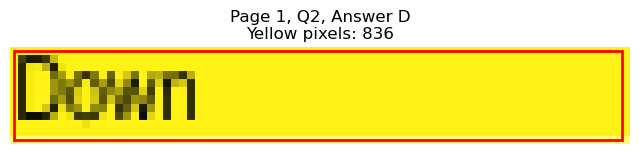


Page 1, Q2 - Selected Answer: D (based on yellow pixel count)




Page 1, Q3 - A: Detected box: x0=68.3, y0=267.8, x1=181.9, y1=278.8
Page 1, Q3, A: Yellow pixels: 1550
Page 1, Q3, A: Total non-white pixels: 1968
Page 1, Q3, A: Yellow percentage: 78.8%


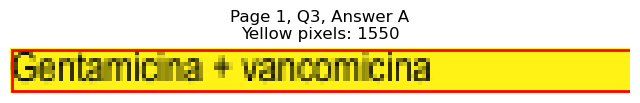

Page 1, Q3 - B: Detected box: x0=68.3, y0=280.5, x1=122.4, y1=291.6
Page 1, Q3, B: Yellow pixels: 0
Page 1, Q3, B: Total non-white pixels: 268
Page 1, Q3, B: Yellow percentage: 0.0%


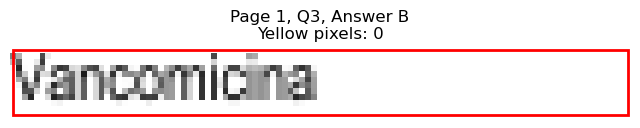

Page 1, Q3 - C: Detected box: x0=327.5, y0=267.8, x1=376.1, y1=278.8
Page 1, Q3, C: Yellow pixels: 0
Page 1, Q3, C: Total non-white pixels: 255
Page 1, Q3, C: Yellow percentage: 0.0%


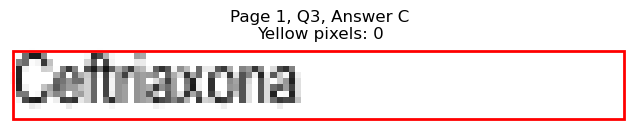

Page 1, Q3 - D: Detected box: x0=327.5, y0=280.5, x1=435.1, y1=291.6
Page 1, Q3, D: Yellow pixels: 0
Page 1, Q3, D: Total non-white pixels: 545
Page 1, Q3, D: Yellow percentage: 0.0%


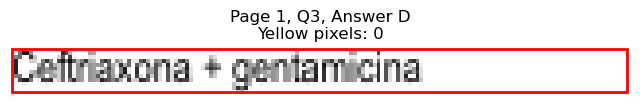


Page 1, Q3 - Selected Answer: A (based on yellow pixel count)




Page 1, Q4 - A: Detected box: x0=68.3, y0=343.6, x1=460.0, y1=354.7
Page 1, Q4, A: Yellow pixels: 442
Page 1, Q4, A: Total non-white pixels: 2387
Page 1, Q4, A: Yellow percentage: 18.5%


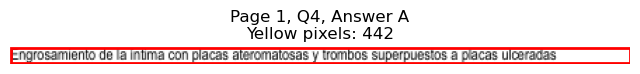

Page 1, Q4 - B: Detected box: x0=68.3, y0=356.2, x1=507.0, y1=367.3
Page 1, Q4, B: Yellow pixels: 3552
Page 1, Q4, B: Total non-white pixels: 5664
Page 1, Q4, B: Yellow percentage: 62.7%


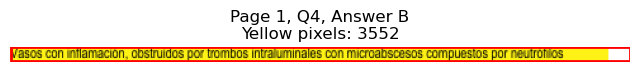

Page 1, Q4 - C: Detected box: x0=68.8, y0=368.8, x1=461.4, y1=379.9
Page 1, Q4, C: Yellow pixels: 0
Page 1, Q4, C: Total non-white pixels: 1986
Page 1, Q4, C: Yellow percentage: 0.0%


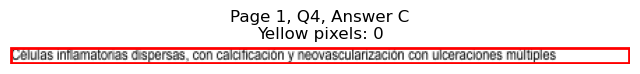

Page 1, Q4 - D: Detected box: x0=68.8, y0=381.4, x1=466.9, y1=392.5
Page 1, Q4, D: Yellow pixels: 0
Page 1, Q4, D: Total non-white pixels: 1995
Page 1, Q4, D: Yellow percentage: 0.0%


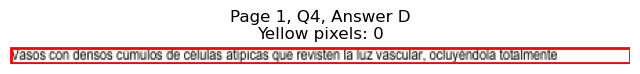


Page 1, Q4 - Selected Answer: B (based on yellow pixel count)




Page 1, Q5 - A: Detected box: x0=68.3, y0=432.0, x1=79.3, y1=443.0
Page 1, Q5, A: Yellow pixels: 0
Page 1, Q5, A: Total non-white pixels: 36
Page 1, Q5, A: Yellow percentage: 0.0%


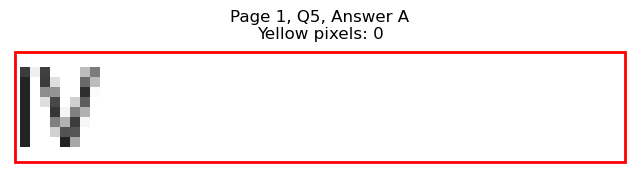

Page 1, Q5 - B: Detected box: x0=56.6, y0=444.6, x1=65.2, y1=455.6
Page 1, Q5, B: Yellow pixels: 0
Page 1, Q5, B: Total non-white pixels: 50
Page 1, Q5, B: Yellow percentage: 0.0%


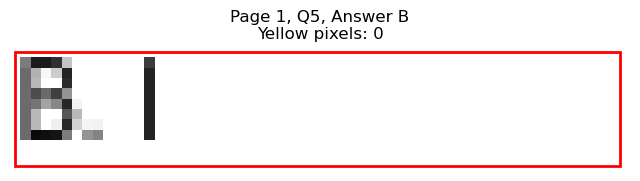

Page 1, Q5 - C: Detected box: x0=315.4, y0=432.0, x1=324.4, y1=443.0
Page 1, Q5, C: Yellow pixels: 671
Page 1, Q5, C: Total non-white pixels: 720
Page 1, Q5, C: Yellow percentage: 93.2%


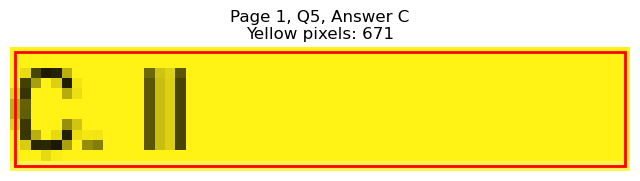

Page 1, Q5 - D: Detected box: x0=327.5, y0=444.6, x1=337.6, y1=455.6
Page 1, Q5, D: Yellow pixels: 0
Page 1, Q5, D: Total non-white pixels: 48
Page 1, Q5, D: Yellow percentage: 0.0%


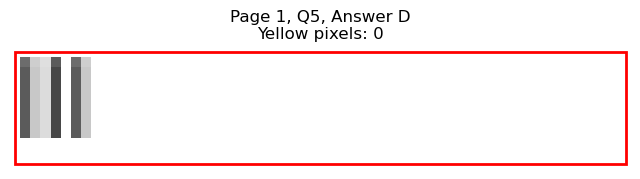


Page 1, Q5 - Selected Answer: C (based on yellow pixel count)




Page 1, Q6 - A: Detected box: x0=68.3, y0=482.5, x1=134.5, y1=493.5
Page 1, Q6, A: Yellow pixels: 0
Page 1, Q6, A: Total non-white pixels: 338
Page 1, Q6, A: Yellow percentage: 0.0%


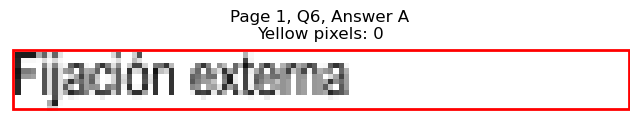

Page 1, Q6 - B: Detected box: x0=68.3, y0=495.1, x1=153.0, y1=506.1
Page 1, Q6, B: Yellow pixels: 0
Page 1, Q6, B: Total non-white pixels: 423
Page 1, Q6, B: Yellow percentage: 0.0%


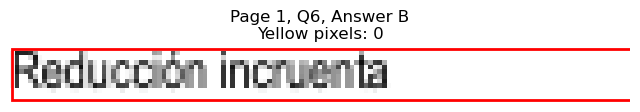

Page 1, Q6 - C: Detected box: x0=327.5, y0=482.5, x1=427.3, y1=493.5
Page 1, Q6, C: Yellow pixels: 1252
Page 1, Q6, C: Total non-white pixels: 1812
Page 1, Q6, C: Yellow percentage: 69.1%


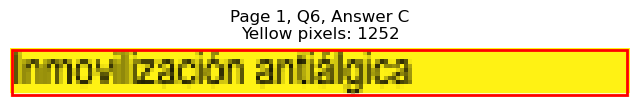

Page 1, Q6 - D: Detected box: x0=327.5, y0=495.1, x1=414.4, y1=506.1
Page 1, Q6, D: Yellow pixels: 0
Page 1, Q6, D: Total non-white pixels: 420
Page 1, Q6, D: Yellow percentage: 0.0%


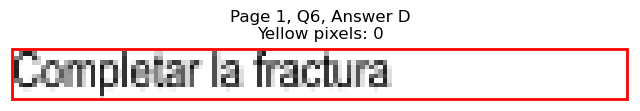


Page 1, Q6 - Selected Answer: C (based on yellow pixel count)




Page 1, Q7 - A: Detected box: x0=68.3, y0=583.4, x1=191.2, y1=594.4
Page 1, Q7, A: Yellow pixels: 0
Page 1, Q7, A: Total non-white pixels: 607
Page 1, Q7, A: Yellow percentage: 0.0%


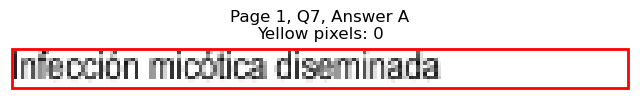

Page 1, Q7 - B: Detected box: x0=68.3, y0=596.0, x1=122.4, y1=607.0
Page 1, Q7, B: Yellow pixels: 0
Page 1, Q7, B: Total non-white pixels: 302
Page 1, Q7, B: Yellow percentage: 0.0%


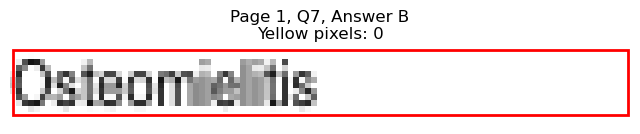

Page 1, Q7 - C: Detected box: x0=327.5, y0=583.4, x1=440.3, y1=594.4
Page 1, Q7, C: Yellow pixels: 164
Page 1, Q7, C: Total non-white pixels: 739
Page 1, Q7, C: Yellow percentage: 22.2%


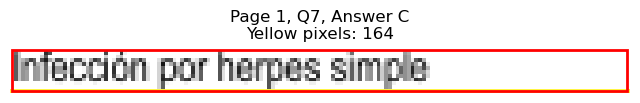

Page 1, Q7 - D: Detected box: x0=327.5, y0=596.0, x1=401.8, y1=607.0
Page 1, Q7, D: Yellow pixels: 1236
Page 1, Q7, D: Total non-white pixels: 1502
Page 1, Q7, D: Yellow percentage: 82.3%


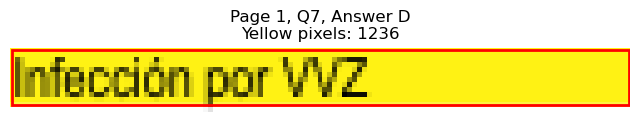


Page 1, Q7 - Selected Answer: D (based on yellow pixel count)




Page 1, Q8 - A: Detected box: x0=68.3, y0=671.7, x1=207.2, y1=682.8
Page 1, Q8, A: Yellow pixels: 0
Page 1, Q8, A: Total non-white pixels: 703
Page 1, Q8, A: Yellow percentage: 0.0%


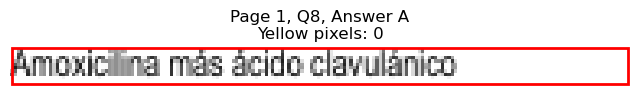

Page 1, Q8 - B: Detected box: x0=68.3, y0=684.3, x1=116.9, y1=695.4
Page 1, Q8, B: Yellow pixels: 0
Page 1, Q8, B: Total non-white pixels: 245
Page 1, Q8, B: Yellow percentage: 0.0%


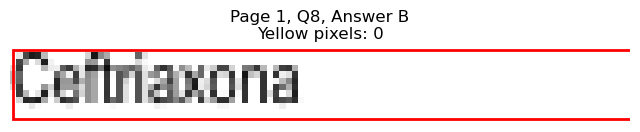

Page 1, Q8 - C: Detected box: x0=327.5, y0=671.7, x1=375.6, y1=682.8
Page 1, Q8, C: Yellow pixels: 995
Page 1, Q8, C: Total non-white pixels: 1188
Page 1, Q8, C: Yellow percentage: 83.8%


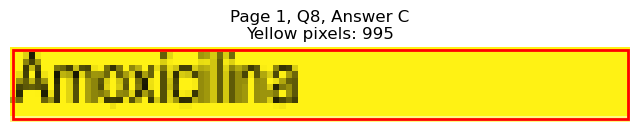

Page 1, Q8 - D: Detected box: x0=327.5, y0=684.3, x1=379.1, y1=695.4
Page 1, Q8, D: Yellow pixels: 0
Page 1, Q8, D: Total non-white pixels: 266
Page 1, Q8, D: Yellow percentage: 0.0%


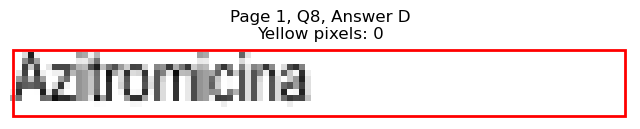


Page 1, Q8 - Selected Answer: C (based on yellow pixel count)





Page 2: Found 9 questions
Page 2, Q1 - A: Detected box: x0=68.3, y0=129.0, x1=145.6, y1=140.0
Page 2, Q1, A: Yellow pixels: 0
Page 2, Q1, A: Total non-white pixels: 414
Page 2, Q1, A: Yellow percentage: 0.0%


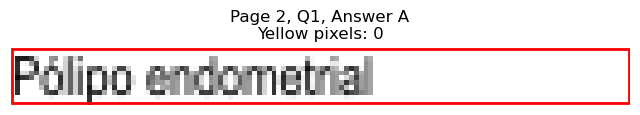

Page 2, Q1 - B: Detected box: x0=68.3, y0=141.7, x1=127.9, y1=152.7
Page 2, Q1, B: Yellow pixels: 0
Page 2, Q1, B: Total non-white pixels: 310
Page 2, Q1, B: Yellow percentage: 0.0%


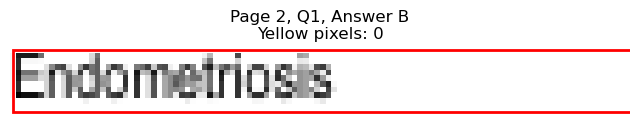

Page 2, Q1 - C: Detected box: x0=327.5, y0=129.0, x1=381.6, y1=140.0
Page 2, Q1, C: Yellow pixels: 1069
Page 2, Q1, C: Total non-white pixels: 1260
Page 2, Q1, C: Yellow percentage: 84.8%


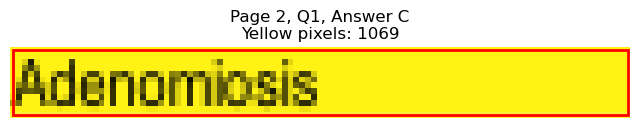

Page 2, Q1 - D: Detected box: x0=327.5, y0=141.7, x1=405.7, y1=152.7
Page 2, Q1, D: Yellow pixels: 0
Page 2, Q1, D: Total non-white pixels: 417
Page 2, Q1, D: Yellow percentage: 0.0%


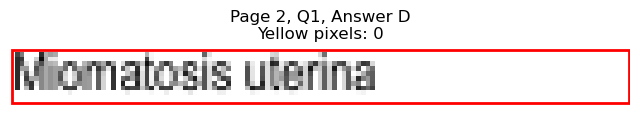


Page 2, Q1 - Selected Answer: C (based on yellow pixel count)




Page 2, Q2 - A: Detected box: x0=68.3, y0=179.5, x1=106.9, y1=190.5
Page 2, Q2, A: Yellow pixels: 89
Page 2, Q2, A: Total non-white pixels: 278
Page 2, Q2, A: Yellow percentage: 32.0%


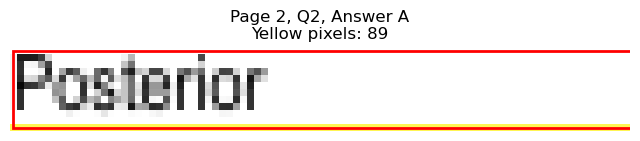

Page 2, Q2 - B: Detected box: x0=68.3, y0=192.1, x1=99.8, y1=203.1
Page 2, Q2, B: Yellow pixels: 786
Page 2, Q2, B: Total non-white pixels: 902
Page 2, Q2, B: Yellow percentage: 87.1%


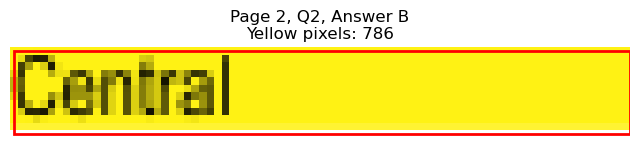

Page 2, Q2 - C: Detected box: x0=327.5, y0=179.5, x1=361.1, y1=190.5
Page 2, Q2, C: Yellow pixels: 0
Page 2, Q2, C: Total non-white pixels: 156
Page 2, Q2, C: Yellow percentage: 0.0%


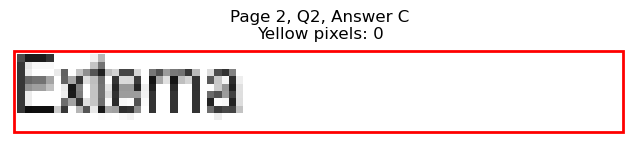

Page 2, Q2 - D: Detected box: x0=327.5, y0=192.1, x1=361.6, y1=203.1
Page 2, Q2, D: Yellow pixels: 0
Page 2, Q2, D: Total non-white pixels: 165
Page 2, Q2, D: Yellow percentage: 0.0%


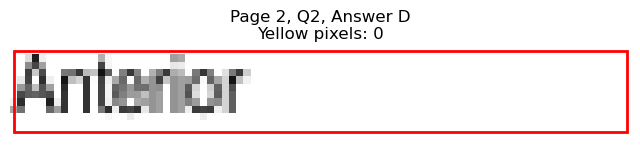


Page 2, Q2 - Selected Answer: B (based on yellow pixel count)




Page 2, Q3 - A: Detected box: x0=68.3, y0=255.2, x1=118.0, y1=266.2
Page 2, Q3, A: Yellow pixels: 100
Page 2, Q3, A: Total non-white pixels: 343
Page 2, Q3, A: Yellow percentage: 29.2%


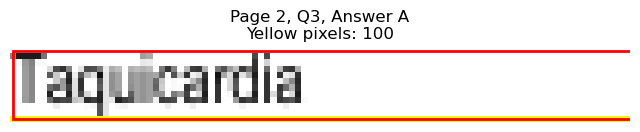

Page 2, Q3 - B: Detected box: x0=68.3, y0=267.8, x1=122.4, y1=278.8
Page 2, Q3, B: Yellow pixels: 1067
Page 2, Q3, B: Total non-white pixels: 1260
Page 2, Q3, B: Yellow percentage: 84.7%


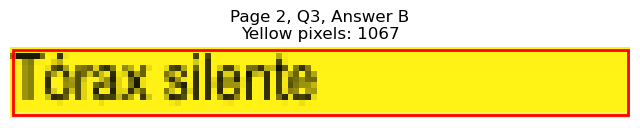

Page 2, Q3 - C: Detected box: x0=327.5, y0=255.2, x1=383.2, y1=266.2
Page 2, Q3, C: Yellow pixels: 0
Page 2, Q3, C: Total non-white pixels: 298
Page 2, Q3, C: Yellow percentage: 0.0%


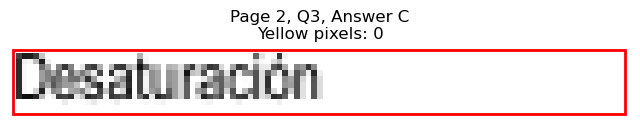

Page 2, Q3 - D: Detected box: x0=327.5, y0=267.8, x1=364.6, y1=278.8
Page 2, Q3, D: Yellow pixels: 0
Page 2, Q3, D: Total non-white pixels: 196
Page 2, Q3, D: Yellow percentage: 0.0%


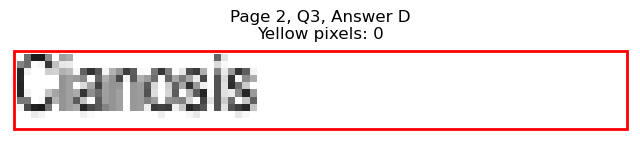


Page 2, Q3 - Selected Answer: B (based on yellow pixel count)




Page 2, Q4 - A: Detected box: x0=68.3, y0=330.9, x1=150.0, y1=342.0
Page 2, Q4, A: Yellow pixels: 0
Page 2, Q4, A: Total non-white pixels: 516
Page 2, Q4, A: Yellow percentage: 0.0%


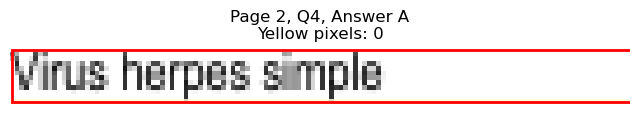

Page 2, Q4 - B: Detected box: x0=68.3, y0=343.6, x1=153.0, y1=354.7
Page 2, Q4, B: Yellow pixels: 1275
Page 2, Q4, B: Total non-white pixels: 1620
Page 2, Q4, B: Yellow percentage: 78.7%


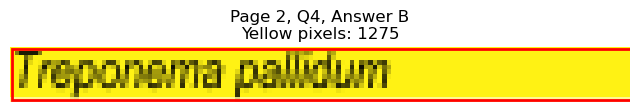

Page 2, Q4 - C: Detected box: x0=327.5, y0=330.9, x1=412.2, y1=342.0
Page 2, Q4, C: Yellow pixels: 0
Page 2, Q4, C: Total non-white pixels: 436
Page 2, Q4, C: Yellow percentage: 0.0%


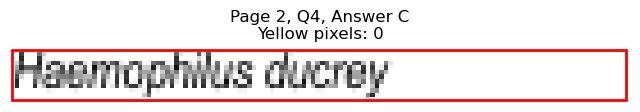

Page 2, Q4 - D: Detected box: x0=327.5, y0=343.6, x1=439.3, y1=354.7
Page 2, Q4, D: Yellow pixels: 0
Page 2, Q4, D: Total non-white pixels: 545
Page 2, Q4, D: Yellow percentage: 0.0%


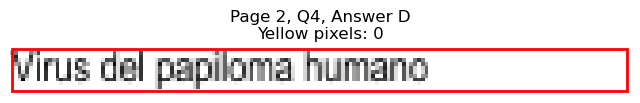


Page 2, Q4 - Selected Answer: B (based on yellow pixel count)




Page 2, Q5 - A: Detected box: x0=68.3, y0=406.6, x1=121.4, y1=417.7
Page 2, Q5, A: Yellow pixels: 104
Page 2, Q5, A: Total non-white pixels: 363
Page 2, Q5, A: Yellow percentage: 28.7%


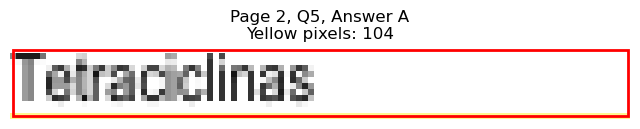

Page 2, Q5 - B: Detected box: x0=68.3, y0=419.4, x1=114.4, y1=430.4
Page 2, Q5, B: Yellow pixels: 896
Page 2, Q5, B: Total non-white pixels: 1164
Page 2, Q5, B: Yellow percentage: 77.0%


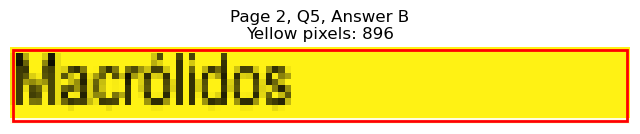

Page 2, Q5 - C: Detected box: x0=327.5, y0=406.6, x1=375.6, y1=417.7
Page 2, Q5, C: Yellow pixels: 0
Page 2, Q5, C: Total non-white pixels: 226
Page 2, Q5, C: Yellow percentage: 0.0%


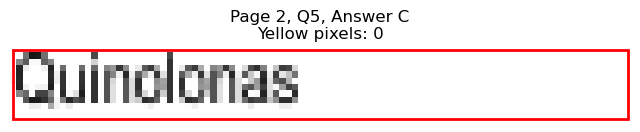

Page 2, Q5 - D: Detected box: x0=327.5, y0=419.4, x1=384.7, y1=430.4
Page 2, Q5, D: Yellow pixels: 0
Page 2, Q5, D: Total non-white pixels: 297
Page 2, Q5, D: Yellow percentage: 0.0%


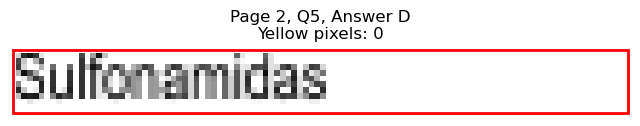


Page 2, Q5 - Selected Answer: B (based on yellow pixel count)




Page 2, Q6 - A: Detected box: x0=68.3, y0=469.9, x1=368.6, y1=480.9
Page 2, Q6, A: Yellow pixels: 0
Page 2, Q6, A: Total non-white pixels: 1528
Page 2, Q6, A: Yellow percentage: 0.0%


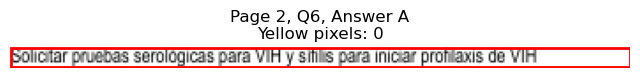

Page 2, Q6 - B: Detected box: x0=68.3, y0=482.5, x1=493.7, y1=493.5
Page 2, Q6, B: Yellow pixels: 0
Page 2, Q6, B: Total non-white pixels: 2203
Page 2, Q6, B: Yellow percentage: 0.0%


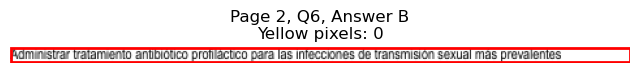

Page 2, Q6 - C: Detected box: x0=68.8, y0=495.1, x1=498.1, y1=506.1
Page 2, Q6, C: Yellow pixels: 472
Page 2, Q6, C: Total non-white pixels: 3131
Page 2, Q6, C: Yellow percentage: 15.1%


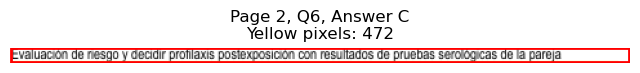

Page 2, Q6 - D: Detected box: x0=68.8, y0=507.7, x1=424.2, y1=518.7
Page 2, Q6, D: Yellow pixels: 3497
Page 2, Q6, D: Total non-white pixels: 4884
Page 2, Q6, D: Yellow percentage: 71.6%


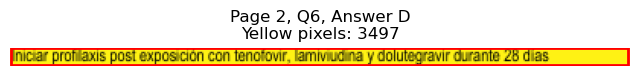


Page 2, Q6 - Selected Answer: D (based on yellow pixel count)




Page 2, Q7 - A: Detected box: x0=68.3, y0=570.8, x1=105.8, y1=581.8
Page 2, Q7, A: Yellow pixels: 0
Page 2, Q7, A: Total non-white pixels: 193
Page 2, Q7, A: Yellow percentage: 0.0%


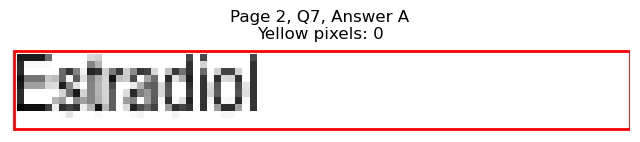

Page 2, Q7 - B: Detected box: x0=68.3, y0=583.4, x1=101.4, y1=594.4
Page 2, Q7, B: Yellow pixels: 0
Page 2, Q7, B: Total non-white pixels: 173
Page 2, Q7, B: Yellow percentage: 0.0%


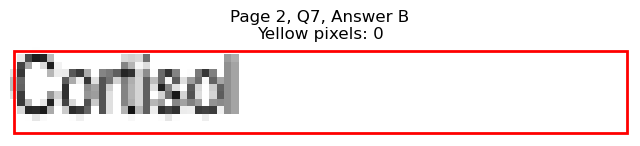

Page 2, Q7 - C: Detected box: x0=327.5, y0=570.8, x1=442.3, y1=581.8
Page 2, Q7, C: Yellow pixels: 1568
Page 2, Q7, C: Total non-white pixels: 1992
Page 2, Q7, C: Yellow percentage: 78.7%


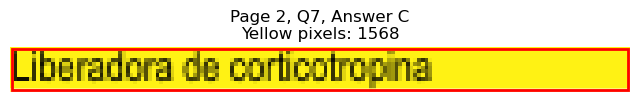

Page 2, Q7 - D: Detected box: x0=327.5, y0=583.4, x1=362.0, y1=594.4
Page 2, Q7, D: Yellow pixels: 0
Page 2, Q7, D: Total non-white pixels: 168
Page 2, Q7, D: Yellow percentage: 0.0%


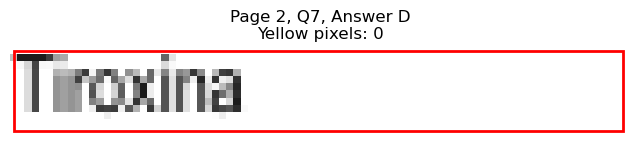


Page 2, Q7 - Selected Answer: C (based on yellow pixel count)




Page 2, Q8 - A: Detected box: x0=68.3, y0=621.3, x1=154.1, y1=632.4
Page 2, Q8, A: Yellow pixels: 137
Page 2, Q8, A: Total non-white pixels: 588
Page 2, Q8, A: Yellow percentage: 23.3%


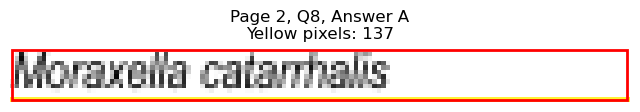

Page 2, Q8 - B: Detected box: x0=68.3, y0=633.9, x1=167.0, y1=645.0
Page 2, Q8, B: Yellow pixels: 1407
Page 2, Q8, B: Total non-white pixels: 1800
Page 2, Q8, B: Yellow percentage: 78.2%


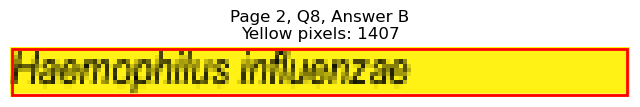

Page 2, Q8 - C: Detected box: x0=327.5, y0=621.3, x1=430.3, y1=632.4
Page 2, Q8, C: Yellow pixels: 0
Page 2, Q8, C: Total non-white pixels: 521
Page 2, Q8, C: Yellow percentage: 0.0%


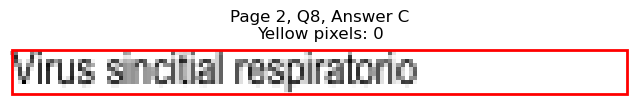

Page 2, Q8 - D: Detected box: x0=327.5, y0=633.9, x1=439.3, y1=645.0
Page 2, Q8, D: Yellow pixels: 0
Page 2, Q8, D: Total non-white pixels: 572
Page 2, Q8, D: Yellow percentage: 0.0%


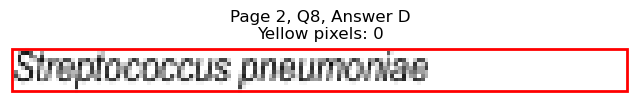


Page 2, Q8 - Selected Answer: B (based on yellow pixel count)




Page 2, Q9 - A: Detected box: x0=68.3, y0=709.6, x1=134.5, y1=720.7
Page 2, Q9, A: Yellow pixels: 0
Page 2, Q9, A: Total non-white pixels: 349
Page 2, Q9, A: Yellow percentage: 0.0%


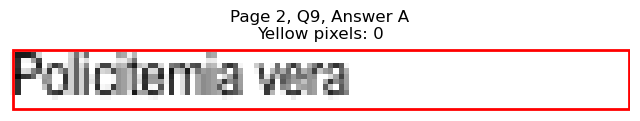

Page 2, Q9 - B: Detected box: x0=68.3, y0=722.2, x1=151.1, y1=733.3
Page 2, Q9, B: Yellow pixels: 0
Page 2, Q9, B: Total non-white pixels: 413
Page 2, Q9, B: Yellow percentage: 0.0%


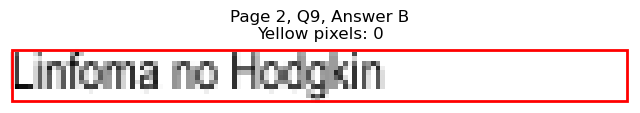

Page 2, Q9 - C: Detected box: x0=327.5, y0=709.6, x1=432.8, y1=720.7
Page 2, Q9, C: Yellow pixels: 1489
Page 2, Q9, C: Total non-white pixels: 1872
Page 2, Q9, C: Yellow percentage: 79.5%


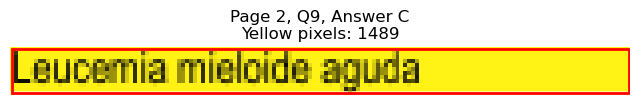

Page 2, Q9 - D: Detected box: x0=327.5, y0=722.2, x1=425.8, y1=733.3
Page 2, Q9, D: Yellow pixels: 0
Page 2, Q9, D: Total non-white pixels: 525
Page 2, Q9, D: Yellow percentage: 0.0%


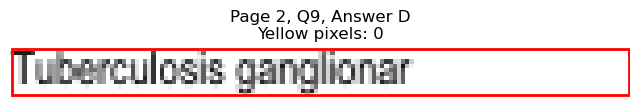


Page 2, Q9 - Selected Answer: C (based on yellow pixel count)





Page 3: Found 9 questions
Page 3, Q1 - A: Detected box: x0=68.3, y0=116.4, x1=175.2, y1=127.4
Page 3, Q1, A: Yellow pixels: 158
Page 3, Q1, A: Total non-white pixels: 711
Page 3, Q1, A: Yellow percentage: 22.2%


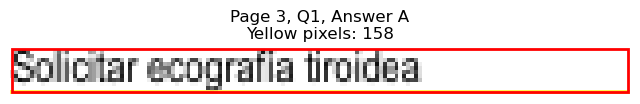

Page 3, Q1 - B: Detected box: x0=68.3, y0=129.1, x1=143.2, y1=140.1
Page 3, Q1, B: Yellow pixels: 1112
Page 3, Q1, B: Total non-white pixels: 1386
Page 3, Q1, B: Yellow percentage: 80.2%


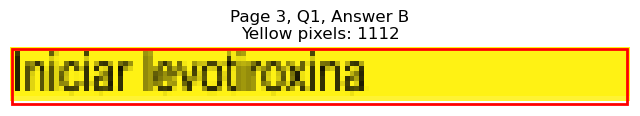

Page 3, Q1 - C: Detected box: x0=327.5, y0=116.4, x1=449.9, y1=127.4
Page 3, Q1, C: Yellow pixels: 0
Page 3, Q1, C: Total non-white pixels: 645
Page 3, Q1, C: Yellow percentage: 0.0%


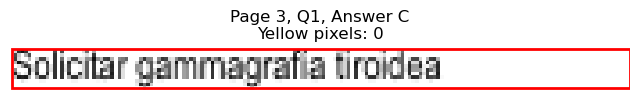

Page 3, Q1 - D: Detected box: x0=327.5, y0=129.1, x1=462.4, y1=140.1
Page 3, Q1, D: Yellow pixels: 0
Page 3, Q1, D: Total non-white pixels: 688
Page 3, Q1, D: Yellow percentage: 0.0%


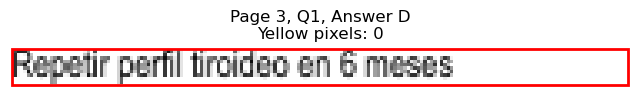


Page 3, Q1 - Selected Answer: B (based on yellow pixel count)




Page 3, Q2 - A: Detected box: x0=68.3, y0=204.8, x1=121.4, y1=215.8
Page 3, Q2, A: Yellow pixels: 1046
Page 3, Q2, A: Total non-white pixels: 1248
Page 3, Q2, A: Yellow percentage: 83.8%


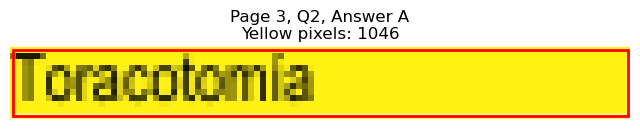

Page 3, Q2 - B: Detected box: x0=68.3, y0=217.4, x1=121.4, y1=228.4
Page 3, Q2, B: Yellow pixels: 0
Page 3, Q2, B: Total non-white pixels: 278
Page 3, Q2, B: Yellow percentage: 0.0%


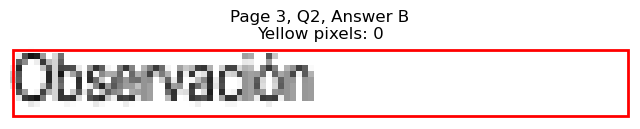

Page 3, Q2 - C: Detected box: x0=327.5, y0=204.8, x1=385.2, y1=215.8
Page 3, Q2, C: Yellow pixels: 0
Page 3, Q2, C: Total non-white pixels: 277
Page 3, Q2, C: Yellow percentage: 0.0%


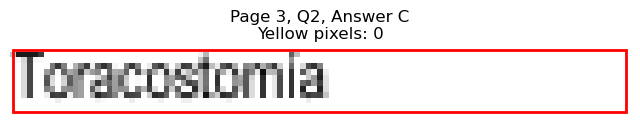

Page 3, Q2 - D: Detected box: x0=327.5, y0=217.4, x1=376.1, y1=228.4
Page 3, Q2, D: Yellow pixels: 0
Page 3, Q2, D: Total non-white pixels: 245
Page 3, Q2, D: Yellow percentage: 0.0%


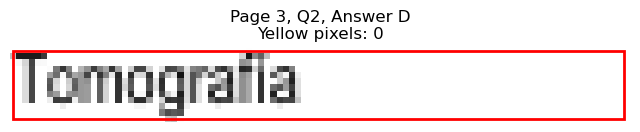


Page 3, Q2 - Selected Answer: A (based on yellow pixel count)




Page 3, Q3 - A: Detected box: x0=68.3, y0=280.5, x1=153.0, y1=291.6
Page 3, Q3, A: Yellow pixels: 0
Page 3, Q3, A: Total non-white pixels: 418
Page 3, Q3, A: Yellow percentage: 0.0%


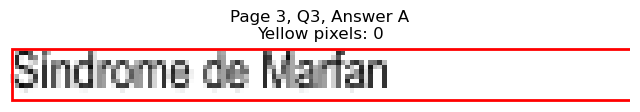

Page 3, Q3 - B: Detected box: x0=68.3, y0=293.1, x1=151.6, y1=304.2
Page 3, Q3, B: Yellow pixels: 0
Page 3, Q3, B: Total non-white pixels: 402
Page 3, Q3, B: Yellow percentage: 0.0%


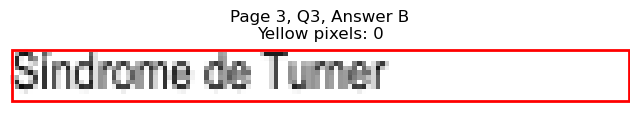

Page 3, Q3 - C: Detected box: x0=327.5, y0=280.5, x1=429.8, y1=291.6
Page 3, Q3, C: Yellow pixels: 1268
Page 3, Q3, C: Total non-white pixels: 1836
Page 3, Q3, C: Yellow percentage: 69.1%


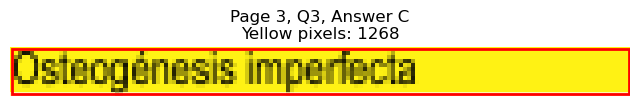

Page 3, Q3 - D: Detected box: x0=327.5, y0=293.1, x1=380.6, y1=304.2
Page 3, Q3, D: Yellow pixels: 0
Page 3, Q3, D: Total non-white pixels: 290
Page 3, Q3, D: Yellow percentage: 0.0%


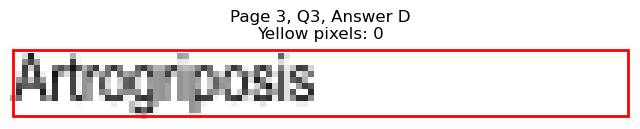


Page 3, Q3 - Selected Answer: C (based on yellow pixel count)




Page 3, Q4 - A: Detected box: x0=56.6, y0=356.2, x1=65.2, y1=367.3
Page 3, Q4, A: Yellow pixels: 0
Page 3, Q4, A: Total non-white pixels: 67
Page 3, Q4, A: Yellow percentage: 0.0%


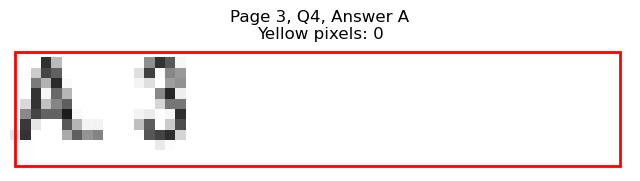

Page 3, Q4 - B: Detected box: x0=56.6, y0=368.8, x1=65.2, y1=379.9
Page 3, Q4, B: Yellow pixels: 0
Page 3, Q4, B: Total non-white pixels: 66
Page 3, Q4, B: Yellow percentage: 0.0%


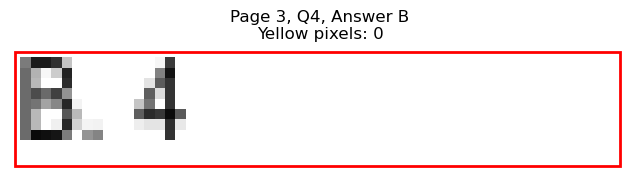

Page 3, Q4 - C: Detected box: x0=315.4, y0=356.2, x1=324.4, y1=367.3
Page 3, Q4, C: Yellow pixels: 60
Page 3, Q4, C: Total non-white pixels: 135
Page 3, Q4, C: Yellow percentage: 44.4%


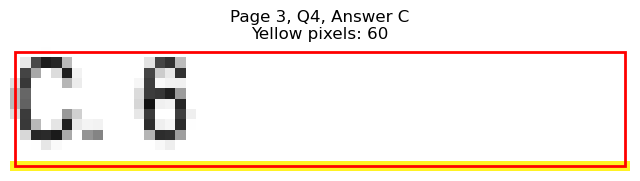

Page 3, Q4 - D: Detected box: x0=315.4, y0=368.8, x1=324.4, y1=379.9
Page 3, Q4, D: Yellow pixels: 675
Page 3, Q4, D: Total non-white pixels: 720
Page 3, Q4, D: Yellow percentage: 93.8%


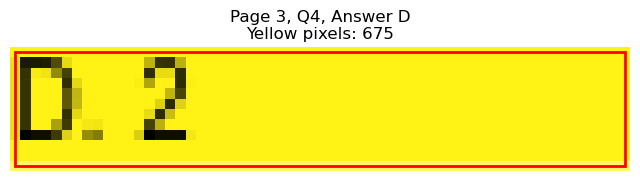


Page 3, Q4 - Selected Answer: D (based on yellow pixel count)




Page 3, Q5 - A: Detected box: x0=68.3, y0=432.0, x1=145.6, y1=443.0
Page 3, Q5, A: Yellow pixels: 1228
Page 3, Q5, A: Total non-white pixels: 1536
Page 3, Q5, A: Yellow percentage: 79.9%


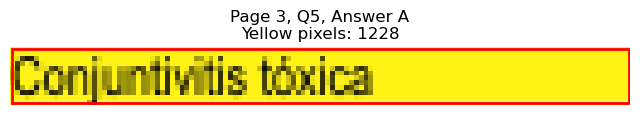

Page 3, Q5 - B: Detected box: x0=68.3, y0=444.6, x1=158.5, y1=455.6
Page 3, Q5, B: Yellow pixels: 0
Page 3, Q5, B: Total non-white pixels: 473
Page 3, Q5, B: Yellow percentage: 0.0%


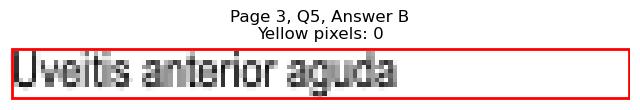

Page 3, Q5 - C: Detected box: x0=327.5, y0=432.0, x1=405.7, y1=443.0
Page 3, Q5, C: Yellow pixels: 0
Page 3, Q5, C: Total non-white pixels: 414
Page 3, Q5, C: Yellow percentage: 0.0%


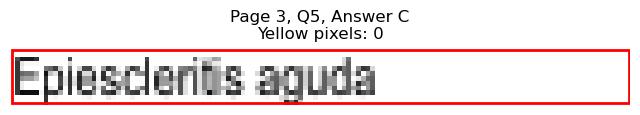

Page 3, Q5 - D: Detected box: x0=327.5, y0=444.6, x1=398.9, y1=455.6
Page 3, Q5, D: Yellow pixels: 0
Page 3, Q5, D: Total non-white pixels: 356
Page 3, Q5, D: Yellow percentage: 0.0%


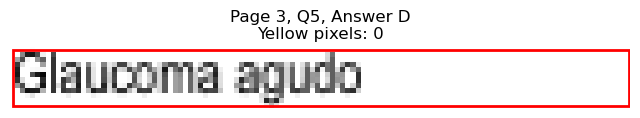


Page 3, Q5 - Selected Answer: A (based on yellow pixel count)




Page 3, Q6 - A: Detected box: x0=68.3, y0=507.7, x1=140.5, y1=518.7
Page 3, Q6, A: Yellow pixels: 123
Page 3, Q6, A: Total non-white pixels: 468
Page 3, Q6, A: Yellow percentage: 26.3%


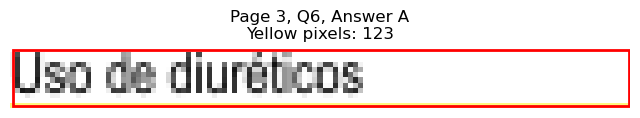

Page 3, Q6 - B: Detected box: x0=68.3, y0=520.3, x1=175.7, y1=531.3
Page 3, Q6, B: Yellow pixels: 1335
Page 3, Q6, B: Total non-white pixels: 1896
Page 3, Q6, B: Yellow percentage: 70.4%


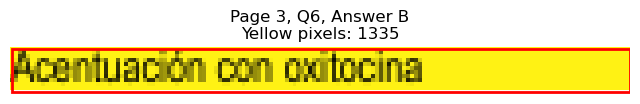

Page 3, Q6 - C: Detected box: x0=327.5, y0=507.7, x1=406.2, y1=518.7
Page 3, Q6, C: Yellow pixels: 0
Page 3, Q6, C: Total non-white pixels: 421
Page 3, Q6, C: Yellow percentage: 0.0%


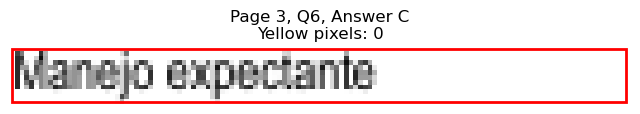

Page 3, Q6 - D: Detected box: x0=327.5, y0=520.3, x1=426.2, y1=531.3
Page 3, Q6, D: Yellow pixels: 0
Page 3, Q6, D: Total non-white pixels: 509
Page 3, Q6, D: Yellow percentage: 0.0%


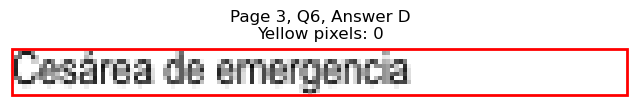


Page 3, Q6 - Selected Answer: B (based on yellow pixel count)




Page 3, Q7 - A: Detected box: x0=56.6, y0=583.4, x1=65.2, y1=594.4
Page 3, Q7, A: Yellow pixels: 0
Page 3, Q7, A: Total non-white pixels: 60
Page 3, Q7, A: Yellow percentage: 0.0%


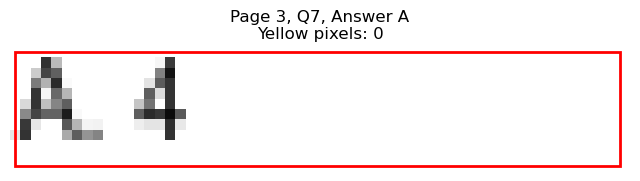

Page 3, Q7 - B: Detected box: x0=56.6, y0=596.0, x1=65.2, y1=607.0
Page 3, Q7, B: Yellow pixels: 0
Page 3, Q7, B: Total non-white pixels: 74
Page 3, Q7, B: Yellow percentage: 0.0%


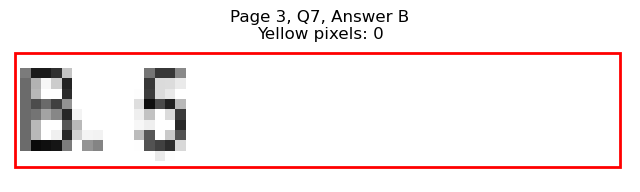

Page 3, Q7 - C: Detected box: x0=315.4, y0=583.4, x1=324.4, y1=594.4
Page 3, Q7, C: Yellow pixels: 60
Page 3, Q7, C: Total non-white pixels: 128
Page 3, Q7, C: Yellow percentage: 46.9%


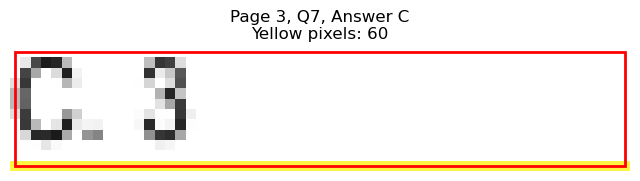

Page 3, Q7 - D: Detected box: x0=315.4, y0=368.8, x1=324.4, y1=379.9
Page 3, Q7, D: Yellow pixels: 675
Page 3, Q7, D: Total non-white pixels: 720
Page 3, Q7, D: Yellow percentage: 93.8%


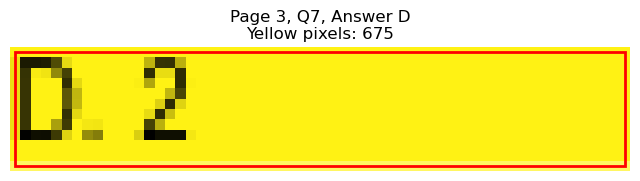


Page 3, Q7 - Selected Answer: D (based on yellow pixel count)




Page 3, Q8 - A: Detected box: x0=68.3, y0=646.5, x1=109.9, y1=657.6
Page 3, Q8, A: Yellow pixels: 871
Page 3, Q8, A: Total non-white pixels: 1104
Page 3, Q8, A: Yellow percentage: 78.9%


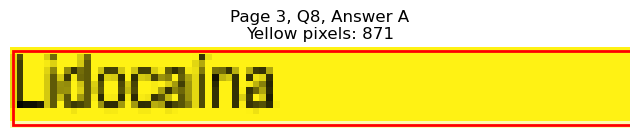

Page 3, Q8 - B: Detected box: x0=68.3, y0=659.1, x1=121.0, y1=670.2
Page 3, Q8, B: Yellow pixels: 0
Page 3, Q8, B: Total non-white pixels: 270
Page 3, Q8, B: Yellow percentage: 0.0%


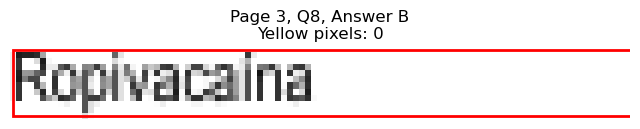

Page 3, Q8 - C: Detected box: x0=327.5, y0=646.5, x1=363.6, y1=657.6
Page 3, Q8, C: Yellow pixels: 0
Page 3, Q8, C: Total non-white pixels: 178
Page 3, Q8, C: Yellow percentage: 0.0%


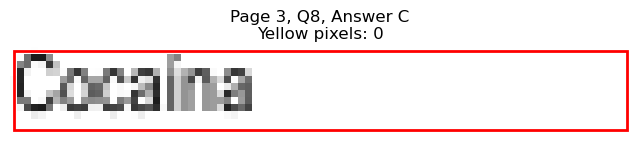

Page 3, Q8 - D: Detected box: x0=327.5, y0=659.1, x1=379.7, y1=670.2
Page 3, Q8, D: Yellow pixels: 0
Page 3, Q8, D: Total non-white pixels: 257
Page 3, Q8, D: Yellow percentage: 0.0%


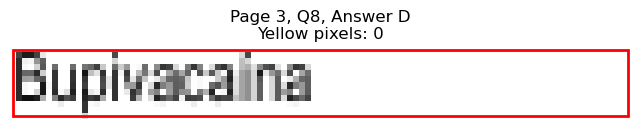


Page 3, Q8 - Selected Answer: A (based on yellow pixel count)




Page 3, Q9 - A: Detected box: x0=68.3, y0=709.6, x1=304.1, y1=720.7
Page 3, Q9, A: Yellow pixels: 2523
Page 3, Q9, A: Total non-white pixels: 3444
Page 3, Q9, A: Yellow percentage: 73.3%


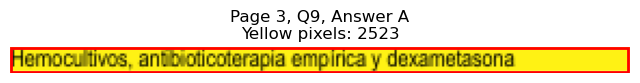

Page 3, Q9 - B: Detected box: x0=68.3, y0=722.2, x1=148.0, y1=733.3
Page 3, Q9, B: Yellow pixels: 0
Page 3, Q9, B: Total non-white pixels: 413
Page 3, Q9, B: Yellow percentage: 0.0%


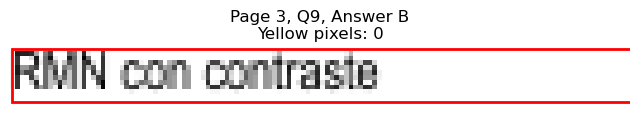

Page 3, Q9 - C: Detected box: x0=68.8, y0=734.8, x1=172.1, y1=745.9
Page 3, Q9, C: Yellow pixels: 0
Page 3, Q9, C: Total non-white pixels: 512
Page 3, Q9, C: Yellow percentage: 0.0%


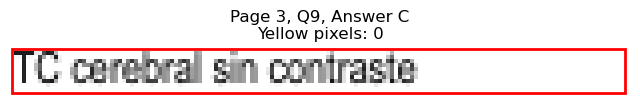

Page 3, Q9 - D: Detected box: x0=68.8, y0=747.6, x1=278.4, y1=758.6
Page 3, Q9, D: Yellow pixels: 0
Page 3, Q9, D: Total non-white pixels: 1040
Page 3, Q9, D: Yellow percentage: 0.0%


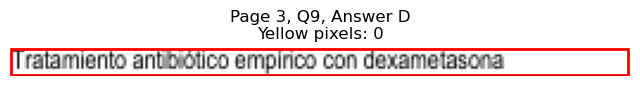


Page 3, Q9 - Selected Answer: A (based on yellow pixel count)





Page 4: Found 10 questions
Page 4, Q1 - A: Detected box: x0=68.3, y0=91.2, x1=85.8, y1=102.2
Page 4, Q1, A: Yellow pixels: 68
Page 4, Q1, A: Total non-white pixels: 223
Page 4, Q1, A: Yellow percentage: 30.5%


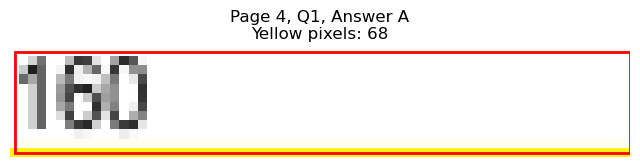

Page 4, Q1 - B: Detected box: x0=68.3, y0=103.8, x1=85.8, y1=114.8
Page 4, Q1, B: Yellow pixels: 751
Page 4, Q1, B: Total non-white pixels: 816
Page 4, Q1, B: Yellow percentage: 92.0%


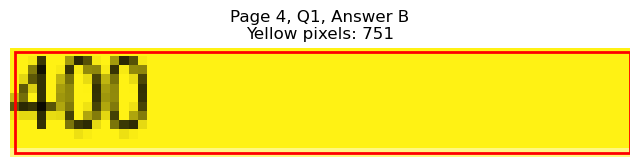

Page 4, Q1 - C: Detected box: x0=327.5, y0=91.2, x1=340.1, y1=102.2
Page 4, Q1, C: Yellow pixels: 0
Page 4, Q1, C: Total non-white pixels: 65
Page 4, Q1, C: Yellow percentage: 0.0%


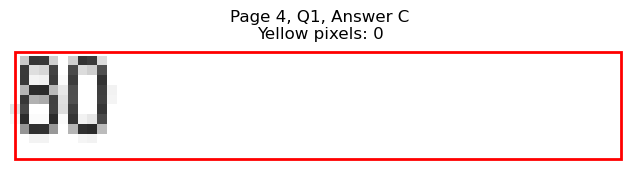

Page 4, Q1 - D: Detected box: x0=327.5, y0=103.8, x1=345.0, y1=114.8
Page 4, Q1, D: Yellow pixels: 0
Page 4, Q1, D: Total non-white pixels: 88
Page 4, Q1, D: Yellow percentage: 0.0%


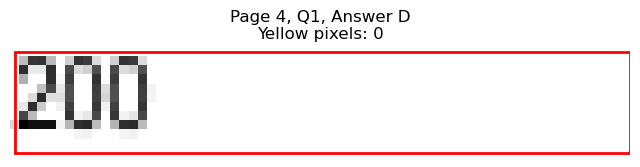


Page 4, Q1 - Selected Answer: B (based on yellow pixel count)




Page 4, Q2 - A: Detected box: x0=68.3, y0=166.9, x1=202.8, y1=177.9
Page 4, Q2, A: Yellow pixels: 0
Page 4, Q2, A: Total non-white pixels: 657
Page 4, Q2, A: Yellow percentage: 0.0%


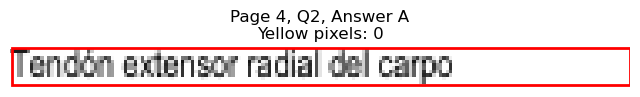

Page 4, Q2 - B: Detected box: x0=68.3, y0=179.5, x1=200.8, y1=190.5
Page 4, Q2, B: Yellow pixels: 0
Page 4, Q2, B: Total non-white pixels: 629
Page 4, Q2, B: Yellow percentage: 0.0%


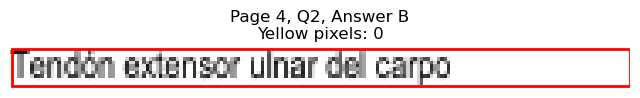

Page 4, Q2 - C: Detected box: x0=327.5, y0=166.9, x1=475.4, y1=177.9
Page 4, Q2, C: Yellow pixels: 1814
Page 4, Q2, C: Total non-white pixels: 2388
Page 4, Q2, C: Yellow percentage: 76.0%


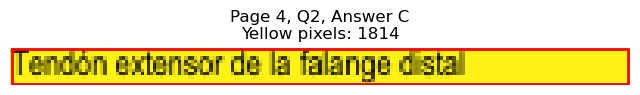

Page 4, Q2 - D: Detected box: x0=327.5, y0=179.5, x1=451.9, y1=190.5
Page 4, Q2, D: Yellow pixels: 0
Page 4, Q2, D: Total non-white pixels: 645
Page 4, Q2, D: Yellow percentage: 0.0%


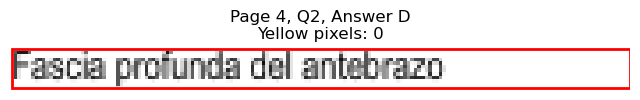


Page 4, Q2 - Selected Answer: C (based on yellow pixel count)




Page 4, Q3 - A: Detected box: x0=68.3, y0=230.0, x1=112.9, y1=241.0
Page 4, Q3, A: Yellow pixels: 0
Page 4, Q3, A: Total non-white pixels: 229
Page 4, Q3, A: Yellow percentage: 0.0%


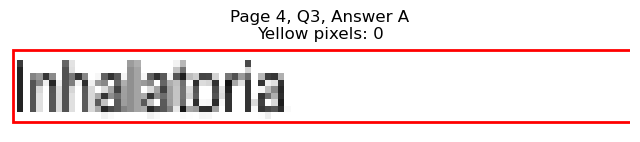

Page 4, Q3 - B: Detected box: x0=68.3, y0=242.6, x1=112.0, y1=253.6
Page 4, Q3, B: Yellow pixels: 0
Page 4, Q3, B: Total non-white pixels: 214
Page 4, Q3, B: Yellow percentage: 0.0%


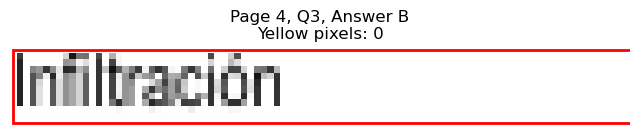

Page 4, Q3 - C: Detected box: x0=327.5, y0=230.0, x1=363.2, y1=241.0
Page 4, Q3, C: Yellow pixels: 87
Page 4, Q3, C: Total non-white pixels: 339
Page 4, Q3, C: Yellow percentage: 25.7%


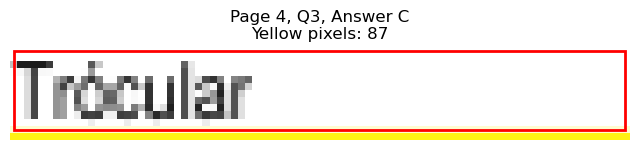

Page 4, Q3 - D: Detected box: x0=327.5, y0=242.6, x1=357.1, y1=253.6
Page 4, Q3, D: Yellow pixels: 777
Page 4, Q3, D: Total non-white pixels: 972
Page 4, Q3, D: Yellow percentage: 79.9%


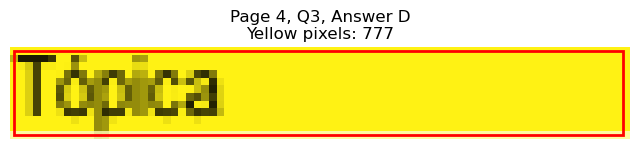


Page 4, Q3 - Selected Answer: D (based on yellow pixel count)




Page 4, Q4 - A: Detected box: x0=68.3, y0=293.1, x1=180.6, y1=304.2
Page 4, Q4, A: Yellow pixels: 1407
Page 4, Q4, A: Total non-white pixels: 1798
Page 4, Q4, A: Yellow percentage: 78.3%


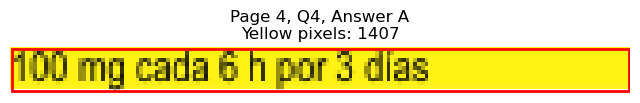

Page 4, Q4 - B: Detected box: x0=68.3, y0=305.7, x1=194.8, y1=316.8
Page 4, Q4, B: Yellow pixels: 0
Page 4, Q4, B: Total non-white pixels: 607
Page 4, Q4, B: Yellow percentage: 0.0%


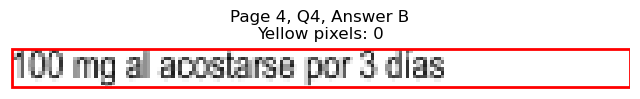

Page 4, Q4 - C: Detected box: x0=327.5, y0=293.1, x1=444.8, y1=304.2
Page 4, Q4, C: Yellow pixels: 0
Page 4, Q4, C: Total non-white pixels: 529
Page 4, Q4, C: Yellow percentage: 0.0%


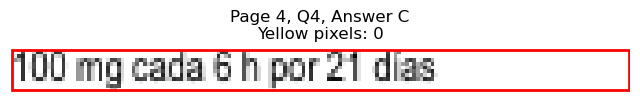

Page 4, Q4 - D: Detected box: x0=327.5, y0=305.7, x1=407.9, y1=316.8
Page 4, Q4, D: Yellow pixels: 0
Page 4, Q4, D: Total non-white pixels: 387
Page 4, Q4, D: Yellow percentage: 0.0%


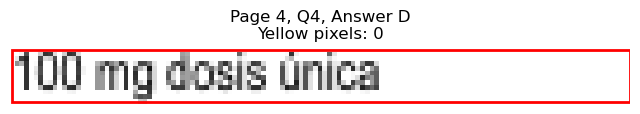


Page 4, Q4 - Selected Answer: A (based on yellow pixel count)




Page 4, Q5 - A: Detected box: x0=68.3, y0=368.8, x1=131.5, y1=379.9
Page 4, Q5, A: Yellow pixels: 1127
Page 4, Q5, A: Total non-white pixels: 1368
Page 4, Q5, A: Yellow percentage: 82.4%


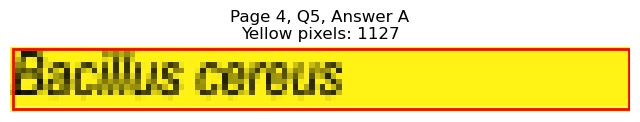

Page 4, Q5 - B: Detected box: x0=68.3, y0=381.4, x1=131.5, y1=392.5
Page 4, Q5, B: Yellow pixels: 0
Page 4, Q5, B: Total non-white pixels: 332
Page 4, Q5, B: Yellow percentage: 0.0%


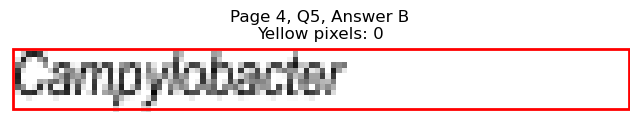

Page 4, Q5 - C: Detected box: x0=327.5, y0=368.8, x1=422.8, y1=379.9
Page 4, Q5, C: Yellow pixels: 0
Page 4, Q5, C: Total non-white pixels: 491
Page 4, Q5, C: Yellow percentage: 0.0%


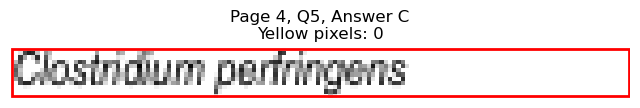

Page 4, Q5 - D: Detected box: x0=327.5, y0=381.4, x1=408.7, y1=392.5
Page 4, Q5, D: Yellow pixels: 0
Page 4, Q5, D: Total non-white pixels: 410
Page 4, Q5, D: Yellow percentage: 0.0%


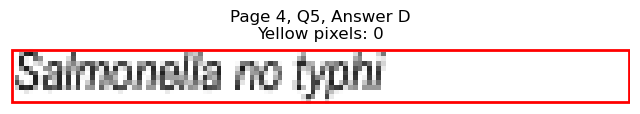


Page 4, Q5 - Selected Answer: A (based on yellow pixel count)




Page 4, Q6 - A: Detected box: x0=68.3, y0=432.0, x1=217.8, y1=443.0
Page 4, Q6, A: Yellow pixels: 0
Page 4, Q6, A: Total non-white pixels: 735
Page 4, Q6, A: Yellow percentage: 0.0%


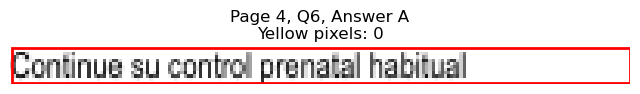

Page 4, Q6 - B: Detected box: x0=68.3, y0=444.6, x1=192.6, y1=455.6
Page 4, Q6, B: Yellow pixels: 0
Page 4, Q6, B: Total non-white pixels: 605
Page 4, Q6, B: Yellow percentage: 0.0%


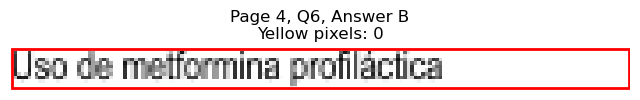

Page 4, Q6 - C: Detected box: x0=327.5, y0=432.0, x1=438.4, y1=443.0
Page 4, Q6, C: Yellow pixels: 0
Page 4, Q6, C: Total non-white pixels: 763
Page 4, Q6, C: Yellow percentage: 0.0%


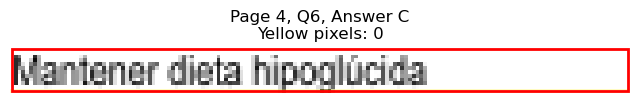

Page 4, Q6 - D: Detected box: x0=327.5, y0=444.6, x1=541.1, y1=455.6
Page 4, Q6, D: Yellow pixels: 1534
Page 4, Q6, D: Total non-white pixels: 2556
Page 4, Q6, D: Yellow percentage: 60.0%


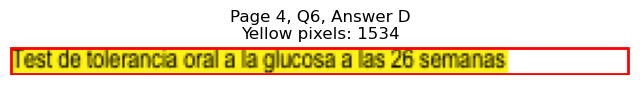


Page 4, Q6 - Selected Answer: D (based on yellow pixel count)




Page 4, Q7 - A: Detected box: x0=68.3, y0=495.1, x1=122.4, y1=506.1
Page 4, Q7, A: Yellow pixels: 946
Page 4, Q7, A: Total non-white pixels: 1155
Page 4, Q7, A: Yellow percentage: 81.9%


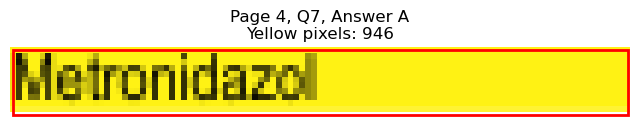

Page 4, Q7 - B: Detected box: x0=68.3, y0=507.7, x1=127.9, y1=518.7
Page 4, Q7, B: Yellow pixels: 0
Page 4, Q7, B: Total non-white pixels: 300
Page 4, Q7, B: Yellow percentage: 0.0%


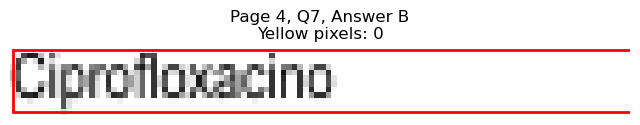

Page 4, Q7 - C: Detected box: x0=327.5, y0=495.1, x1=373.1, y1=506.1
Page 4, Q7, C: Yellow pixels: 0
Page 4, Q7, C: Total non-white pixels: 232
Page 4, Q7, C: Yellow percentage: 0.0%


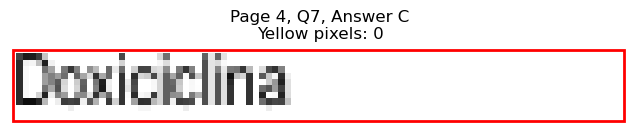

Page 4, Q7 - D: Detected box: x0=327.5, y0=507.7, x1=379.1, y1=518.7
Page 4, Q7, D: Yellow pixels: 0
Page 4, Q7, D: Total non-white pixels: 266
Page 4, Q7, D: Yellow percentage: 0.0%


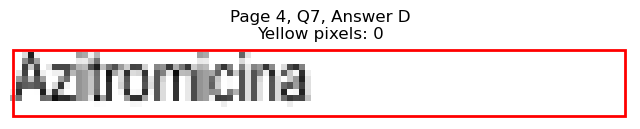


Page 4, Q7 - Selected Answer: A (based on yellow pixel count)




Page 4, Q8 - A: Detected box: x0=68.3, y0=558.2, x1=85.3, y1=569.2
Page 4, Q8, A: Yellow pixels: 0
Page 4, Q8, A: Total non-white pixels: 71
Page 4, Q8, A: Yellow percentage: 0.0%


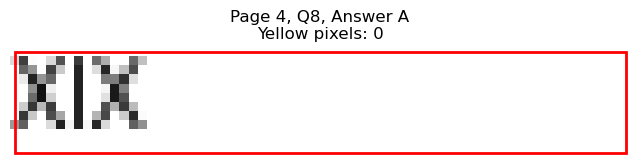

Page 4, Q8 - B: Detected box: x0=68.3, y0=570.8, x1=76.8, y1=581.8
Page 4, Q8, B: Yellow pixels: 0
Page 4, Q8, B: Total non-white pixels: 28
Page 4, Q8, B: Yellow percentage: 0.0%


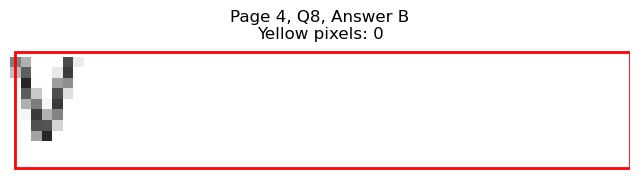

Page 4, Q8 - C: Detected box: x0=327.5, y0=558.2, x1=341.0, y1=569.2
Page 4, Q8, C: Yellow pixels: 671
Page 4, Q8, C: Total non-white pixels: 715
Page 4, Q8, C: Yellow percentage: 93.8%


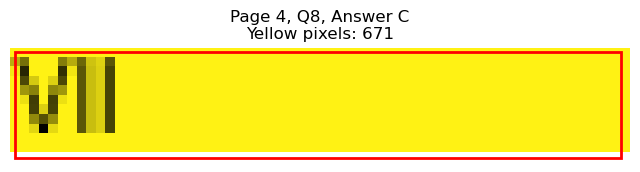

Page 4, Q8 - D: Detected box: x0=327.5, y0=570.8, x1=343.6, y1=581.8
Page 4, Q8, D: Yellow pixels: 0
Page 4, Q8, D: Total non-white pixels: 77
Page 4, Q8, D: Yellow percentage: 0.0%


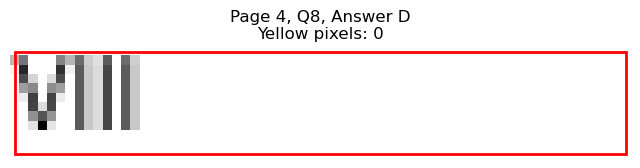


Page 4, Q8 - Selected Answer: C (based on yellow pixel count)




Page 4, Q9 - A: Detected box: x0=68.3, y0=621.3, x1=178.1, y1=632.4
Page 4, Q9, A: Yellow pixels: 1347
Page 4, Q9, A: Total non-white pixels: 1932
Page 4, Q9, A: Yellow percentage: 69.7%


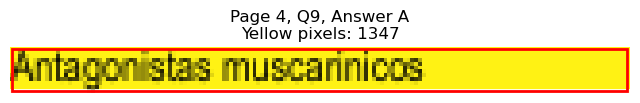

Page 4, Q9 - B: Detected box: x0=68.3, y0=633.9, x1=219.7, y1=645.0
Page 4, Q9, B: Yellow pixels: 0
Page 4, Q9, B: Total non-white pixels: 757
Page 4, Q9, B: Yellow percentage: 0.0%


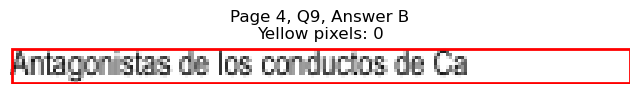

Page 4, Q9 - C: Detected box: x0=327.5, y0=621.3, x1=454.0, y1=632.4
Page 4, Q9, C: Yellow pixels: 0
Page 4, Q9, C: Total non-white pixels: 683
Page 4, Q9, C: Yellow percentage: 0.0%


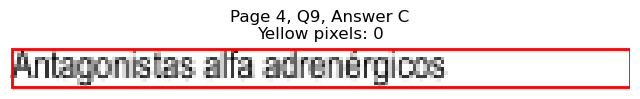

Page 4, Q9 - D: Detected box: x0=327.5, y0=633.9, x1=410.3, y1=645.0
Page 4, Q9, D: Yellow pixels: 0
Page 4, Q9, D: Total non-white pixels: 426
Page 4, Q9, D: Yellow percentage: 0.0%


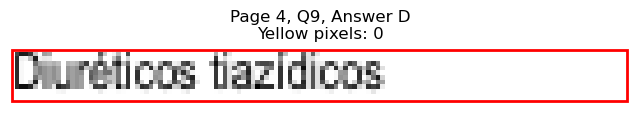


Page 4, Q9 - Selected Answer: A (based on yellow pixel count)




Page 4, Q10 - A: Detected box: x0=68.3, y0=684.3, x1=221.5, y1=695.4
Page 4, Q10, A: Yellow pixels: 204
Page 4, Q10, A: Total non-white pixels: 986
Page 4, Q10, A: Yellow percentage: 20.7%


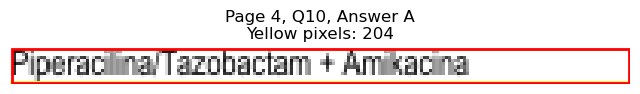

Page 4, Q10 - B: Detected box: x0=68.3, y0=697.0, x1=172.8, y1=708.1
Page 4, Q10, B: Yellow pixels: 1323
Page 4, Q10, B: Total non-white pixels: 1707
Page 4, Q10, B: Yellow percentage: 77.5%


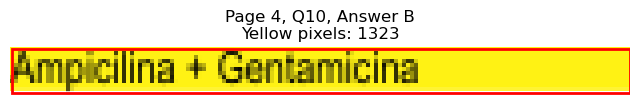

Page 4, Q10 - C: Detected box: x0=327.5, y0=684.3, x1=427.6, y1=695.4
Page 4, Q10, C: Yellow pixels: 0
Page 4, Q10, C: Total non-white pixels: 492
Page 4, Q10, C: Yellow percentage: 0.0%


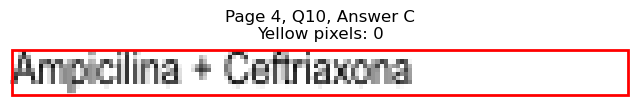

Page 4, Q10 - D: Detected box: x0=327.5, y0=697.0, x1=373.2, y1=708.1
Page 4, Q10, D: Yellow pixels: 0
Page 4, Q10, D: Total non-white pixels: 255
Page 4, Q10, D: Yellow percentage: 0.0%


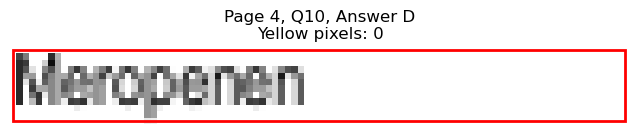


Page 4, Q10 - Selected Answer: B (based on yellow pixel count)





Page 5: Found 8 questions
Page 5, Q1 - A: Detected box: x0=68.3, y0=116.4, x1=122.5, y1=127.4
Page 5, Q1, A: Yellow pixels: 0
Page 5, Q1, A: Total non-white pixels: 286
Page 5, Q1, A: Yellow percentage: 0.0%


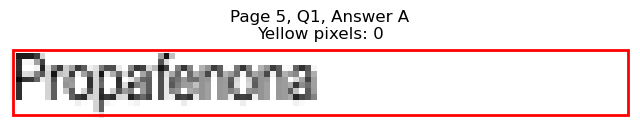

Page 5, Q1 - B: Detected box: x0=68.3, y0=129.0, x1=116.4, y1=140.0
Page 5, Q1, B: Yellow pixels: 0
Page 5, Q1, B: Total non-white pixels: 249
Page 5, Q1, B: Yellow percentage: 0.0%


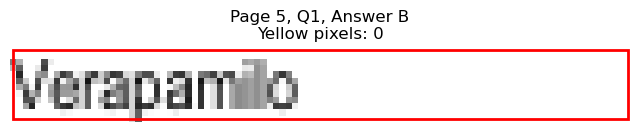

Page 5, Q1 - C: Detected box: x0=327.5, y0=116.4, x1=367.1, y1=127.4
Page 5, Q1, C: Yellow pixels: 91
Page 5, Q1, C: Total non-white pixels: 296
Page 5, Q1, C: Yellow percentage: 30.7%


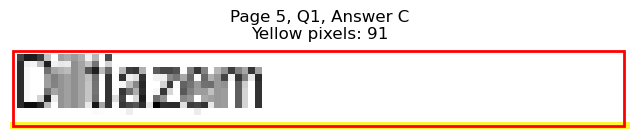

Page 5, Q1 - D: Detected box: x0=327.5, y0=129.0, x1=365.0, y1=140.0
Page 5, Q1, D: Yellow pixels: 920
Page 5, Q1, D: Total non-white pixels: 1068
Page 5, Q1, D: Yellow percentage: 86.1%


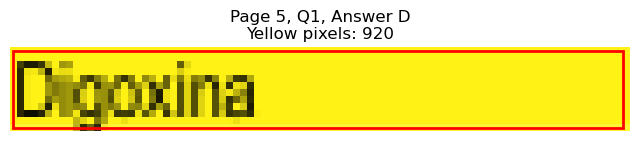


Page 5, Q1 - Selected Answer: D (based on yellow pixel count)




Page 5, Q2 - A: Detected box: x0=68.3, y0=204.7, x1=103.4, y1=215.7
Page 5, Q2, A: Yellow pixels: 1
Page 5, Q2, A: Total non-white pixels: 274
Page 5, Q2, A: Yellow percentage: 0.4%


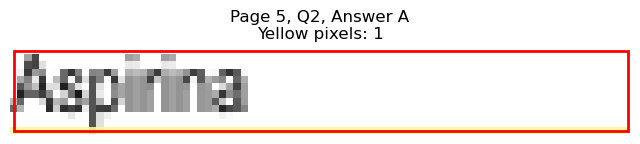

Page 5, Q2 - B: Detected box: x0=68.3, y0=217.4, x1=121.4, y1=228.4
Page 5, Q2, B: Yellow pixels: 934
Page 5, Q2, B: Total non-white pixels: 1248
Page 5, Q2, B: Yellow percentage: 74.8%


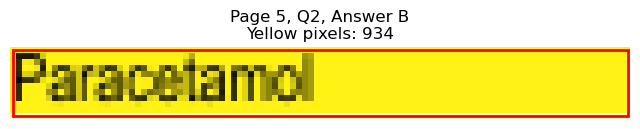

Page 5, Q2 - C: Detected box: x0=327.5, y0=204.7, x1=374.2, y1=215.7
Page 5, Q2, C: Yellow pixels: 0
Page 5, Q2, C: Total non-white pixels: 238
Page 5, Q2, C: Yellow percentage: 0.0%


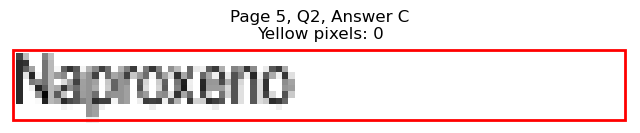

Page 5, Q2 - D: Detected box: x0=327.5, y0=217.4, x1=371.2, y1=228.4
Page 5, Q2, D: Yellow pixels: 0
Page 5, Q2, D: Total non-white pixels: 229
Page 5, Q2, D: Yellow percentage: 0.0%


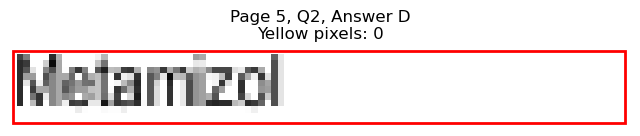


Page 5, Q2 - Selected Answer: B (based on yellow pixel count)




Page 5, Q3 - A: Detected box: x0=68.3, y0=293.1, x1=298.9, y1=304.2
Page 5, Q3, A: Yellow pixels: 0
Page 5, Q3, A: Total non-white pixels: 1189
Page 5, Q3, A: Yellow percentage: 0.0%


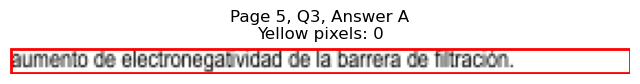

Page 5, Q3 - B: Detected box: x0=68.3, y0=305.7, x1=247.8, y1=316.8
Page 5, Q3, B: Yellow pixels: 0
Page 5, Q3, B: Total non-white pixels: 900
Page 5, Q3, B: Yellow percentage: 0.0%


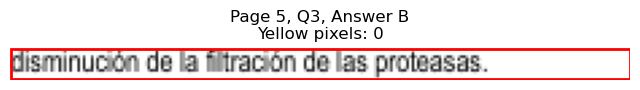

Page 5, Q3 - C: Detected box: x0=68.8, y0=318.3, x1=254.3, y1=329.4
Page 5, Q3, C: Yellow pixels: 237
Page 5, Q3, C: Total non-white pixels: 1162
Page 5, Q3, C: Yellow percentage: 20.4%


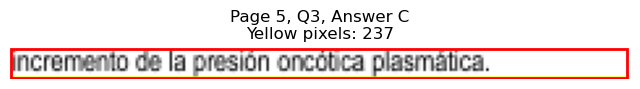

Page 5, Q3 - D: Detected box: x0=68.8, y0=330.9, x1=349.6, y1=342.0
Page 5, Q3, D: Yellow pixels: 2952
Page 5, Q3, D: Total non-white pixels: 3984
Page 5, Q3, D: Yellow percentage: 74.1%


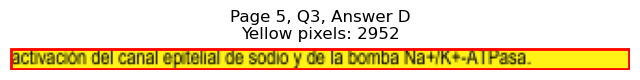


Page 5, Q3 - Selected Answer: D (based on yellow pixel count)




Page 5, Q4 - A: Detected box: x0=68.3, y0=381.4, x1=106.0, y1=392.5
Page 5, Q4, A: Yellow pixels: 88
Page 5, Q4, A: Total non-white pixels: 265
Page 5, Q4, A: Yellow percentage: 33.2%


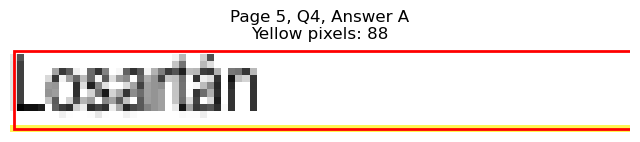

Page 5, Q4 - B: Detected box: x0=68.3, y0=394.0, x1=110.4, y1=405.1
Page 5, Q4, B: Yellow pixels: 861
Page 5, Q4, B: Total non-white pixels: 1023
Page 5, Q4, B: Yellow percentage: 84.2%


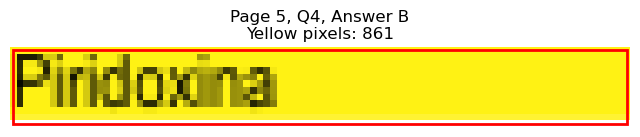

Page 5, Q4 - C: Detected box: x0=327.5, y0=381.4, x1=375.1, y1=392.5
Page 5, Q4, C: Yellow pixels: 0
Page 5, Q4, C: Total non-white pixels: 251
Page 5, Q4, C: Yellow percentage: 0.0%


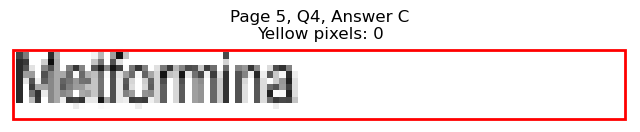

Page 5, Q4 - D: Detected box: x0=327.5, y0=394.0, x1=369.6, y1=405.1
Page 5, Q4, D: Yellow pixels: 0
Page 5, Q4, D: Total non-white pixels: 226
Page 5, Q4, D: Yellow percentage: 0.0%


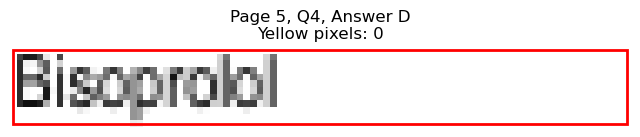


Page 5, Q4 - Selected Answer: B (based on yellow pixel count)




Page 5, Q5 - A: Detected box: x0=68.3, y0=482.5, x1=111.4, y1=493.5
Page 5, Q5, A: Yellow pixels: 0
Page 5, Q5, A: Total non-white pixels: 256
Page 5, Q5, A: Yellow percentage: 0.0%


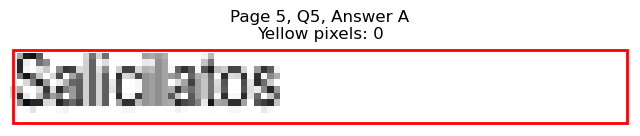

Page 5, Q5 - B: Detected box: x0=68.3, y0=495.1, x1=169.6, y1=506.1
Page 5, Q5, B: Yellow pixels: 0
Page 5, Q5, B: Total non-white pixels: 530
Page 5, Q5, B: Yellow percentage: 0.0%


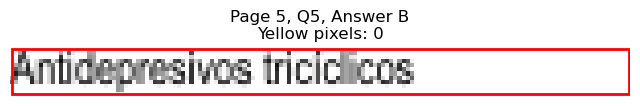

Page 5, Q5 - C: Detected box: x0=327.5, y0=482.5, x1=380.6, y1=493.5
Page 5, Q5, C: Yellow pixels: 945
Page 5, Q5, C: Total non-white pixels: 1248
Page 5, Q5, C: Yellow percentage: 75.7%


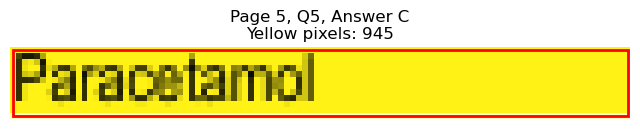

Page 5, Q5 - D: Detected box: x0=327.5, y0=495.1, x1=373.1, y1=506.1
Page 5, Q5, D: Yellow pixels: 0
Page 5, Q5, D: Total non-white pixels: 238
Page 5, Q5, D: Yellow percentage: 0.0%


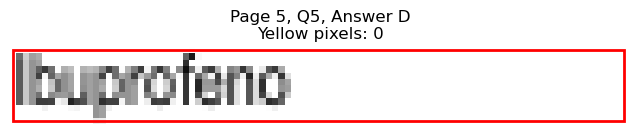


Page 5, Q5 - Selected Answer: C (based on yellow pixel count)




Page 5, Q6 - A: Detected box: x0=68.3, y0=583.4, x1=195.7, y1=594.4
Page 5, Q6, A: Yellow pixels: 0
Page 5, Q6, A: Total non-white pixels: 669
Page 5, Q6, A: Yellow percentage: 0.0%


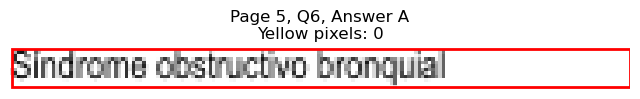

Page 5, Q6 - B: Detected box: x0=68.3, y0=596.0, x1=130.4, y1=607.0
Page 5, Q6, B: Yellow pixels: 0
Page 5, Q6, B: Total non-white pixels: 320
Page 5, Q6, B: Yellow percentage: 0.0%


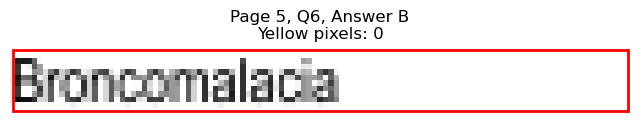

Page 5, Q6 - C: Detected box: x0=327.5, y0=583.4, x1=397.7, y1=594.4
Page 5, Q6, C: Yellow pixels: 121
Page 5, Q6, C: Total non-white pixels: 475
Page 5, Q6, C: Yellow percentage: 25.5%


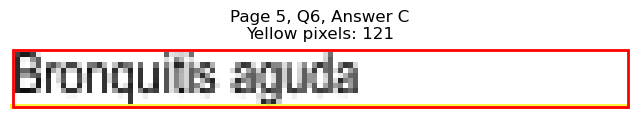

Page 5, Q6 - D: Detected box: x0=327.5, y0=596.0, x1=406.7, y1=607.0
Page 5, Q6, D: Yellow pixels: 1259
Page 5, Q6, D: Total non-white pixels: 1564
Page 5, Q6, D: Yellow percentage: 80.5%


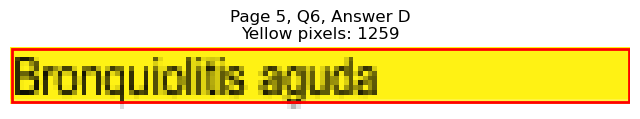


Page 5, Q6 - Selected Answer: D (based on yellow pixel count)




Page 5, Q7 - A: Detected box: x0=68.3, y0=633.9, x1=188.2, y1=645.0
Page 5, Q7, A: Yellow pixels: 0
Page 5, Q7, A: Total non-white pixels: 639
Page 5, Q7, A: Yellow percentage: 0.0%


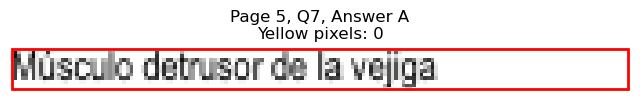

Page 5, Q7 - B: Detected box: x0=68.3, y0=646.5, x1=197.6, y1=657.6
Page 5, Q7, B: Yellow pixels: 0
Page 5, Q7, B: Total non-white pixels: 677
Page 5, Q7, B: Yellow percentage: 0.0%


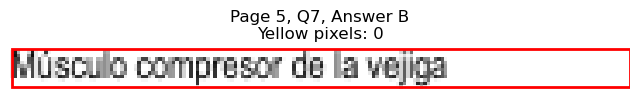

Page 5, Q7 - C: Detected box: x0=327.5, y0=633.9, x1=439.3, y1=645.0
Page 5, Q7, C: Yellow pixels: 1525
Page 5, Q7, C: Total non-white pixels: 1956
Page 5, Q7, C: Yellow percentage: 78.0%


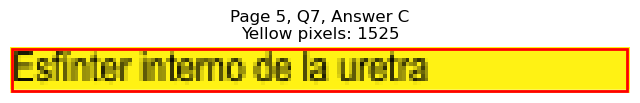

Page 5, Q7 - D: Detected box: x0=327.5, y0=646.5, x1=441.8, y1=657.6
Page 5, Q7, D: Yellow pixels: 0
Page 5, Q7, D: Total non-white pixels: 569
Page 5, Q7, D: Yellow percentage: 0.0%


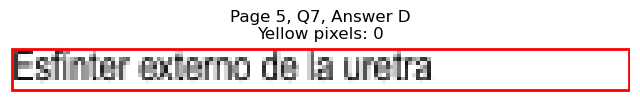


Page 5, Q7 - Selected Answer: C (based on yellow pixel count)




Page 5, Q8 - A: Detected box: x0=68.3, y0=709.6, x1=153.5, y1=720.7
Page 5, Q8, A: Yellow pixels: 0
Page 5, Q8, A: Total non-white pixels: 456
Page 5, Q8, A: Yellow percentage: 0.0%


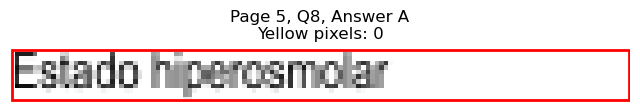

Page 5, Q8 - B: Detected box: x0=68.3, y0=722.2, x1=212.3, y1=733.3
Page 5, Q8, B: Yellow pixels: 0
Page 5, Q8, B: Total non-white pixels: 752
Page 5, Q8, B: Yellow percentage: 0.0%


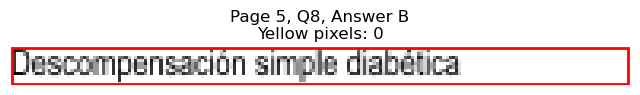

Page 5, Q8 - C: Detected box: x0=327.5, y0=709.6, x1=420.2, y1=720.7
Page 5, Q8, C: Yellow pixels: 1368
Page 5, Q8, C: Total non-white pixels: 1728
Page 5, Q8, C: Yellow percentage: 79.2%


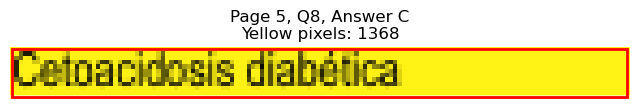

Page 5, Q8 - D: Detected box: x0=327.5, y0=722.2, x1=427.3, y1=733.3
Page 5, Q8, D: Yellow pixels: 0
Page 5, Q8, D: Total non-white pixels: 543
Page 5, Q8, D: Yellow percentage: 0.0%


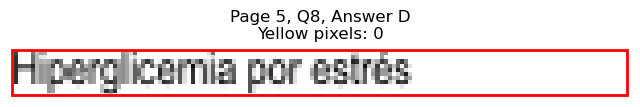


Page 5, Q8 - Selected Answer: C (based on yellow pixel count)





Page 6: Found 9 questions
Page 6, Q1 - A: Detected box: x0=68.3, y0=103.8, x1=183.1, y1=114.8
Page 6, Q1, A: Yellow pixels: 0
Page 6, Q1, A: Total non-white pixels: 559
Page 6, Q1, A: Yellow percentage: 0.0%


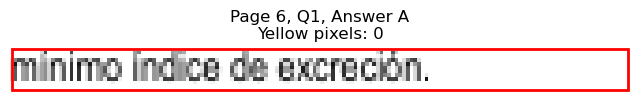

Page 6, Q1 - B: Detected box: x0=68.3, y0=116.4, x1=169.6, y1=127.4
Page 6, Q1, B: Yellow pixels: 0
Page 6, Q1, B: Total non-white pixels: 501
Page 6, Q1, B: Yellow percentage: 0.0%


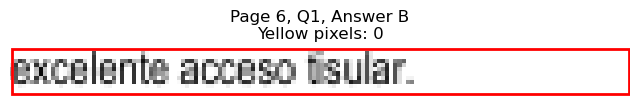

Page 6, Q1 - C: Detected box: x0=327.5, y0=103.8, x1=417.2, y1=114.8
Page 6, Q1, C: Yellow pixels: 1353
Page 6, Q1, C: Total non-white pixels: 1692
Page 6, Q1, C: Yellow percentage: 80.0%


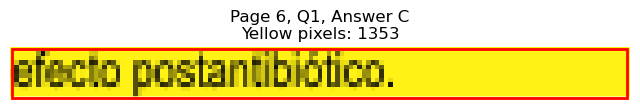

Page 6, Q1 - D: Detected box: x0=327.5, y0=116.4, x1=530.0, y1=127.4
Page 6, Q1, D: Yellow pixels: 0
Page 6, Q1, D: Total non-white pixels: 1058
Page 6, Q1, D: Yellow percentage: 0.0%


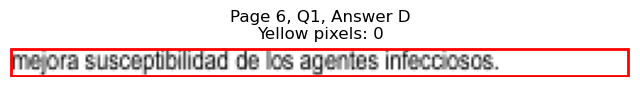


Page 6, Q1 - Selected Answer: C (based on yellow pixel count)




Page 6, Q2 - A: Detected box: x0=68.3, y0=192.1, x1=185.2, y1=203.1
Page 6, Q2, A: Yellow pixels: 168
Page 6, Q2, A: Total non-white pixels: 914
Page 6, Q2, A: Yellow percentage: 18.4%


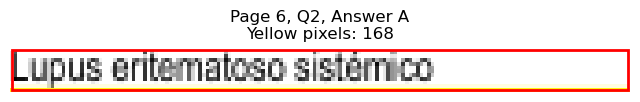

Page 6, Q2 - B: Detected box: x0=68.3, y0=204.7, x1=196.7, y1=215.7
Page 6, Q2, B: Yellow pixels: 1651
Page 6, Q2, B: Total non-white pixels: 2148
Page 6, Q2, B: Yellow percentage: 76.9%


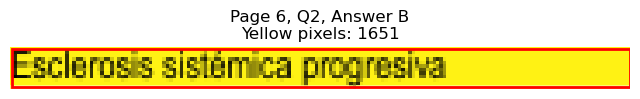

Page 6, Q2 - C: Detected box: x0=327.5, y0=192.1, x1=408.7, y1=203.1
Page 6, Q2, C: Yellow pixels: 0
Page 6, Q2, C: Total non-white pixels: 443
Page 6, Q2, C: Yellow percentage: 0.0%


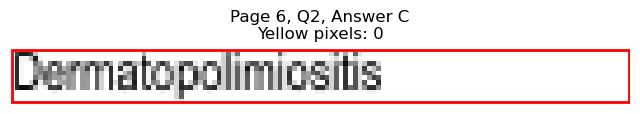

Page 6, Q2 - D: Detected box: x0=327.5, y0=204.7, x1=408.2, y1=215.7
Page 6, Q2, D: Yellow pixels: 0
Page 6, Q2, D: Total non-white pixels: 426
Page 6, Q2, D: Yellow percentage: 0.0%


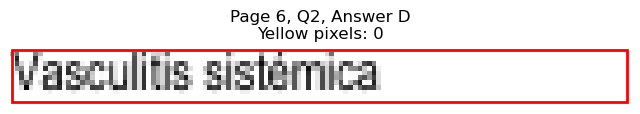


Page 6, Q2 - Selected Answer: B (based on yellow pixel count)




Page 6, Q3 - A: Detected box: x0=68.3, y0=267.8, x1=87.8, y1=278.8
Page 6, Q3, A: Yellow pixels: 0
Page 6, Q3, A: Total non-white pixels: 72
Page 6, Q3, A: Yellow percentage: 0.0%


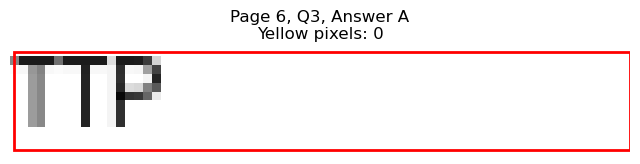

Page 6, Q3 - B: Detected box: x0=68.3, y0=280.5, x1=105.8, y1=291.6
Page 6, Q3, B: Yellow pixels: 0
Page 6, Q3, B: Total non-white pixels: 195
Page 6, Q3, B: Yellow percentage: 0.0%


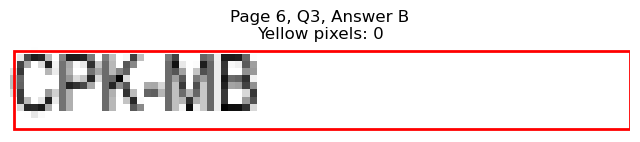

Page 6, Q3 - C: Detected box: x0=327.5, y0=267.8, x1=368.6, y1=278.8
Page 6, Q3, C: Yellow pixels: 952
Page 6, Q3, C: Total non-white pixels: 1104
Page 6, Q3, C: Yellow percentage: 86.2%


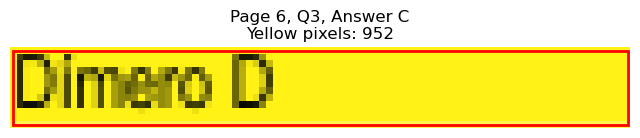

Page 6, Q3 - D: Detected box: x0=327.5, y0=280.5, x1=341.5, y1=291.6
Page 6, Q3, D: Yellow pixels: 0
Page 6, Q3, D: Total non-white pixels: 56
Page 6, Q3, D: Yellow percentage: 0.0%


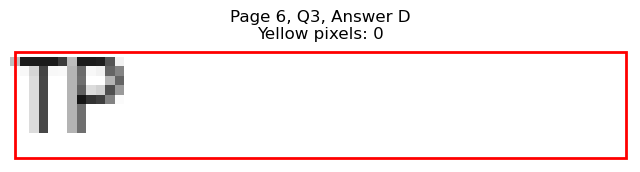


Page 6, Q3 - Selected Answer: C (based on yellow pixel count)




Page 6, Q4 - A: Detected box: x0=68.3, y0=356.2, x1=220.7, y1=367.3
Page 6, Q4, A: Yellow pixels: 1700
Page 6, Q4, A: Total non-white pixels: 2436
Page 6, Q4, A: Yellow percentage: 69.8%


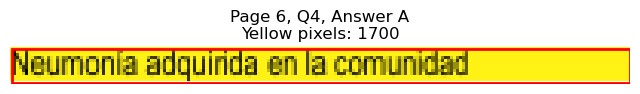

Page 6, Q4 - B: Detected box: x0=68.3, y0=368.8, x1=119.9, y1=379.9
Page 6, Q4, B: Yellow pixels: 0
Page 6, Q4, B: Total non-white pixels: 267
Page 6, Q4, B: Yellow percentage: 0.0%


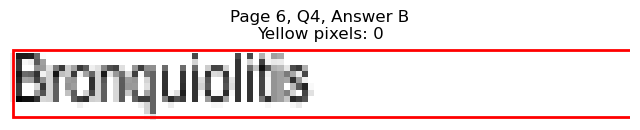

Page 6, Q4 - C: Detected box: x0=327.5, y0=356.2, x1=397.7, y1=367.3
Page 6, Q4, C: Yellow pixels: 0
Page 6, Q4, C: Total non-white pixels: 358
Page 6, Q4, C: Yellow percentage: 0.0%


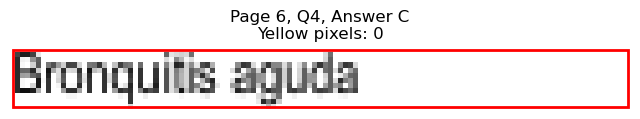

Page 6, Q4 - D: Detected box: x0=327.5, y0=368.8, x1=400.7, y1=379.9
Page 6, Q4, D: Yellow pixels: 0
Page 6, Q4, D: Total non-white pixels: 376
Page 6, Q4, D: Yellow percentage: 0.0%


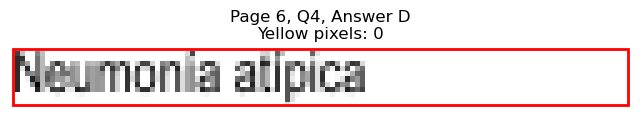


Page 6, Q4 - Selected Answer: A (based on yellow pixel count)




Page 6, Q5 - A: Detected box: x0=68.3, y0=432.0, x1=144.5, y1=443.0
Page 6, Q5, A: Yellow pixels: 0
Page 6, Q5, A: Total non-white pixels: 381
Page 6, Q5, A: Yellow percentage: 0.0%


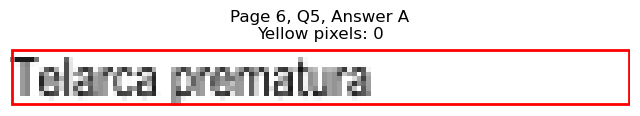

Page 6, Q5 - B: Detected box: x0=68.3, y0=444.6, x1=186.6, y1=455.6
Page 6, Q5, B: Yellow pixels: 0
Page 6, Q5, B: Total non-white pixels: 599
Page 6, Q5, B: Yellow percentage: 0.0%


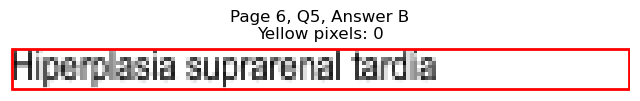

Page 6, Q5 - C: Detected box: x0=327.5, y0=432.0, x1=425.8, y1=443.0
Page 6, Q5, C: Yellow pixels: 0
Page 6, Q5, C: Total non-white pixels: 619
Page 6, Q5, C: Yellow percentage: 0.0%


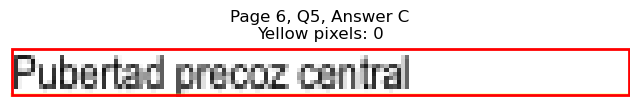

Page 6, Q5 - D: Detected box: x0=327.5, y0=444.6, x1=422.8, y1=455.6
Page 6, Q5, D: Yellow pixels: 1263
Page 6, Q5, D: Total non-white pixels: 1752
Page 6, Q5, D: Yellow percentage: 72.1%


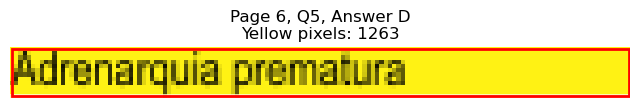


Page 6, Q5 - Selected Answer: D (based on yellow pixel count)




Page 6, Q6 - A: Detected box: x0=68.3, y0=507.7, x1=135.0, y1=518.7
Page 6, Q6, A: Yellow pixels: 117
Page 6, Q6, A: Total non-white pixels: 492
Page 6, Q6, A: Yellow percentage: 23.8%


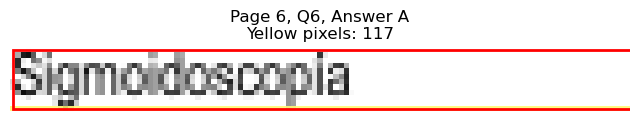

Page 6, Q6 - B: Detected box: x0=68.3, y0=520.3, x1=252.4, y1=531.3
Page 6, Q6, B: Yellow pixels: 1641
Page 6, Q6, B: Total non-white pixels: 2567
Page 6, Q6, B: Yellow percentage: 63.9%


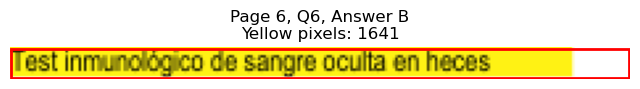

Page 6, Q6 - C: Detected box: x0=327.5, y0=507.7, x1=385.2, y1=518.7
Page 6, Q6, C: Yellow pixels: 0
Page 6, Q6, C: Total non-white pixels: 295
Page 6, Q6, C: Yellow percentage: 0.0%


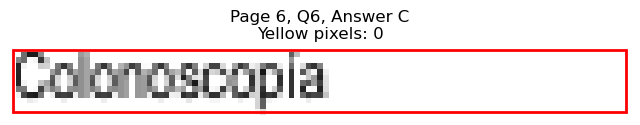

Page 6, Q6 - D: Detected box: x0=327.5, y0=520.3, x1=504.6, y1=531.3
Page 6, Q6, D: Yellow pixels: 0
Page 6, Q6, D: Total non-white pixels: 901
Page 6, Q6, D: Yellow percentage: 0.0%


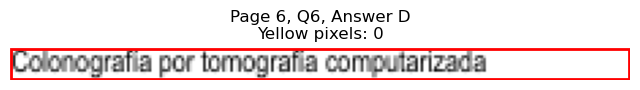


Page 6, Q6 - Selected Answer: B (based on yellow pixel count)




Page 6, Q7 - A: Detected box: x0=68.3, y0=583.4, x1=161.0, y1=594.4
Page 6, Q7, A: Yellow pixels: 1213
Page 6, Q7, A: Total non-white pixels: 1728
Page 6, Q7, A: Yellow percentage: 70.2%


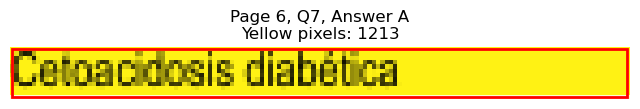

Page 6, Q7 - B: Detected box: x0=68.3, y0=596.0, x1=179.2, y1=607.0
Page 6, Q7, B: Yellow pixels: 0
Page 6, Q7, B: Total non-white pixels: 569
Page 6, Q7, B: Yellow percentage: 0.0%


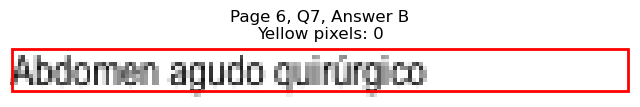

Page 6, Q7 - C: Detected box: x0=327.5, y0=583.4, x1=390.1, y1=594.4
Page 6, Q7, C: Yellow pixels: 0
Page 6, Q7, C: Total non-white pixels: 324
Page 6, Q7, C: Yellow percentage: 0.0%


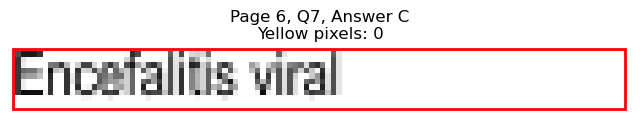

Page 6, Q7 - D: Detected box: x0=327.5, y0=596.0, x1=465.8, y1=607.0
Page 6, Q7, D: Yellow pixels: 0
Page 6, Q7, D: Total non-white pixels: 730
Page 6, Q7, D: Yellow percentage: 0.0%


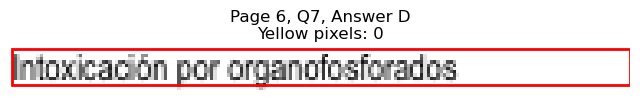


Page 6, Q7 - Selected Answer: A (based on yellow pixel count)




Page 6, Q8 - A: Detected box: x0=68.3, y0=659.1, x1=195.7, y1=670.2
Page 6, Q8, A: Yellow pixels: 0
Page 6, Q8, A: Total non-white pixels: 655
Page 6, Q8, A: Yellow percentage: 0.0%


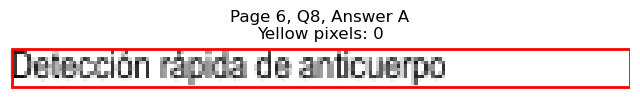

Page 6, Q8 - B: Detected box: x0=68.3, y0=671.7, x1=144.0, y1=682.8
Page 6, Q8, B: Yellow pixels: 0
Page 6, Q8, B: Total non-white pixels: 419
Page 6, Q8, B: Yellow percentage: 0.0%


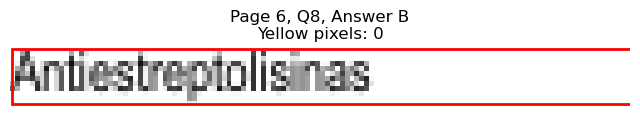

Page 6, Q8 - C: Detected box: x0=327.5, y0=659.1, x1=446.9, y1=670.2
Page 6, Q8, C: Yellow pixels: 170
Page 6, Q8, C: Total non-white pixels: 937
Page 6, Q8, C: Yellow percentage: 18.1%


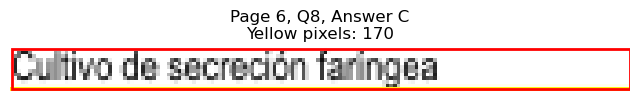

Page 6, Q8 - D: Detected box: x0=327.5, y0=671.7, x1=447.8, y1=682.8
Page 6, Q8, D: Yellow pixels: 1615
Page 6, Q8, D: Total non-white pixels: 2052
Page 6, Q8, D: Yellow percentage: 78.7%


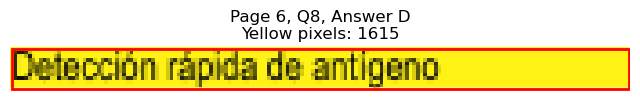


Page 6, Q8 - Selected Answer: D (based on yellow pixel count)




Page 6, Q9 - A: Detected box: x0=68.3, y0=722.2, x1=151.1, y1=733.3
Page 6, Q9, A: Yellow pixels: 0
Page 6, Q9, A: Total non-white pixels: 437
Page 6, Q9, A: Yellow percentage: 0.0%


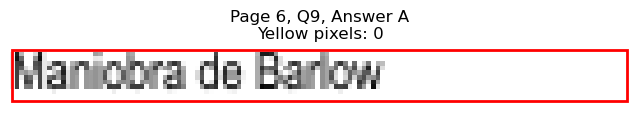

Page 6, Q9 - B: Detected box: x0=68.3, y0=734.8, x1=117.5, y1=745.9
Page 6, Q9, B: Yellow pixels: 0
Page 6, Q9, B: Total non-white pixels: 285
Page 6, Q9, B: Yellow percentage: 0.0%


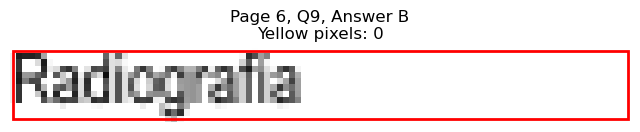

Page 6, Q9 - C: Detected box: x0=327.5, y0=722.2, x1=368.6, y1=733.3
Page 6, Q9, C: Yellow pixels: 842
Page 6, Q9, C: Total non-white pixels: 1104
Page 6, Q9, C: Yellow percentage: 76.3%


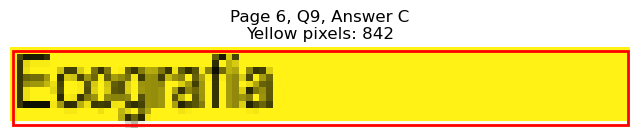

Page 6, Q9 - D: Detected box: x0=327.5, y0=734.8, x1=414.2, y1=745.9
Page 6, Q9, D: Yellow pixels: 0
Page 6, Q9, D: Total non-white pixels: 446
Page 6, Q9, D: Yellow percentage: 0.0%


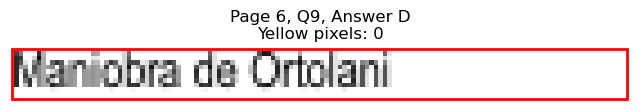


Page 6, Q9 - Selected Answer: C (based on yellow pixel count)





Page 7: Found 9 questions
Page 7, Q1 - A: Detected box: x0=68.3, y0=103.8, x1=145.1, y1=114.8
Page 7, Q1, A: Yellow pixels: 0
Page 7, Q1, A: Total non-white pixels: 383
Page 7, Q1, A: Yellow percentage: 0.0%


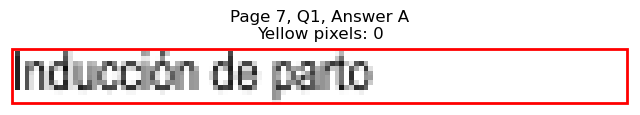

Page 7, Q1 - B: Detected box: x0=68.3, y0=116.4, x1=168.1, y1=127.4
Page 7, Q1, B: Yellow pixels: 0
Page 7, Q1, B: Total non-white pixels: 518
Page 7, Q1, B: Yellow percentage: 0.0%


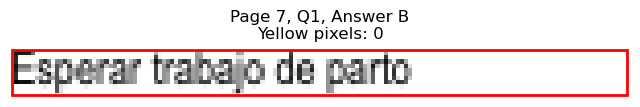

Page 7, Q1 - C: Detected box: x0=327.5, y0=103.8, x1=427.8, y1=114.8
Page 7, Q1, C: Yellow pixels: 1444
Page 7, Q1, C: Total non-white pixels: 1812
Page 7, Q1, C: Yellow percentage: 79.7%


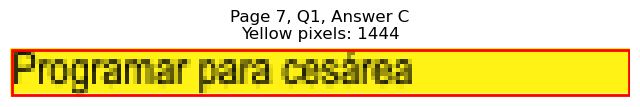

Page 7, Q1 - D: Detected box: x0=327.5, y0=116.4, x1=410.3, y1=127.4
Page 7, Q1, D: Yellow pixels: 0
Page 7, Q1, D: Total non-white pixels: 435
Page 7, Q1, D: Yellow percentage: 0.0%


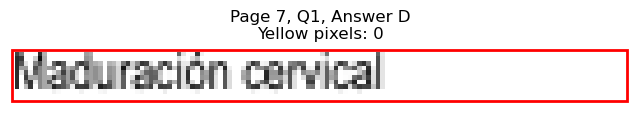


Page 7, Q1 - Selected Answer: C (based on yellow pixel count)




Page 7, Q2 - A: Detected box: x0=68.3, y0=179.5, x1=502.7, y1=190.5
Page 7, Q2, A: Yellow pixels: 3556
Page 7, Q2, A: Total non-white pixels: 5664
Page 7, Q2, A: Yellow percentage: 62.8%


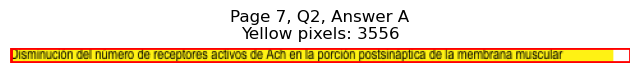

Page 7, Q2 - B: Detected box: x0=68.3, y0=192.1, x1=382.7, y1=203.1
Page 7, Q2, B: Yellow pixels: 0
Page 7, Q2, B: Total non-white pixels: 1602
Page 7, Q2, B: Yellow percentage: 0.0%


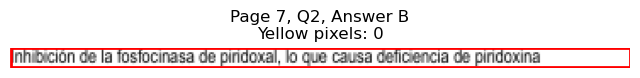

Page 7, Q2 - C: Detected box: x0=68.8, y0=204.7, x1=427.8, y1=215.7
Page 7, Q2, C: Yellow pixels: 0
Page 7, Q2, C: Total non-white pixels: 1807
Page 7, Q2, C: Yellow percentage: 0.0%


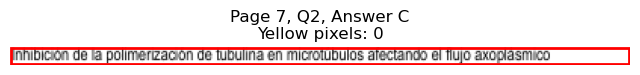

Page 7, Q2 - D: Detected box: x0=68.8, y0=217.4, x1=417.8, y1=228.4
Page 7, Q2, D: Yellow pixels: 0
Page 7, Q2, D: Total non-white pixels: 1726
Page 7, Q2, D: Yellow percentage: 0.0%


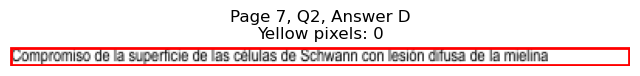


Page 7, Q2 - Selected Answer: A (based on yellow pixel count)




Page 7, Q3 - A: Detected box: x0=68.3, y0=280.5, x1=107.9, y1=291.6
Page 7, Q3, A: Yellow pixels: 810
Page 7, Q3, A: Total non-white pixels: 1080
Page 7, Q3, A: Yellow percentage: 75.0%


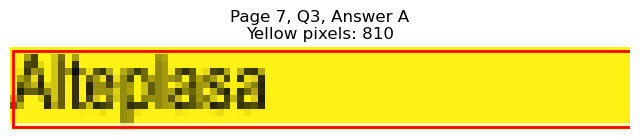

Page 7, Q3 - B: Detected box: x0=68.3, y0=293.1, x1=101.9, y1=304.2
Page 7, Q3, B: Yellow pixels: 0
Page 7, Q3, B: Total non-white pixels: 184
Page 7, Q3, B: Yellow percentage: 0.0%


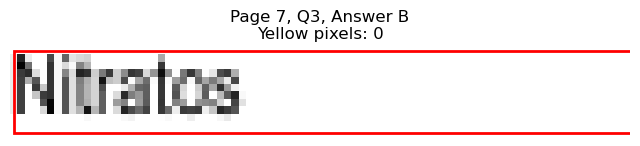

Page 7, Q3 - C: Detected box: x0=327.5, y0=280.5, x1=449.4, y1=291.6
Page 7, Q3, C: Yellow pixels: 0
Page 7, Q3, C: Total non-white pixels: 663
Page 7, Q3, C: Yellow percentage: 0.0%


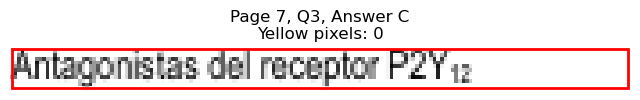

Page 7, Q3 - D: Detected box: x0=327.5, y0=293.1, x1=412.7, y1=304.2
Page 7, Q3, D: Yellow pixels: 0
Page 7, Q3, D: Total non-white pixels: 447
Page 7, Q3, D: Yellow percentage: 0.0%


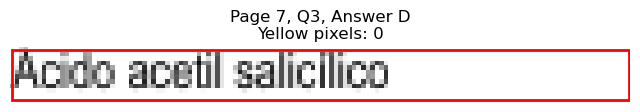


Page 7, Q3 - Selected Answer: A (based on yellow pixel count)




Page 7, Q4 - A: Detected box: x0=68.3, y0=343.6, x1=139.0, y1=354.7
Page 7, Q4, A: Yellow pixels: 0
Page 7, Q4, A: Total non-white pixels: 348
Page 7, Q4, A: Yellow percentage: 0.0%


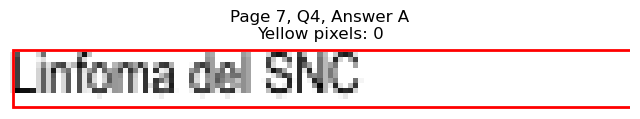

Page 7, Q4 - B: Detected box: x0=68.3, y0=356.2, x1=119.4, y1=367.3
Page 7, Q4, B: Yellow pixels: 0
Page 7, Q4, B: Total non-white pixels: 288
Page 7, Q4, B: Yellow percentage: 0.0%


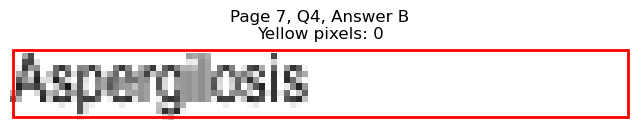

Page 7, Q4 - C: Detected box: x0=327.5, y0=343.6, x1=390.1, y1=354.7
Page 7, Q4, C: Yellow pixels: 1141
Page 7, Q4, C: Total non-white pixels: 1368
Page 7, Q4, C: Yellow percentage: 83.4%


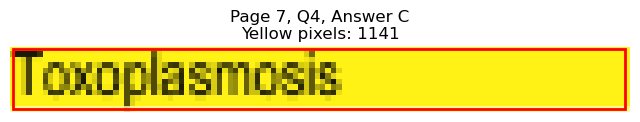

Page 7, Q4 - D: Detected box: x0=327.5, y0=356.2, x1=394.7, y1=367.3
Page 7, Q4, D: Yellow pixels: 0
Page 7, Q4, D: Total non-white pixels: 364
Page 7, Q4, D: Yellow percentage: 0.0%


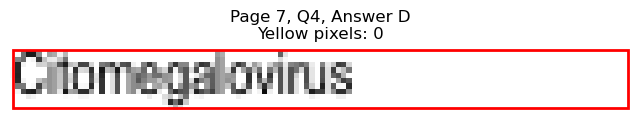


Page 7, Q4 - Selected Answer: C (based on yellow pixel count)




Page 7, Q5 - A: Detected box: x0=68.3, y0=406.6, x1=138.1, y1=417.7
Page 7, Q5, A: Yellow pixels: 0
Page 7, Q5, A: Total non-white pixels: 365
Page 7, Q5, A: Yellow percentage: 0.0%


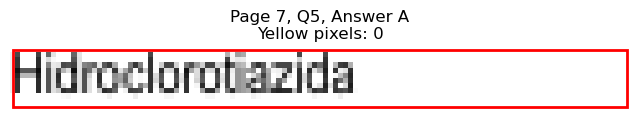

Page 7, Q5 - B: Detected box: x0=68.3, y0=419.4, x1=202.2, y1=430.4
Page 7, Q5, B: Yellow pixels: 0
Page 7, Q5, B: Total non-white pixels: 658
Page 7, Q5, B: Yellow percentage: 0.0%


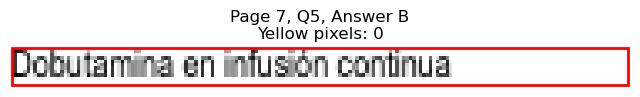

Page 7, Q5 - C: Detected box: x0=327.5, y0=406.6, x1=412.8, y1=417.7
Page 7, Q5, C: Yellow pixels: 136
Page 7, Q5, C: Total non-white pixels: 560
Page 7, Q5, C: Yellow percentage: 24.3%


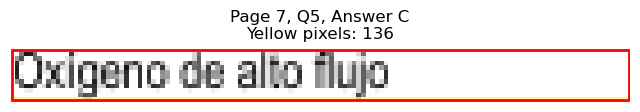

Page 7, Q5 - D: Detected box: x0=327.5, y0=419.4, x1=419.3, y1=430.4
Page 7, Q5, D: Yellow pixels: 1234
Page 7, Q5, D: Total non-white pixels: 1716
Page 7, Q5, D: Yellow percentage: 71.9%


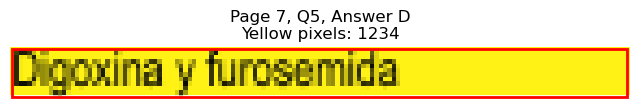


Page 7, Q5 - Selected Answer: D (based on yellow pixel count)




Page 7, Q6 - A: Detected box: x0=68.3, y0=482.5, x1=136.0, y1=493.5
Page 7, Q6, A: Yellow pixels: 118
Page 7, Q6, A: Total non-white pixels: 473
Page 7, Q6, A: Yellow percentage: 24.9%


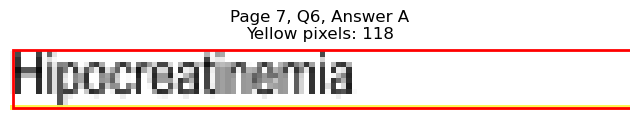

Page 7, Q6 - B: Detected box: x0=68.3, y0=495.1, x1=124.4, y1=506.1
Page 7, Q6, B: Yellow pixels: 949
Page 7, Q6, B: Total non-white pixels: 1179
Page 7, Q6, B: Yellow percentage: 80.5%


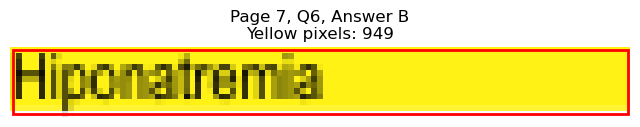

Page 7, Q6 - C: Detected box: x0=327.5, y0=482.5, x1=384.6, y1=493.5
Page 7, Q6, C: Yellow pixels: 0
Page 7, Q6, C: Total non-white pixels: 326
Page 7, Q6, C: Yellow percentage: 0.0%


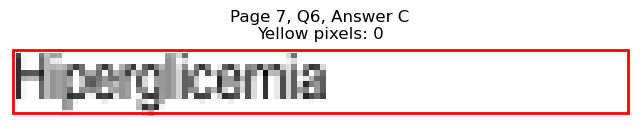

Page 7, Q6 - D: Detected box: x0=327.5, y0=495.1, x1=390.1, y1=506.1
Page 7, Q6, D: Yellow pixels: 0
Page 7, Q6, D: Total non-white pixels: 344
Page 7, Q6, D: Yellow percentage: 0.0%


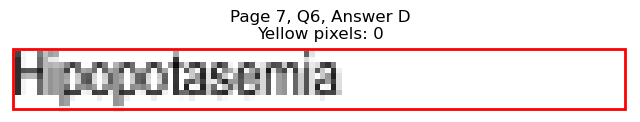


Page 7, Q6 - Selected Answer: B (based on yellow pixel count)




Page 7, Q7 - A: Detected box: x0=68.3, y0=545.5, x1=80.9, y1=556.5
Page 7, Q7, A: Yellow pixels: 63
Page 7, Q7, A: Total non-white pixels: 99
Page 7, Q7, A: Yellow percentage: 63.6%


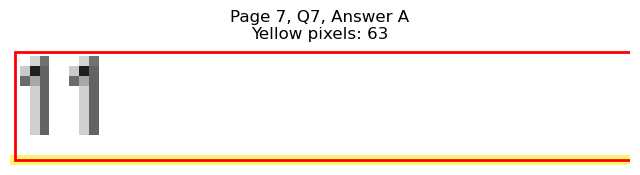

Page 7, Q7 - B: Detected box: x0=68.3, y0=558.2, x1=88.3, y1=569.2
Page 7, Q7, B: Yellow pixels: 715
Page 7, Q7, B: Total non-white pixels: 781
Page 7, Q7, B: Yellow percentage: 91.5%


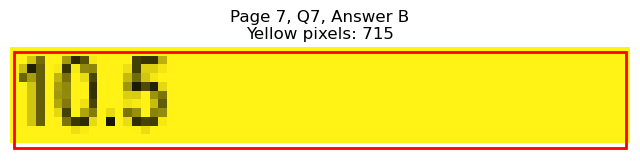

Page 7, Q7 - C: Detected box: x0=327.5, y0=545.5, x1=342.6, y1=556.5
Page 7, Q7, C: Yellow pixels: 0
Page 7, Q7, C: Total non-white pixels: 75
Page 7, Q7, C: Yellow percentage: 0.0%


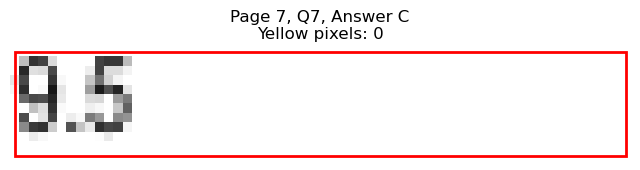

Page 7, Q7 - D: Detected box: x0=327.5, y0=558.2, x1=340.1, y1=569.2
Page 7, Q7, D: Yellow pixels: 0
Page 7, Q7, D: Total non-white pixels: 45
Page 7, Q7, D: Yellow percentage: 0.0%


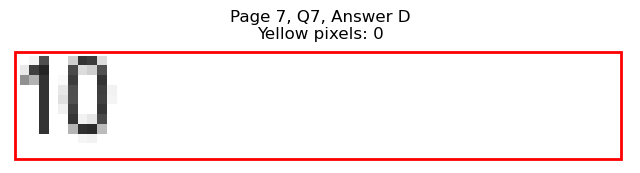


Page 7, Q7 - Selected Answer: B (based on yellow pixel count)




Page 7, Q8 - A: Detected box: x0=68.3, y0=633.9, x1=104.9, y1=645.0
Page 7, Q8, A: Yellow pixels: 918
Page 7, Q8, A: Total non-white pixels: 1044
Page 7, Q8, A: Yellow percentage: 87.9%


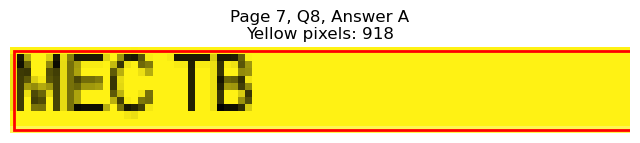

Page 7, Q8 - B: Detected box: x0=68.3, y0=646.5, x1=131.0, y1=657.6
Page 7, Q8, B: Yellow pixels: 0
Page 7, Q8, B: Total non-white pixels: 307
Page 7, Q8, B: Yellow percentage: 0.0%


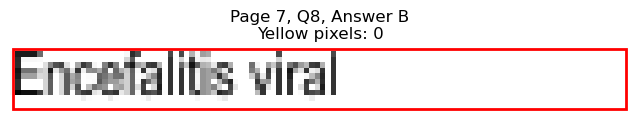

Page 7, Q8 - C: Detected box: x0=327.5, y0=633.9, x1=420.7, y1=645.0
Page 7, Q8, C: Yellow pixels: 0
Page 7, Q8, C: Total non-white pixels: 474
Page 7, Q8, C: Yellow percentage: 0.0%


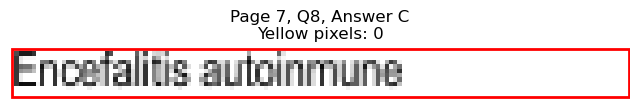

Page 7, Q8 - D: Detected box: x0=327.5, y0=646.5, x1=394.7, y1=657.6
Page 7, Q8, D: Yellow pixels: 0
Page 7, Q8, D: Total non-white pixels: 357
Page 7, Q8, D: Yellow percentage: 0.0%


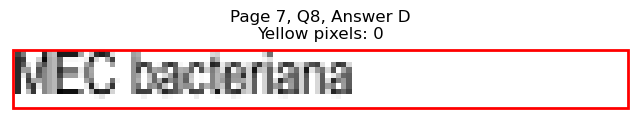


Page 7, Q8 - Selected Answer: A (based on yellow pixel count)




Page 7, Q9 - A: Detected box: x0=68.3, y0=709.6, x1=173.0, y1=720.7
Page 7, Q9, A: Yellow pixels: 156
Page 7, Q9, A: Total non-white pixels: 684
Page 7, Q9, A: Yellow percentage: 22.8%


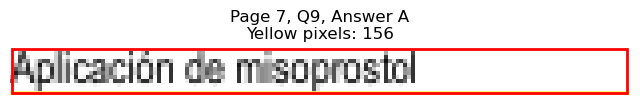

Page 7, Q9 - B: Detected box: x0=68.3, y0=722.2, x1=180.1, y1=733.3
Page 7, Q9, B: Yellow pixels: 1391
Page 7, Q9, B: Total non-white pixels: 1956
Page 7, Q9, B: Yellow percentage: 71.1%


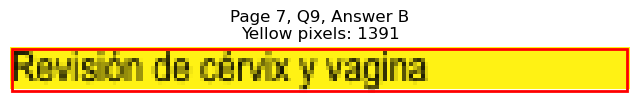

Page 7, Q9 - C: Detected box: x0=327.5, y0=709.6, x1=389.2, y1=720.7
Page 7, Q9, C: Yellow pixels: 0
Page 7, Q9, C: Total non-white pixels: 322
Page 7, Q9, C: Yellow percentage: 0.0%


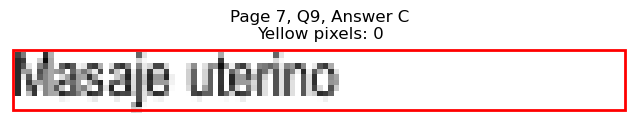

Page 7, Q9 - D: Detected box: x0=327.5, y0=722.2, x1=428.3, y1=733.3
Page 7, Q9, D: Yellow pixels: 0
Page 7, Q9, D: Total non-white pixels: 488
Page 7, Q9, D: Yellow percentage: 0.0%


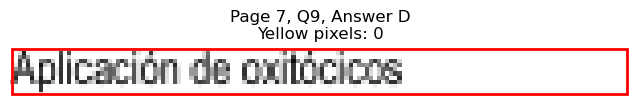


Page 7, Q9 - Selected Answer: B (based on yellow pixel count)





Page 8: Found 8 questions
Page 8, Q1 - A: Detected box: x0=68.3, y0=116.4, x1=121.9, y1=127.4
Page 8, Q1, A: Yellow pixels: 0
Page 8, Q1, A: Total non-white pixels: 273
Page 8, Q1, A: Yellow percentage: 0.0%


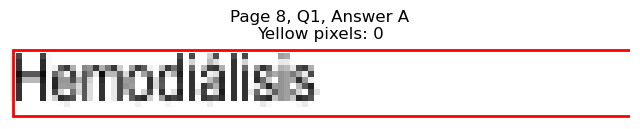

Page 8, Q1 - B: Detected box: x0=68.3, y0=129.0, x1=159.6, y1=140.0
Page 8, Q1, B: Yellow pixels: 0
Page 8, Q1, B: Total non-white pixels: 467
Page 8, Q1, B: Yellow percentage: 0.0%


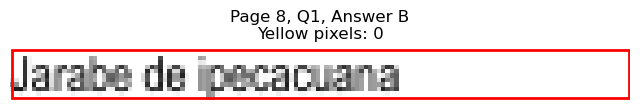

Page 8, Q1 - C: Detected box: x0=327.5, y0=116.4, x1=427.3, y1=127.4
Page 8, Q1, C: Yellow pixels: 1261
Page 8, Q1, C: Total non-white pixels: 1812
Page 8, Q1, C: Yellow percentage: 69.6%


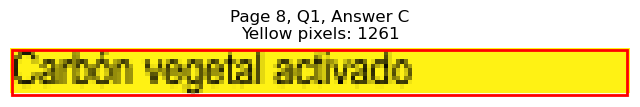

Page 8, Q1 - D: Detected box: x0=327.5, y0=129.0, x1=393.7, y1=140.0
Page 8, Q1, D: Yellow pixels: 0
Page 8, Q1, D: Total non-white pixels: 318
Page 8, Q1, D: Yellow percentage: 0.0%


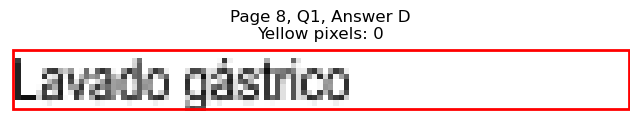


Page 8, Q1 - Selected Answer: C (based on yellow pixel count)




Page 8, Q2 - A: Detected box: x0=68.3, y0=204.7, x1=157.1, y1=215.7
Page 8, Q2, A: Yellow pixels: 0
Page 8, Q2, A: Total non-white pixels: 586
Page 8, Q2, A: Yellow percentage: 0.0%


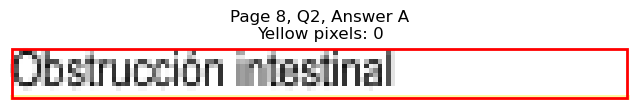

Page 8, Q2 - B: Detected box: x0=68.3, y0=217.4, x1=171.6, y1=228.4
Page 8, Q2, B: Yellow pixels: 1289
Page 8, Q2, B: Total non-white pixels: 1848
Page 8, Q2, B: Yellow percentage: 69.8%


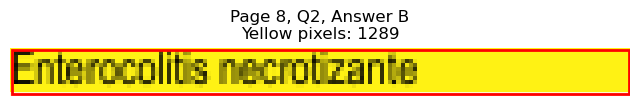

Page 8, Q2 - C: Detected box: x0=327.5, y0=204.7, x1=394.3, y1=215.7
Page 8, Q2, C: Yellow pixels: 0
Page 8, Q2, C: Total non-white pixels: 347
Page 8, Q2, C: Yellow percentage: 0.0%


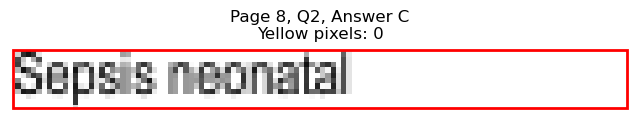

Page 8, Q2 - D: Detected box: x0=327.5, y0=217.4, x1=388.7, y1=228.4
Page 8, Q2, D: Yellow pixels: 0
Page 8, Q2, D: Total non-white pixels: 331
Page 8, Q2, D: Yellow percentage: 0.0%


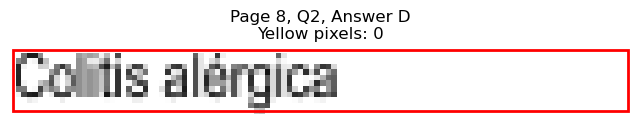


Page 8, Q2 - Selected Answer: B (based on yellow pixel count)




Page 8, Q3 - A: Detected box: x0=68.3, y0=267.8, x1=184.1, y1=278.8
Page 8, Q3, A: Yellow pixels: 0
Page 8, Q3, A: Total non-white pixels: 751
Page 8, Q3, A: Yellow percentage: 0.0%


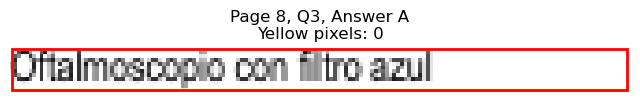

Page 8, Q3 - B: Detected box: x0=68.3, y0=280.5, x1=149.0, y1=291.6
Page 8, Q3, B: Yellow pixels: 1125
Page 8, Q3, B: Total non-white pixels: 1584
Page 8, Q3, B: Yellow percentage: 71.0%


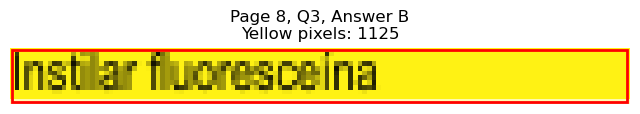

Page 8, Q3 - C: Detected box: x0=327.5, y0=267.8, x1=404.2, y1=278.8
Page 8, Q3, C: Yellow pixels: 0
Page 8, Q3, C: Total non-white pixels: 367
Page 8, Q3, C: Yellow percentage: 0.0%


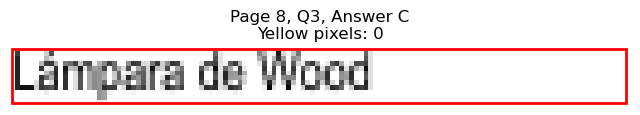

Page 8, Q3 - D: Detected box: x0=327.5, y0=280.5, x1=420.7, y1=291.6
Page 8, Q3, D: Yellow pixels: 0
Page 8, Q3, D: Total non-white pixels: 461
Page 8, Q3, D: Yellow percentage: 0.0%


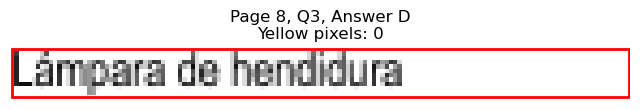


Page 8, Q3 - Selected Answer: B (based on yellow pixel count)




Page 8, Q4 - A: Detected box: x0=68.3, y0=330.9, x1=152.0, y1=342.0
Page 8, Q4, A: Yellow pixels: 0
Page 8, Q4, A: Total non-white pixels: 409
Page 8, Q4, A: Yellow percentage: 0.0%


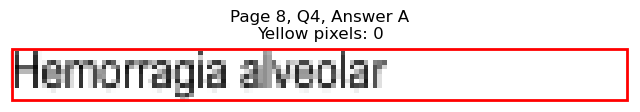

Page 8, Q4 - B: Detected box: x0=68.3, y0=343.6, x1=193.2, y1=354.7
Page 8, Q4, B: Yellow pixels: 0
Page 8, Q4, B: Total non-white pixels: 625
Page 8, Q4, B: Yellow percentage: 0.0%


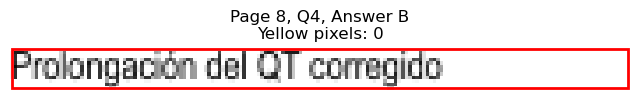

Page 8, Q4 - C: Detected box: x0=327.5, y0=330.9, x1=409.2, y1=342.0
Page 8, Q4, C: Yellow pixels: 1266
Page 8, Q4, C: Total non-white pixels: 1596
Page 8, Q4, C: Yellow percentage: 79.3%


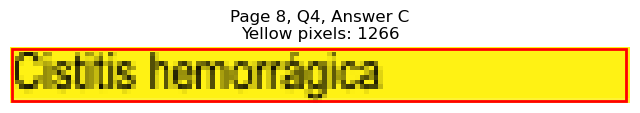

Page 8, Q4 - D: Detected box: x0=327.5, y0=343.6, x1=434.3, y1=354.7
Page 8, Q4, D: Yellow pixels: 0
Page 8, Q4, D: Total non-white pixels: 543
Page 8, Q4, D: Yellow percentage: 0.0%


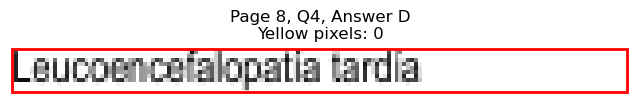


Page 8, Q4 - Selected Answer: C (based on yellow pixel count)




Page 8, Q5 - A: Detected box: x0=68.3, y0=406.6, x1=89.9, y1=417.7
Page 8, Q5, A: Yellow pixels: 0
Page 8, Q5, A: Total non-white pixels: 112
Page 8, Q5, A: Yellow percentage: 0.0%


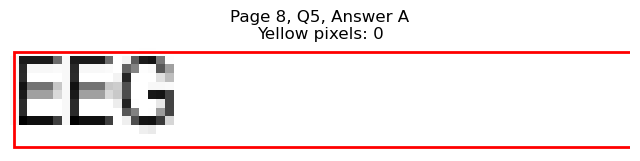

Page 8, Q5 - B: Detected box: x0=68.3, y0=419.4, x1=162.6, y1=430.4
Page 8, Q5, B: Yellow pixels: 0
Page 8, Q5, B: Total non-white pixels: 474
Page 8, Q5, B: Yellow percentage: 0.0%


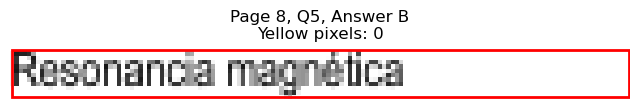

Page 8, Q5 - C: Detected box: x0=327.5, y0=406.6, x1=382.7, y1=417.7
Page 8, Q5, C: Yellow pixels: 1074
Page 8, Q5, C: Total non-white pixels: 1272
Page 8, Q5, C: Yellow percentage: 84.4%


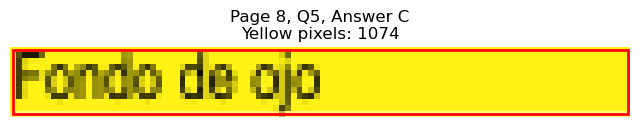

Page 8, Q5 - D: Detected box: x0=327.5, y0=419.4, x1=413.8, y1=430.4
Page 8, Q5, D: Yellow pixels: 0
Page 8, Q5, D: Total non-white pixels: 449
Page 8, Q5, D: Yellow percentage: 0.0%


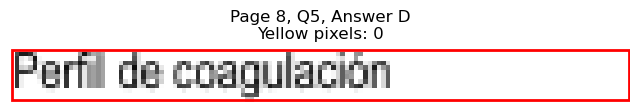


Page 8, Q5 - Selected Answer: C (based on yellow pixel count)




Page 8, Q6 - A: Detected box: x0=68.3, y0=482.5, x1=215.6, y1=493.5
Page 8, Q6, A: Yellow pixels: 0
Page 8, Q6, A: Total non-white pixels: 715
Page 8, Q6, A: Yellow percentage: 0.0%


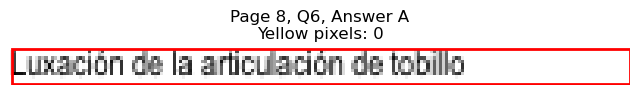

Page 8, Q6 - B: Detected box: x0=68.3, y0=495.1, x1=156.6, y1=506.1
Page 8, Q6, B: Yellow pixels: 0
Page 8, Q6, B: Total non-white pixels: 456
Page 8, Q6, B: Yellow percentage: 0.0%


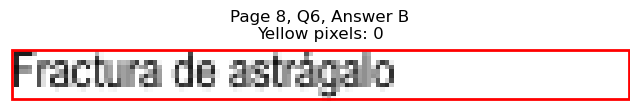

Page 8, Q6 - C: Detected box: x0=327.5, y0=482.5, x1=446.4, y1=493.5
Page 8, Q6, C: Yellow pixels: 1424
Page 8, Q6, C: Total non-white pixels: 2040
Page 8, Q6, C: Yellow percentage: 69.8%


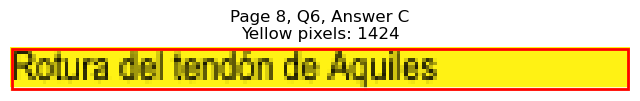

Page 8, Q6 - D: Detected box: x0=327.5, y0=495.1, x1=416.8, y1=506.1
Page 8, Q6, D: Yellow pixels: 0
Page 8, Q6, D: Total non-white pixels: 454
Page 8, Q6, D: Yellow percentage: 0.0%


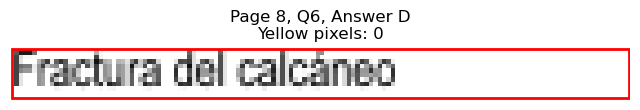


Page 8, Q6 - Selected Answer: C (based on yellow pixel count)




Page 8, Q7 - A: Detected box: x0=68.3, y0=570.8, x1=188.6, y1=581.8
Page 8, Q7, A: Yellow pixels: 0
Page 8, Q7, A: Total non-white pixels: 571
Page 8, Q7, A: Yellow percentage: 0.0%


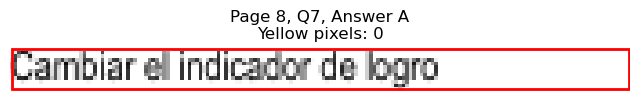

Page 8, Q7 - B: Detected box: x0=68.3, y0=583.4, x1=226.2, y1=594.4
Page 8, Q7, B: Yellow pixels: 209
Page 8, Q7, B: Total non-white pixels: 1015
Page 8, Q7, B: Yellow percentage: 20.6%


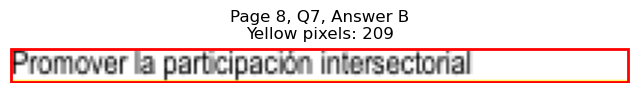

Page 8, Q7 - C: Detected box: x0=68.8, y0=596.0, x1=263.3, y1=607.0
Page 8, Q7, C: Yellow pixels: 2194
Page 8, Q7, C: Total non-white pixels: 2960
Page 8, Q7, C: Yellow percentage: 74.1%


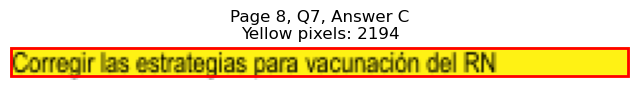

Page 8, Q7 - D: Detected box: x0=68.8, y0=608.6, x1=309.5, y1=619.6
Page 8, Q7, D: Yellow pixels: 0
Page 8, Q7, D: Total non-white pixels: 1161
Page 8, Q7, D: Yellow percentage: 0.0%


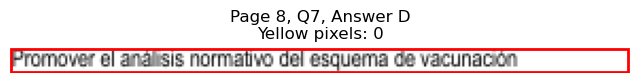


Page 8, Q7 - Selected Answer: C (based on yellow pixel count)




Page 8, Q8 - A: Detected box: x0=68.3, y0=671.7, x1=149.0, y1=682.8
Page 8, Q8, A: Yellow pixels: 132
Page 8, Q8, A: Total non-white pixels: 521
Page 8, Q8, A: Yellow percentage: 25.3%


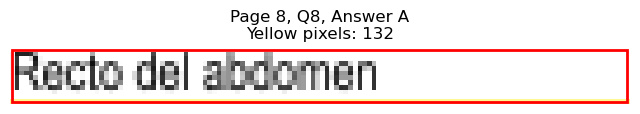

Page 8, Q8 - B: Detected box: x0=68.3, y0=684.3, x1=158.5, y1=695.4
Page 8, Q8, B: Yellow pixels: 1227
Page 8, Q8, B: Total non-white pixels: 1692
Page 8, Q8, B: Yellow percentage: 72.5%


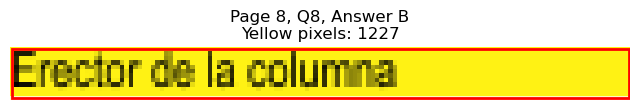

Page 8, Q8 - C: Detected box: x0=327.5, y0=671.7, x1=422.3, y1=682.8
Page 8, Q8, C: Yellow pixels: 0
Page 8, Q8, C: Total non-white pixels: 479
Page 8, Q8, C: Yellow percentage: 0.0%


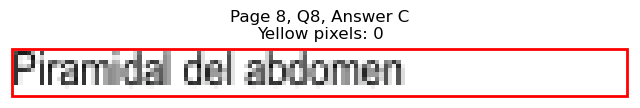

Page 8, Q8 - D: Detected box: x0=327.5, y0=684.3, x1=390.7, y1=695.4
Page 8, Q8, D: Yellow pixels: 0
Page 8, Q8, D: Total non-white pixels: 317
Page 8, Q8, D: Yellow percentage: 0.0%


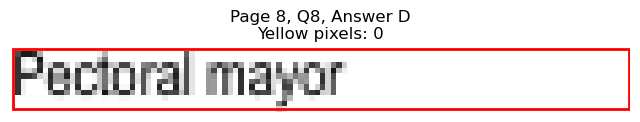


Page 8, Q8 - Selected Answer: B (based on yellow pixel count)





Page 9: Found 9 questions
Page 9, Q1 - A: Detected box: x0=68.3, y0=129.0, x1=127.4, y1=140.0
Page 9, Q1, A: Yellow pixels: 0
Page 9, Q1, A: Total non-white pixels: 314
Page 9, Q1, A: Yellow percentage: 0.0%


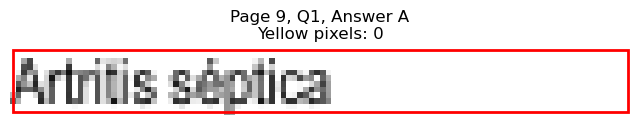

Page 9, Q1 - B: Detected box: x0=68.3, y0=141.7, x1=138.5, y1=152.7
Page 9, Q1, B: Yellow pixels: 0
Page 9, Q1, B: Total non-white pixels: 342
Page 9, Q1, B: Yellow percentage: 0.0%


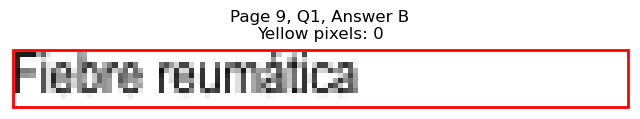

Page 9, Q1 - C: Detected box: x0=327.5, y0=129.0, x1=389.6, y1=140.0
Page 9, Q1, C: Yellow pixels: 1120
Page 9, Q1, C: Total non-white pixels: 1356
Page 9, Q1, C: Yellow percentage: 82.6%


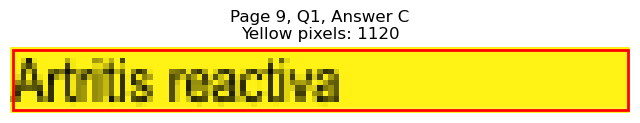

Page 9, Q1 - D: Detected box: x0=327.5, y0=141.7, x1=433.3, y1=152.7
Page 9, Q1, D: Yellow pixels: 0
Page 9, Q1, D: Total non-white pixels: 555
Page 9, Q1, D: Yellow percentage: 0.0%


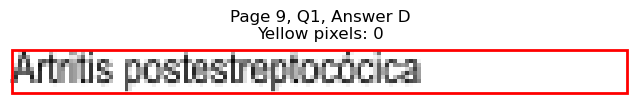


Page 9, Q1 - Selected Answer: C (based on yellow pixel count)




Page 9, Q2 - A: Detected box: x0=68.3, y0=204.7, x1=136.6, y1=215.7
Page 9, Q2, A: Yellow pixels: 1176
Page 9, Q2, A: Total non-white pixels: 1428
Page 9, Q2, A: Yellow percentage: 82.4%


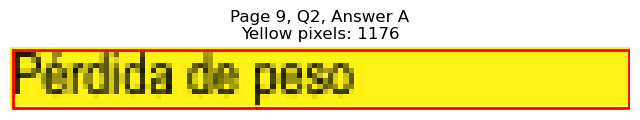

Page 9, Q2 - B: Detected box: x0=68.3, y0=217.4, x1=156.0, y1=228.4
Page 9, Q2, B: Yellow pixels: 0
Page 9, Q2, B: Total non-white pixels: 453
Page 9, Q2, B: Yellow percentage: 0.0%


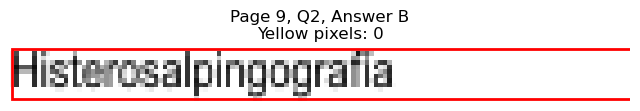

Page 9, Q2 - C: Detected box: x0=327.5, y0=204.7, x1=432.8, y1=215.7
Page 9, Q2, C: Yellow pixels: 0
Page 9, Q2, C: Total non-white pixels: 547
Page 9, Q2, C: Yellow percentage: 0.0%


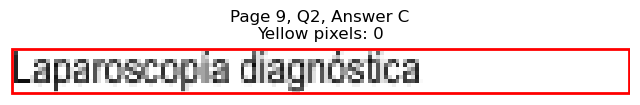

Page 9, Q2 - D: Detected box: x0=327.5, y0=217.4, x1=410.3, y1=228.4
Page 9, Q2, D: Yellow pixels: 0
Page 9, Q2, D: Total non-white pixels: 412
Page 9, Q2, D: Yellow percentage: 0.0%


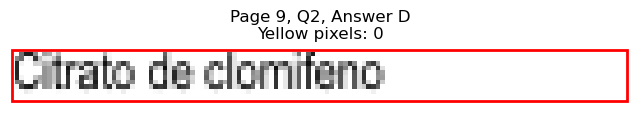


Page 9, Q2 - Selected Answer: A (based on yellow pixel count)




Page 9, Q3 - A: Detected box: x0=68.3, y0=267.8, x1=151.6, y1=278.8
Page 9, Q3, A: Yellow pixels: 0
Page 9, Q3, A: Total non-white pixels: 426
Page 9, Q3, A: Yellow percentage: 0.0%


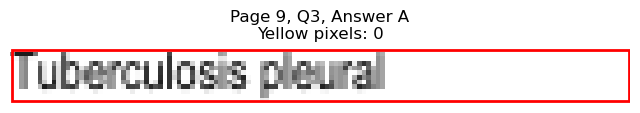

Page 9, Q3 - B: Detected box: x0=68.3, y0=280.5, x1=170.5, y1=291.6
Page 9, Q3, B: Yellow pixels: 0
Page 9, Q3, B: Total non-white pixels: 504
Page 9, Q3, B: Yellow percentage: 0.0%


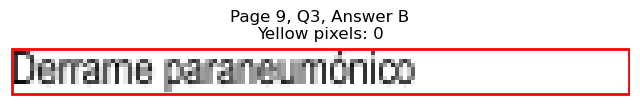

Page 9, Q3 - C: Detected box: x0=327.5, y0=267.8, x1=381.1, y1=278.8
Page 9, Q3, C: Yellow pixels: 1027
Page 9, Q3, C: Total non-white pixels: 1260
Page 9, Q3, C: Yellow percentage: 81.5%


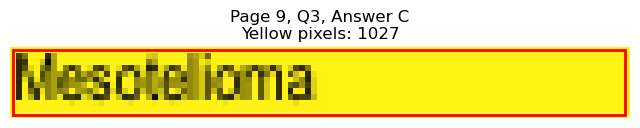

Page 9, Q3 - D: Detected box: x0=327.5, y0=280.5, x1=397.8, y1=291.6
Page 9, Q3, D: Yellow pixels: 0
Page 9, Q3, D: Total non-white pixels: 343
Page 9, Q3, D: Yellow percentage: 0.0%


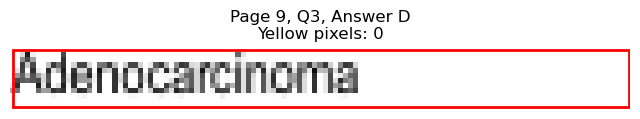


Page 9, Q3 - Selected Answer: C (based on yellow pixel count)




Page 9, Q4 - A: Detected box: x0=68.3, y0=330.9, x1=144.0, y1=342.0
Page 9, Q4, A: Yellow pixels: 1237
Page 9, Q4, A: Total non-white pixels: 1512
Page 9, Q4, A: Yellow percentage: 81.8%


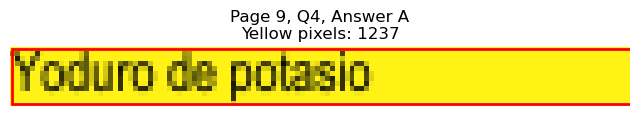

Page 9, Q4 - B: Detected box: x0=68.3, y0=343.6, x1=112.0, y1=354.7
Page 9, Q4, B: Yellow pixels: 0
Page 9, Q4, B: Total non-white pixels: 230
Page 9, Q4, B: Yellow percentage: 0.0%


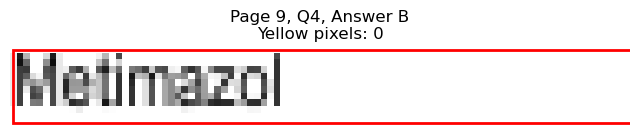

Page 9, Q4 - C: Detected box: x0=327.5, y0=330.9, x1=389.2, y1=342.0
Page 9, Q4, C: Yellow pixels: 0
Page 9, Q4, C: Total non-white pixels: 318
Page 9, Q4, C: Yellow percentage: 0.0%


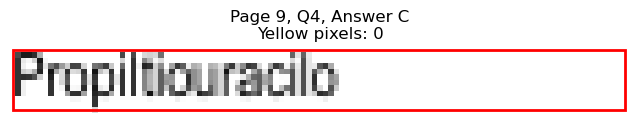

Page 9, Q4 - D: Detected box: x0=327.5, y0=343.6, x1=388.2, y1=354.7
Page 9, Q4, D: Yellow pixels: 0
Page 9, Q4, D: Total non-white pixels: 322
Page 9, Q4, D: Yellow percentage: 0.0%


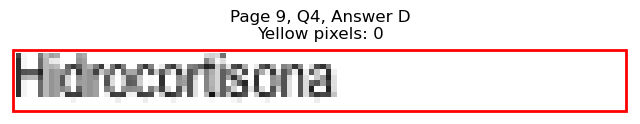


Page 9, Q4 - Selected Answer: A (based on yellow pixel count)




Page 9, Q5 - A: Detected box: x0=68.3, y0=381.4, x1=103.9, y1=392.5
Page 9, Q5, A: Yellow pixels: 0
Page 9, Q5, A: Total non-white pixels: 165
Page 9, Q5, A: Yellow percentage: 0.0%


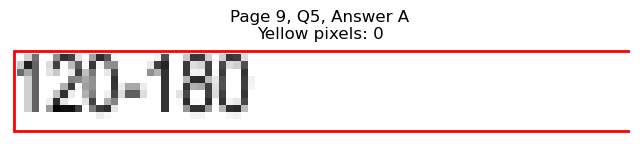

Page 9, Q5 - B: Detected box: x0=68.3, y0=394.0, x1=103.9, y1=405.1
Page 9, Q5, B: Yellow pixels: 0
Page 9, Q5, B: Total non-white pixels: 202
Page 9, Q5, B: Yellow percentage: 0.0%


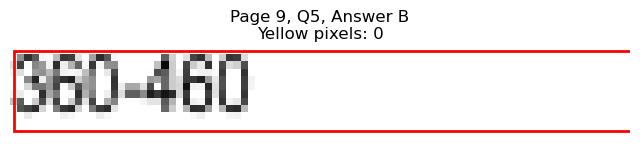

Page 9, Q5 - C: Detected box: x0=327.5, y0=381.4, x1=353.0, y1=392.5
Page 9, Q5, C: Yellow pixels: 757
Page 9, Q5, C: Total non-white pixels: 924
Page 9, Q5, C: Yellow percentage: 81.9%


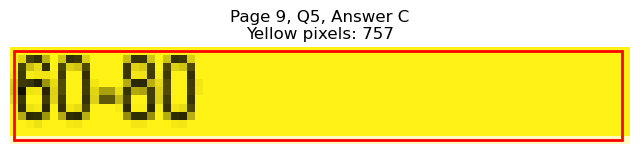

Page 9, Q5 - D: Detected box: x0=327.5, y0=394.0, x1=363.1, y1=405.1
Page 9, Q5, D: Yellow pixels: 0
Page 9, Q5, D: Total non-white pixels: 178
Page 9, Q5, D: Yellow percentage: 0.0%


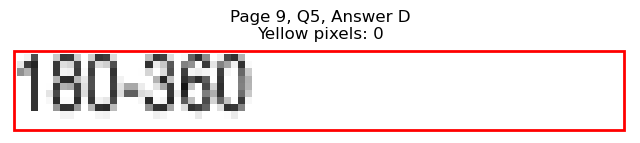


Page 9, Q5 - Selected Answer: C (based on yellow pixel count)




Page 9, Q6 - A: Detected box: x0=68.3, y0=457.2, x1=155.0, y1=468.2
Page 9, Q6, A: Yellow pixels: 1203
Page 9, Q6, A: Total non-white pixels: 1519
Page 9, Q6, A: Yellow percentage: 79.2%


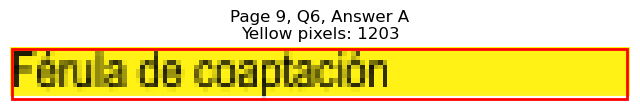

Page 9, Q6 - B: Detected box: x0=68.3, y0=469.8, x1=159.6, y1=480.8
Page 9, Q6, B: Yellow pixels: 0
Page 9, Q6, B: Total non-white pixels: 463
Page 9, Q6, B: Yellow percentage: 0.0%


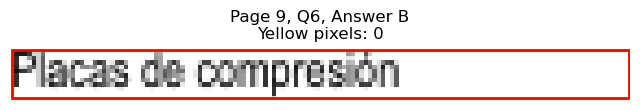

Page 9, Q6 - C: Detected box: x0=327.5, y0=457.2, x1=393.7, y1=468.2
Page 9, Q6, C: Yellow pixels: 0
Page 9, Q6, C: Total non-white pixels: 350
Page 9, Q6, C: Yellow percentage: 0.0%


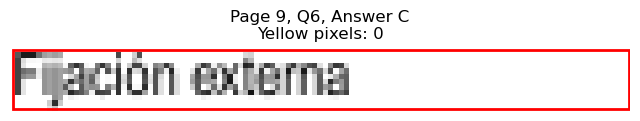

Page 9, Q6 - D: Detected box: x0=327.5, y0=469.8, x1=397.2, y1=480.8
Page 9, Q6, D: Yellow pixels: 0
Page 9, Q6, D: Total non-white pixels: 357
Page 9, Q6, D: Yellow percentage: 0.0%


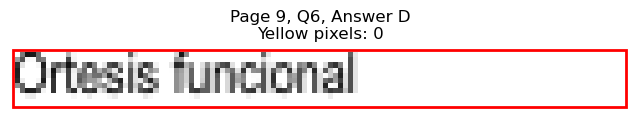


Page 9, Q6 - Selected Answer: A (based on yellow pixel count)




Page 9, Q7 - A: Detected box: x0=68.3, y0=545.5, x1=169.3, y1=556.5
Page 9, Q7, A: Yellow pixels: 0
Page 9, Q7, A: Total non-white pixels: 493
Page 9, Q7, A: Yellow percentage: 0.0%


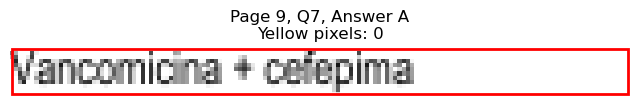

Page 9, Q7 - B: Detected box: x0=68.3, y0=558.2, x1=179.4, y1=569.2
Page 9, Q7, B: Yellow pixels: 0
Page 9, Q7, B: Total non-white pixels: 542
Page 9, Q7, B: Yellow percentage: 0.0%


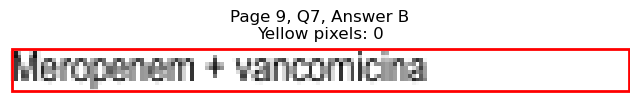

Page 9, Q7 - C: Detected box: x0=327.5, y0=545.5, x1=425.0, y1=556.5
Page 9, Q7, C: Yellow pixels: 1273
Page 9, Q7, C: Total non-white pixels: 1788
Page 9, Q7, C: Yellow percentage: 71.2%


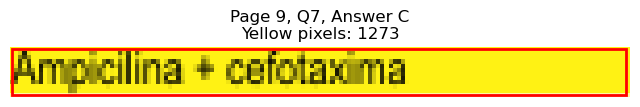

Page 9, Q7 - D: Detected box: x0=327.5, y0=558.2, x1=430.1, y1=569.2
Page 9, Q7, D: Yellow pixels: 0
Page 9, Q7, D: Total non-white pixels: 510
Page 9, Q7, D: Yellow percentage: 0.0%


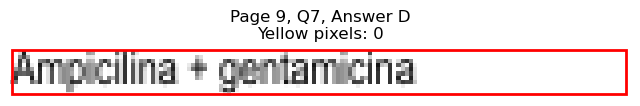


Page 9, Q7 - Selected Answer: C (based on yellow pixel count)




Page 9, Q8 - A: Detected box: x0=68.3, y0=608.6, x1=137.5, y1=619.6
Page 9, Q8, A: Yellow pixels: 1152
Page 9, Q8, A: Total non-white pixels: 1440
Page 9, Q8, A: Yellow percentage: 80.0%


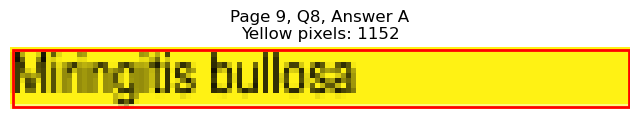

Page 9, Q8 - B: Detected box: x0=68.3, y0=621.3, x1=120.5, y1=632.4
Page 9, Q8, B: Yellow pixels: 0
Page 9, Q8, B: Total non-white pixels: 283
Page 9, Q8, B: Yellow percentage: 0.0%


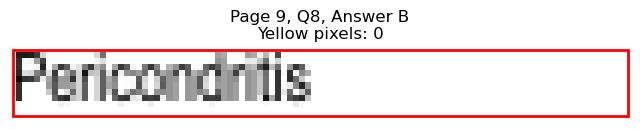

Page 9, Q8 - C: Detected box: x0=327.5, y0=608.6, x1=417.2, y1=619.6
Page 9, Q8, C: Yellow pixels: 0
Page 9, Q8, C: Total non-white pixels: 473
Page 9, Q8, C: Yellow percentage: 0.0%


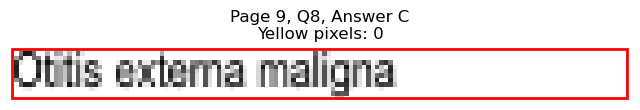

Page 9, Q8 - D: Detected box: x0=327.5, y0=621.3, x1=374.6, y1=632.4
Page 9, Q8, D: Yellow pixels: 0
Page 9, Q8, D: Total non-white pixels: 241
Page 9, Q8, D: Yellow percentage: 0.0%


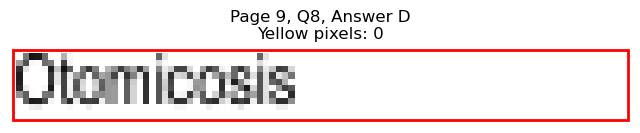


Page 9, Q8 - Selected Answer: A (based on yellow pixel count)




Page 9, Q9 - A: Detected box: x0=68.3, y0=671.7, x1=245.8, y1=682.8
Page 9, Q9, A: Yellow pixels: 1866
Page 9, Q9, A: Total non-white pixels: 2568
Page 9, Q9, A: Yellow percentage: 72.7%


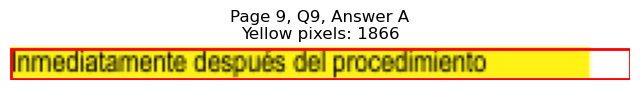

Page 9, Q9 - B: Detected box: x0=68.3, y0=684.3, x1=232.3, y1=695.4
Page 9, Q9, B: Yellow pixels: 0
Page 9, Q9, B: Total non-white pixels: 835
Page 9, Q9, B: Yellow percentage: 0.0%


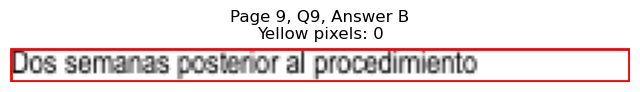

Page 9, Q9 - C: Detected box: x0=327.5, y0=671.7, x1=453.4, y1=682.8
Page 9, Q9, C: Yellow pixels: 0
Page 9, Q9, C: Total non-white pixels: 586
Page 9, Q9, C: Yellow percentage: 0.0%


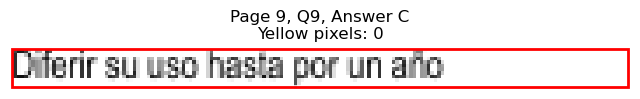

Page 9, Q9 - D: Detected box: x0=327.5, y0=684.3, x1=477.0, y1=695.4
Page 9, Q9, D: Yellow pixels: 0
Page 9, Q9, D: Total non-white pixels: 694
Page 9, Q9, D: Yellow percentage: 0.0%


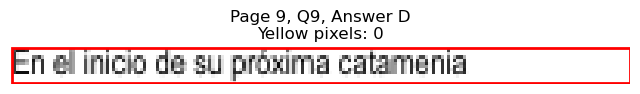


Page 9, Q9 - Selected Answer: A (based on yellow pixel count)





Page 10: Found 9 questions
Page 10, Q1 - A: Detected box: x0=68.3, y0=129.0, x1=157.1, y1=140.0
Page 10, Q1, A: Yellow pixels: 0
Page 10, Q1, A: Total non-white pixels: 588
Page 10, Q1, A: Yellow percentage: 0.0%


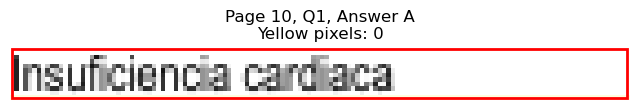

Page 10, Q1 - B: Detected box: x0=68.3, y0=141.7, x1=149.0, y1=152.7
Page 10, Q1, B: Yellow pixels: 1258
Page 10, Q1, B: Total non-white pixels: 1584
Page 10, Q1, B: Yellow percentage: 79.4%


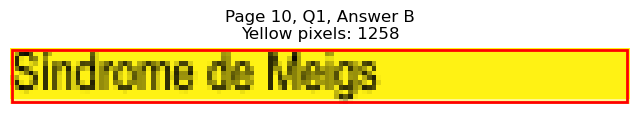

Page 10, Q1 - C: Detected box: x0=327.5, y0=129.0, x1=403.2, y1=140.0
Page 10, Q1, C: Yellow pixels: 0
Page 10, Q1, C: Total non-white pixels: 382
Page 10, Q1, C: Yellow percentage: 0.0%


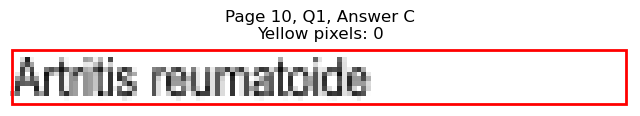

Page 10, Q1 - D: Detected box: x0=327.5, y0=141.7, x1=417.2, y1=152.7
Page 10, Q1, D: Yellow pixels: 0
Page 10, Q1, D: Total non-white pixels: 425
Page 10, Q1, D: Yellow percentage: 0.0%


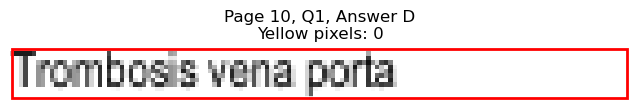


Page 10, Q1 - Selected Answer: B (based on yellow pixel count)




Page 10, Q2 - A: Detected box: x0=68.3, y0=204.7, x1=139.0, y1=215.7
Page 10, Q2, A: Yellow pixels: 0
Page 10, Q2, A: Total non-white pixels: 399
Page 10, Q2, A: Yellow percentage: 0.0%


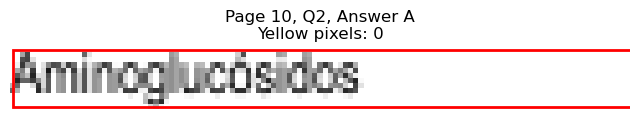

Page 10, Q2 - B: Detected box: x0=68.3, y0=217.4, x1=131.0, y1=228.4
Page 10, Q2, B: Yellow pixels: 0
Page 10, Q2, B: Total non-white pixels: 347
Page 10, Q2, B: Yellow percentage: 0.0%


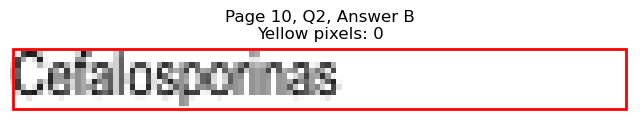

Page 10, Q2 - C: Detected box: x0=327.5, y0=204.7, x1=375.6, y1=215.7
Page 10, Q2, C: Yellow pixels: 1025
Page 10, Q2, C: Total non-white pixels: 1188
Page 10, Q2, C: Yellow percentage: 86.3%


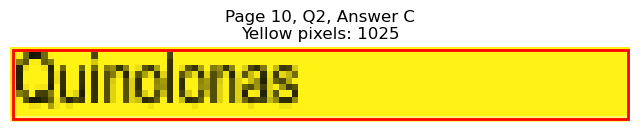

Page 10, Q2 - D: Detected box: x0=327.5, y0=217.4, x1=374.6, y1=228.4
Page 10, Q2, D: Yellow pixels: 0
Page 10, Q2, D: Total non-white pixels: 232
Page 10, Q2, D: Yellow percentage: 0.0%


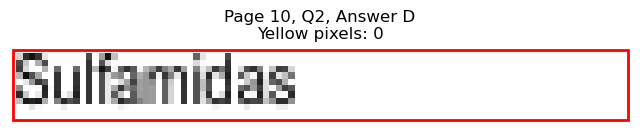


Page 10, Q2 - Selected Answer: C (based on yellow pixel count)




Page 10, Q3 - A: Detected box: x0=68.3, y0=280.5, x1=197.2, y1=291.6
Page 10, Q3, A: Yellow pixels: 180
Page 10, Q3, A: Total non-white pixels: 840
Page 10, Q3, A: Yellow percentage: 21.4%


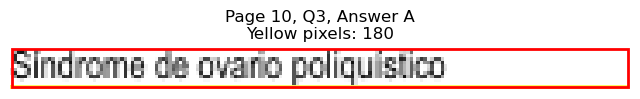

Page 10, Q3 - B: Detected box: x0=68.3, y0=293.1, x1=166.1, y1=304.2
Page 10, Q3, B: Yellow pixels: 1274
Page 10, Q3, B: Total non-white pixels: 1639
Page 10, Q3, B: Yellow percentage: 77.7%


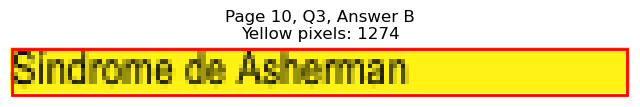

Page 10, Q3 - C: Detected box: x0=327.5, y0=280.5, x1=427.8, y1=291.6
Page 10, Q3, C: Yellow pixels: 0
Page 10, Q3, C: Total non-white pixels: 530
Page 10, Q3, C: Yellow percentage: 0.0%


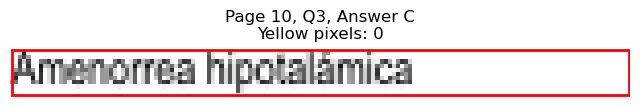

Page 10, Q3 - D: Detected box: x0=327.5, y0=293.1, x1=424.8, y1=304.2
Page 10, Q3, D: Yellow pixels: 0
Page 10, Q3, D: Total non-white pixels: 503
Page 10, Q3, D: Yellow percentage: 0.0%


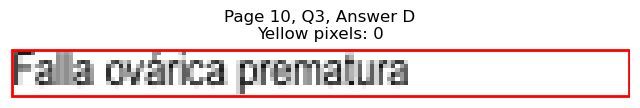


Page 10, Q3 - Selected Answer: B (based on yellow pixel count)




Page 10, Q4 - A: Detected box: x0=68.3, y0=343.6, x1=83.4, y1=354.7
Page 10, Q4, A: Yellow pixels: 0
Page 10, Q4, A: Total non-white pixels: 51
Page 10, Q4, A: Yellow percentage: 0.0%


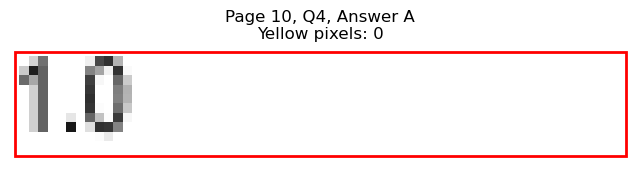

Page 10, Q4 - B: Detected box: x0=68.3, y0=356.2, x1=83.4, y1=367.3
Page 10, Q4, B: Yellow pixels: 0
Page 10, Q4, B: Total non-white pixels: 55
Page 10, Q4, B: Yellow percentage: 0.0%


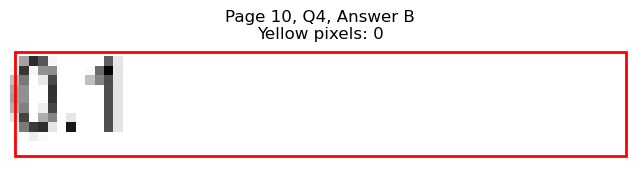

Page 10, Q4 - C: Detected box: x0=327.5, y0=343.6, x1=340.1, y1=354.7
Page 10, Q4, C: Yellow pixels: 737
Page 10, Q4, C: Total non-white pixels: 768
Page 10, Q4, C: Yellow percentage: 96.0%


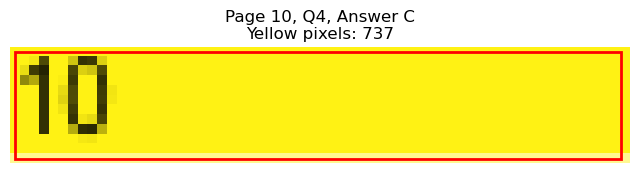

Page 10, Q4 - D: Detected box: x0=327.5, y0=356.2, x1=352.6, y1=367.3
Page 10, Q4, D: Yellow pixels: 0
Page 10, Q4, D: Total non-white pixels: 119
Page 10, Q4, D: Yellow percentage: 0.0%


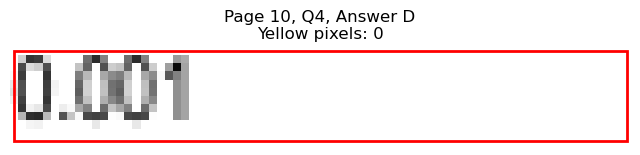


Page 10, Q4 - Selected Answer: C (based on yellow pixel count)




Page 10, Q5 - A: Detected box: x0=68.3, y0=419.4, x1=109.4, y1=430.4
Page 10, Q5, A: Yellow pixels: 831
Page 10, Q5, A: Total non-white pixels: 1104
Page 10, Q5, A: Yellow percentage: 75.3%


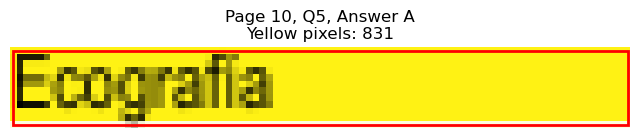

Page 10, Q5 - B: Detected box: x0=68.3, y0=432.0, x1=100.4, y1=443.0
Page 10, Q5, B: Yellow pixels: 0
Page 10, Q5, B: Total non-white pixels: 182
Page 10, Q5, B: Yellow percentage: 0.0%


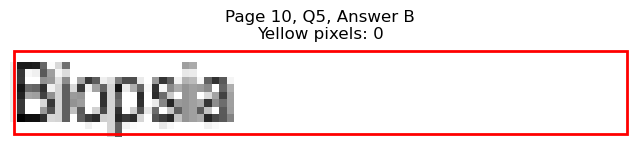

Page 10, Q5 - C: Detected box: x0=327.5, y0=419.4, x1=376.1, y1=430.4
Page 10, Q5, C: Yellow pixels: 0
Page 10, Q5, C: Total non-white pixels: 245
Page 10, Q5, C: Yellow percentage: 0.0%


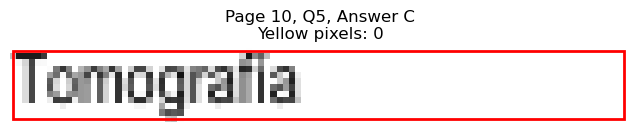

Page 10, Q5 - D: Detected box: x0=327.5, y0=432.0, x1=385.2, y1=443.0
Page 10, Q5, D: Yellow pixels: 0
Page 10, Q5, D: Total non-white pixels: 293
Page 10, Q5, D: Yellow percentage: 0.0%


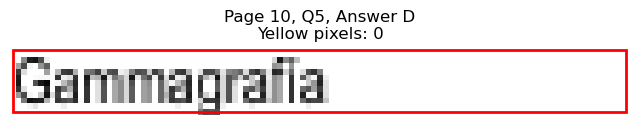


Page 10, Q5 - Selected Answer: A (based on yellow pixel count)




Page 10, Q6 - A: Detected box: x0=56.6, y0=520.3, x1=65.2, y1=531.3
Page 10, Q6, A: Yellow pixels: 0
Page 10, Q6, A: Total non-white pixels: 60
Page 10, Q6, A: Yellow percentage: 0.0%


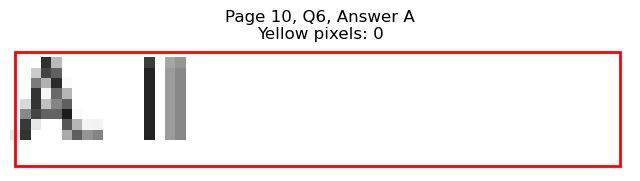

Page 10, Q6 - B: Detected box: x0=68.3, y0=532.9, x1=78.4, y1=543.9
Page 10, Q6, B: Yellow pixels: 0
Page 10, Q6, B: Total non-white pixels: 32
Page 10, Q6, B: Yellow percentage: 0.0%


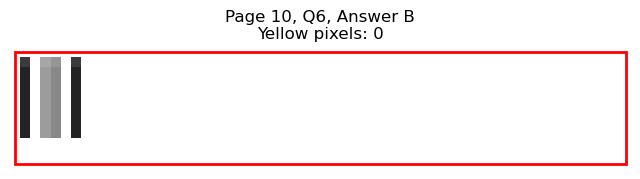

Page 10, Q6 - C: Detected box: x0=315.4, y0=520.3, x1=324.4, y1=531.3
Page 10, Q6, C: Yellow pixels: 619
Page 10, Q6, C: Total non-white pixels: 720
Page 10, Q6, C: Yellow percentage: 86.0%


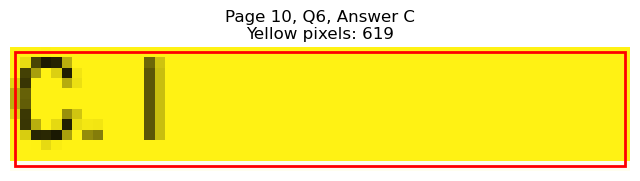

Page 10, Q6 - D: Detected box: x0=327.5, y0=532.9, x1=338.5, y1=543.9
Page 10, Q6, D: Yellow pixels: 0
Page 10, Q6, D: Total non-white pixels: 43
Page 10, Q6, D: Yellow percentage: 0.0%


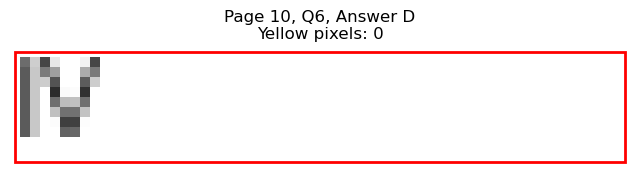


Page 10, Q6 - Selected Answer: C (based on yellow pixel count)




Page 10, Q7 - A: Detected box: x0=68.3, y0=608.6, x1=141.0, y1=619.6
Page 10, Q7, A: Yellow pixels: 1200
Page 10, Q7, A: Total non-white pixels: 1476
Page 10, Q7, A: Yellow percentage: 81.3%


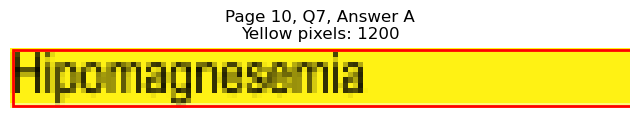

Page 10, Q7 - B: Detected box: x0=68.3, y0=621.3, x1=124.4, y1=632.4
Page 10, Q7, B: Yellow pixels: 0
Page 10, Q7, B: Total non-white pixels: 303
Page 10, Q7, B: Yellow percentage: 0.0%


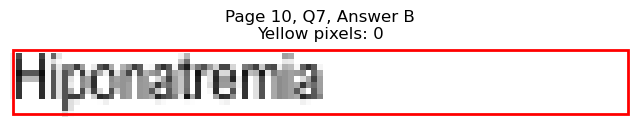

Page 10, Q7 - C: Detected box: x0=327.5, y0=608.6, x1=390.1, y1=619.6
Page 10, Q7, C: Yellow pixels: 0
Page 10, Q7, C: Total non-white pixels: 355
Page 10, Q7, C: Yellow percentage: 0.0%


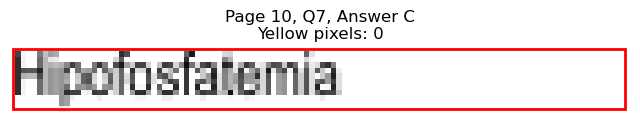

Page 10, Q7 - D: Detected box: x0=327.5, y0=621.3, x1=384.1, y1=632.4
Page 10, Q7, D: Yellow pixels: 0
Page 10, Q7, D: Total non-white pixels: 311
Page 10, Q7, D: Yellow percentage: 0.0%


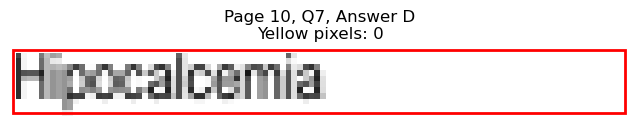


Page 10, Q7 - Selected Answer: A (based on yellow pixel count)




Page 10, Q8 - A: Detected box: x0=68.3, y0=659.1, x1=259.9, y1=670.2
Page 10, Q8, A: Yellow pixels: 213
Page 10, Q8, A: Total non-white pixels: 1366
Page 10, Q8, A: Yellow percentage: 15.6%


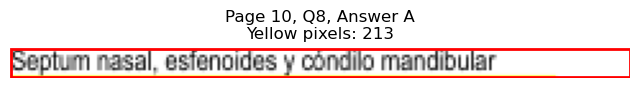

Page 10, Q8 - B: Detected box: x0=68.3, y0=671.7, x1=231.2, y1=682.8
Page 10, Q8, B: Yellow pixels: 1976
Page 10, Q8, B: Total non-white pixels: 2568
Page 10, Q8, B: Yellow percentage: 76.9%


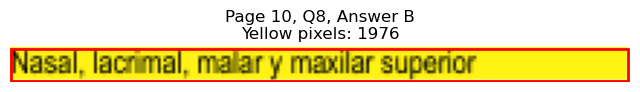

Page 10, Q8 - C: Detected box: x0=327.5, y0=659.1, x1=491.9, y1=670.2
Page 10, Q8, C: Yellow pixels: 0
Page 10, Q8, C: Total non-white pixels: 800
Page 10, Q8, C: Yellow percentage: 0.0%


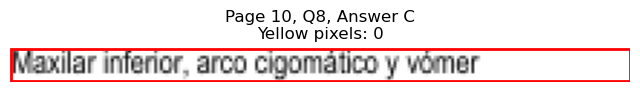

Page 10, Q8 - D: Detected box: x0=327.5, y0=671.7, x1=513.0, y1=682.8
Page 10, Q8, D: Yellow pixels: 0
Page 10, Q8, D: Total non-white pixels: 901
Page 10, Q8, D: Yellow percentage: 0.0%


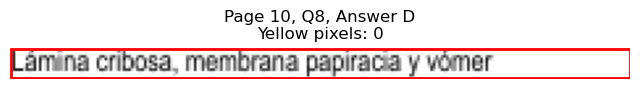


Page 10, Q8 - Selected Answer: B (based on yellow pixel count)




Page 10, Q9 - A: Detected box: x0=68.3, y0=734.8, x1=134.5, y1=745.9
Page 10, Q9, A: Yellow pixels: 1
Page 10, Q9, A: Total non-white pixels: 453
Page 10, Q9, A: Yellow percentage: 0.2%


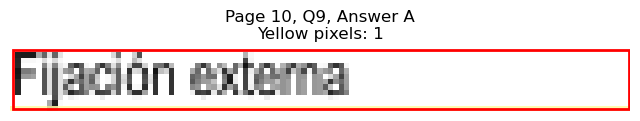

Page 10, Q9 - B: Detected box: x0=68.3, y0=747.4, x1=162.1, y1=758.5
Page 10, Q9, B: Yellow pixels: 1207
Page 10, Q9, B: Total non-white pixels: 1740
Page 10, Q9, B: Yellow percentage: 69.4%


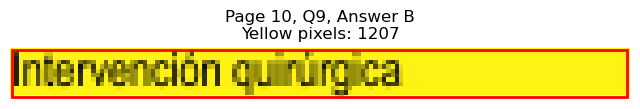

Page 10, Q9 - C: Detected box: x0=327.5, y0=734.8, x1=451.9, y1=745.9
Page 10, Q9, C: Yellow pixels: 0
Page 10, Q9, C: Total non-white pixels: 596
Page 10, Q9, C: Yellow percentage: 0.0%


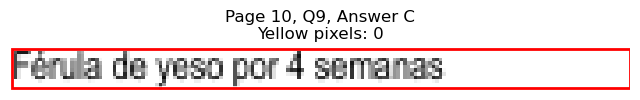

Page 10, Q9 - D: Detected box: x0=327.5, y0=747.4, x1=465.4, y1=758.5
Page 10, Q9, D: Yellow pixels: 0
Page 10, Q9, D: Total non-white pixels: 707
Page 10, Q9, D: Yellow percentage: 0.0%


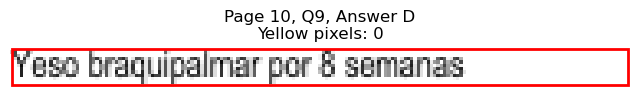


Page 10, Q9 - Selected Answer: B (based on yellow pixel count)





Page 11: Found 9 questions
Page 11, Q1 - A: Detected box: x0=68.3, y0=116.4, x1=162.6, y1=127.4
Page 11, Q1, A: Yellow pixels: 0
Page 11, Q1, A: Total non-white pixels: 480
Page 11, Q1, A: Yellow percentage: 0.0%


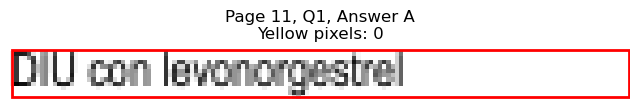

Page 11, Q1 - B: Detected box: x0=68.3, y0=129.0, x1=156.0, y1=140.0
Page 11, Q1, B: Yellow pixels: 0
Page 11, Q1, B: Total non-white pixels: 469
Page 11, Q1, B: Yellow percentage: 0.0%


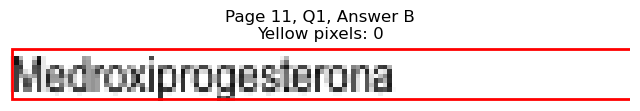

Page 11, Q1 - C: Detected box: x0=327.5, y0=116.4, x1=439.3, y1=127.4
Page 11, Q1, C: Yellow pixels: 163
Page 11, Q1, C: Total non-white pixels: 729
Page 11, Q1, C: Yellow percentage: 22.4%


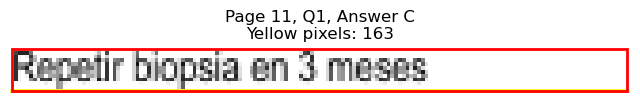

Page 11, Q1 - D: Detected box: x0=327.5, y0=129.0, x1=405.2, y1=140.0
Page 11, Q1, D: Yellow pixels: 1221
Page 11, Q1, D: Total non-white pixels: 1548
Page 11, Q1, D: Yellow percentage: 78.9%


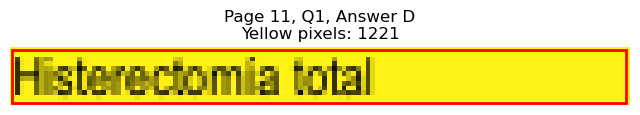


Page 11, Q1 - Selected Answer: D (based on yellow pixel count)




Page 11, Q2 - A: Detected box: x0=68.3, y0=192.1, x1=228.8, y1=203.1
Page 11, Q2, A: Yellow pixels: 211
Page 11, Q2, A: Total non-white pixels: 1246
Page 11, Q2, A: Yellow percentage: 16.9%


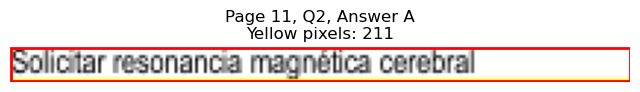

Page 11, Q2 - B: Detected box: x0=68.3, y0=204.7, x1=254.3, y1=215.7
Page 11, Q2, B: Yellow pixels: 1838
Page 11, Q2, B: Total non-white pixels: 2568
Page 11, Q2, B: Yellow percentage: 71.6%


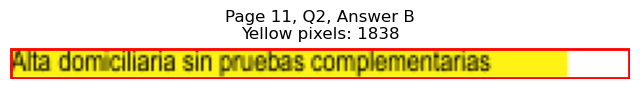

Page 11, Q2 - C: Detected box: x0=327.5, y0=192.1, x1=536.6, y1=203.1
Page 11, Q2, C: Yellow pixels: 0
Page 11, Q2, C: Total non-white pixels: 1041
Page 11, Q2, C: Yellow percentage: 0.0%


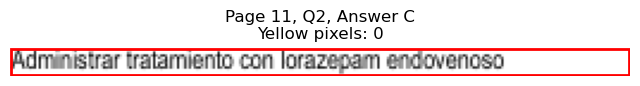

Page 11, Q2 - D: Detected box: x0=327.5, y0=204.7, x1=427.3, y1=215.7
Page 11, Q2, D: Yellow pixels: 0
Page 11, Q2, D: Total non-white pixels: 520
Page 11, Q2, D: Yellow percentage: 0.0%


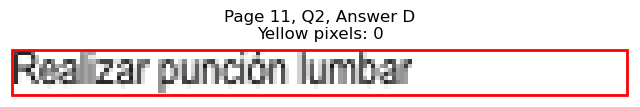


Page 11, Q2 - Selected Answer: B (based on yellow pixel count)




Page 11, Q3 - A: Detected box: x0=68.3, y0=255.2, x1=118.4, y1=266.2
Page 11, Q3, A: Yellow pixels: 101
Page 11, Q3, A: Total non-white pixels: 351
Page 11, Q3, A: Yellow percentage: 28.8%


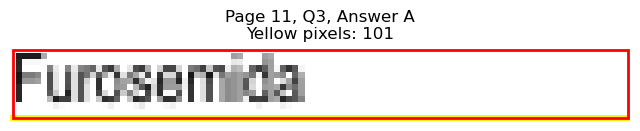

Page 11, Q3 - B: Detected box: x0=68.3, y0=267.8, x1=125.5, y1=278.8
Page 11, Q3, B: Yellow pixels: 1038
Page 11, Q3, B: Total non-white pixels: 1296
Page 11, Q3, B: Yellow percentage: 80.1%


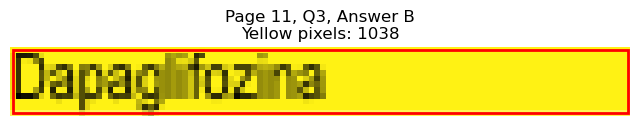

Page 11, Q3 - C: Detected box: x0=327.5, y0=255.2, x1=375.6, y1=266.2
Page 11, Q3, C: Yellow pixels: 0
Page 11, Q3, C: Total non-white pixels: 239
Page 11, Q3, C: Yellow percentage: 0.0%


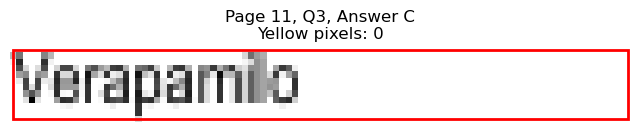

Page 11, Q3 - D: Detected box: x0=327.5, y0=267.8, x1=362.6, y1=278.8
Page 11, Q3, D: Yellow pixels: 0
Page 11, Q3, D: Total non-white pixels: 185
Page 11, Q3, D: Yellow percentage: 0.0%


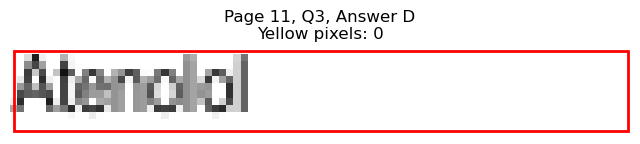


Page 11, Q3 - Selected Answer: B (based on yellow pixel count)




Page 11, Q4 - A: Detected box: x0=68.3, y0=305.7, x1=105.4, y1=316.8
Page 11, Q4, A: Yellow pixels: 0
Page 11, Q4, A: Total non-white pixels: 176
Page 11, Q4, A: Yellow percentage: 0.0%


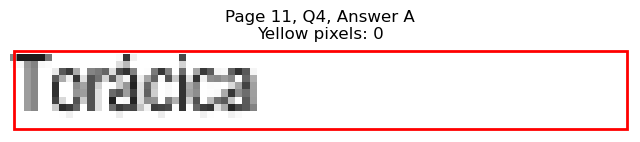

Page 11, Q4 - B: Detected box: x0=68.3, y0=318.3, x1=102.4, y1=329.4
Page 11, Q4, B: Yellow pixels: 0
Page 11, Q4, B: Total non-white pixels: 174
Page 11, Q4, B: Yellow percentage: 0.0%


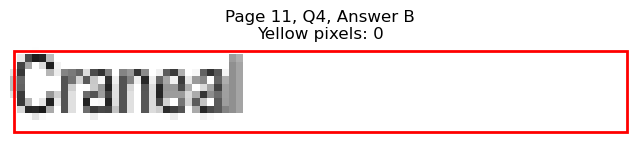

Page 11, Q4 - C: Detected box: x0=327.5, y0=305.7, x1=362.5, y1=316.8
Page 11, Q4, C: Yellow pixels: 895
Page 11, Q4, C: Total non-white pixels: 1032
Page 11, Q4, C: Yellow percentage: 86.7%


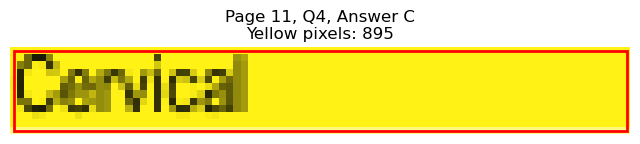

Page 11, Q4 - D: Detected box: x0=327.5, y0=318.3, x1=358.6, y1=329.4
Page 11, Q4, D: Yellow pixels: 0
Page 11, Q4, D: Total non-white pixels: 166
Page 11, Q4, D: Yellow percentage: 0.0%


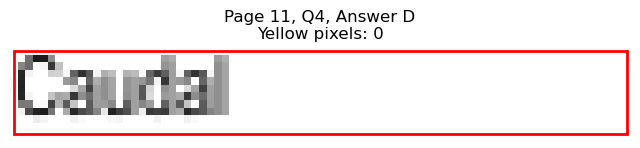


Page 11, Q4 - Selected Answer: C (based on yellow pixel count)




Page 11, Q5 - A: Detected box: x0=68.3, y0=381.4, x1=119.4, y1=392.5
Page 11, Q5, A: Yellow pixels: 0
Page 11, Q5, A: Total non-white pixels: 269
Page 11, Q5, A: Yellow percentage: 0.0%


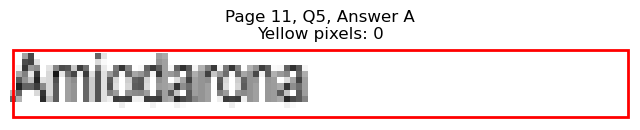

Page 11, Q5 - B: Detected box: x0=68.3, y0=394.0, x1=167.6, y1=405.1
Page 11, Q5, B: Yellow pixels: 0
Page 11, Q5, B: Total non-white pixels: 487
Page 11, Q5, B: Yellow percentage: 0.0%


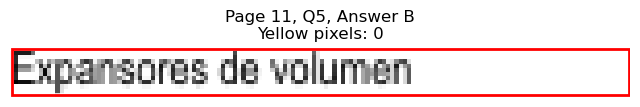

Page 11, Q5 - C: Detected box: x0=327.5, y0=381.4, x1=363.6, y1=392.5
Page 11, Q5, C: Yellow pixels: 87
Page 11, Q5, C: Total non-white pixels: 277
Page 11, Q5, C: Yellow percentage: 31.4%


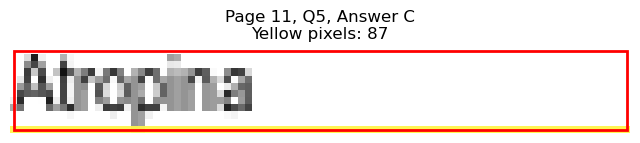

Page 11, Q5 - D: Detected box: x0=327.5, y0=394.0, x1=373.1, y1=405.1
Page 11, Q5, D: Yellow pixels: 911
Page 11, Q5, D: Total non-white pixels: 1067
Page 11, Q5, D: Yellow percentage: 85.4%


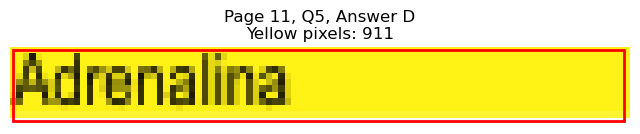


Page 11, Q5 - Selected Answer: D (based on yellow pixel count)




Page 11, Q6 - A: Detected box: x0=68.3, y0=457.2, x1=158.0, y1=468.2
Page 11, Q6, A: Yellow pixels: 1224
Page 11, Q6, A: Total non-white pixels: 1553
Page 11, Q6, A: Yellow percentage: 78.8%


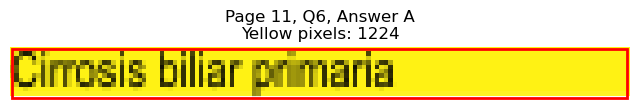

Page 11, Q6 - B: Detected box: x0=68.3, y0=469.8, x1=155.5, y1=480.8
Page 11, Q6, B: Yellow pixels: 0
Page 11, Q6, B: Total non-white pixels: 456
Page 11, Q6, B: Yellow percentage: 0.0%


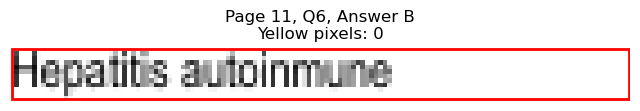

Page 11, Q6 - C: Detected box: x0=327.5, y0=457.2, x1=433.8, y1=468.2
Page 11, Q6, C: Yellow pixels: 0
Page 11, Q6, C: Total non-white pixels: 578
Page 11, Q6, C: Yellow percentage: 0.0%


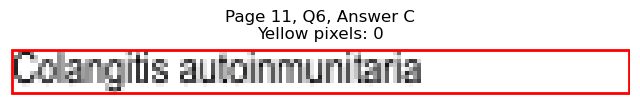

Page 11, Q6 - D: Detected box: x0=327.5, y0=469.8, x1=458.4, y1=480.8
Page 11, Q6, D: Yellow pixels: 0
Page 11, Q6, D: Total non-white pixels: 680
Page 11, Q6, D: Yellow percentage: 0.0%


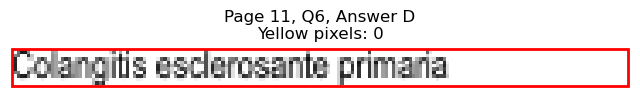


Page 11, Q6 - Selected Answer: A (based on yellow pixel count)




Page 11, Q7 - A: Detected box: x0=68.3, y0=520.3, x1=113.9, y1=531.3
Page 11, Q7, A: Yellow pixels: 0
Page 11, Q7, A: Total non-white pixels: 224
Page 11, Q7, A: Yellow percentage: 0.0%


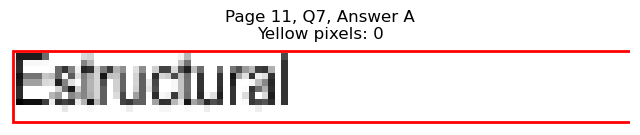

Page 11, Q7 - B: Detected box: x0=68.3, y0=532.9, x1=106.9, y1=543.9
Page 11, Q7, B: Yellow pixels: 0
Page 11, Q7, B: Total non-white pixels: 195
Page 11, Q7, B: Yellow percentage: 0.0%


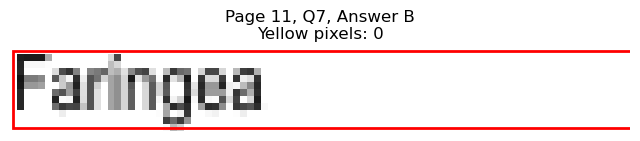

Page 11, Q7 - C: Detected box: x0=327.5, y0=520.3, x1=352.6, y1=531.3
Page 11, Q7, C: Yellow pixels: 739
Page 11, Q7, C: Total non-white pixels: 912
Page 11, Q7, C: Yellow percentage: 81.0%


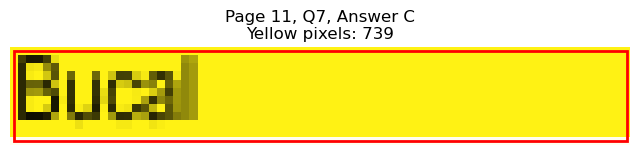

Page 11, Q7 - D: Detected box: x0=327.5, y0=532.9, x1=369.6, y1=543.9
Page 11, Q7, D: Yellow pixels: 0
Page 11, Q7, D: Total non-white pixels: 235
Page 11, Q7, D: Yellow percentage: 0.0%


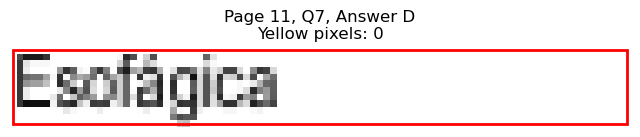


Page 11, Q7 - Selected Answer: C (based on yellow pixel count)




Page 11, Q8 - A: Detected box: x0=68.3, y0=381.4, x1=119.4, y1=392.5
Page 11, Q8, A: Yellow pixels: 0
Page 11, Q8, A: Total non-white pixels: 269
Page 11, Q8, A: Yellow percentage: 0.0%


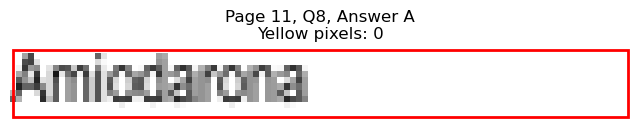

Page 11, Q8 - B: Detected box: x0=68.3, y0=621.3, x1=118.4, y1=632.4
Page 11, Q8, B: Yellow pixels: 918
Page 11, Q8, B: Total non-white pixels: 1212
Page 11, Q8, B: Yellow percentage: 75.7%


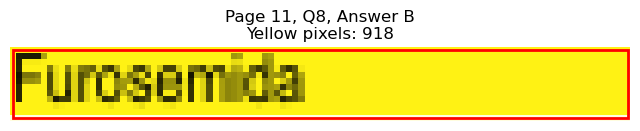

Page 11, Q8 - C: Detected box: x0=327.5, y0=608.6, x1=394.7, y1=619.6
Page 11, Q8, C: Yellow pixels: 0
Page 11, Q8, C: Total non-white pixels: 361
Page 11, Q8, C: Yellow percentage: 0.0%


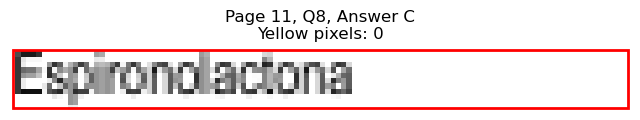

Page 11, Q8 - D: Detected box: x0=327.5, y0=621.3, x1=366.6, y1=632.4
Page 11, Q8, D: Yellow pixels: 0
Page 11, Q8, D: Total non-white pixels: 196
Page 11, Q8, D: Yellow percentage: 0.0%


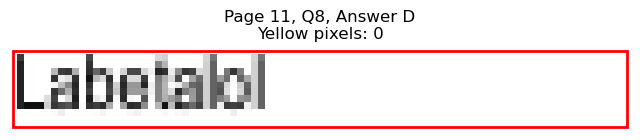


Page 11, Q8 - Selected Answer: B (based on yellow pixel count)




Page 11, Q9 - A: Detected box: x0=68.3, y0=684.3, x1=255.4, y1=695.4
Page 11, Q9, A: Yellow pixels: 213
Page 11, Q9, A: Total non-white pixels: 1147
Page 11, Q9, A: Yellow percentage: 18.6%


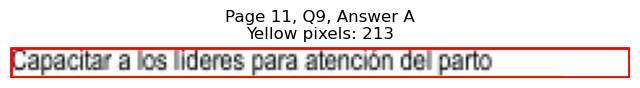

Page 11, Q9 - B: Detected box: x0=68.3, y0=697.0, x1=224.3, y1=708.1
Page 11, Q9, B: Yellow pixels: 1678
Page 11, Q9, B: Total non-white pixels: 2284
Page 11, Q9, B: Yellow percentage: 73.5%


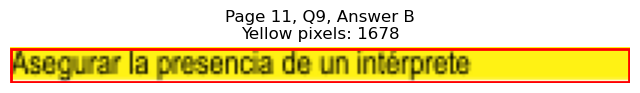

Page 11, Q9 - C: Detected box: x0=327.5, y0=684.3, x1=504.6, y1=695.4
Page 11, Q9, C: Yellow pixels: 0
Page 11, Q9, C: Total non-white pixels: 920
Page 11, Q9, C: Yellow percentage: 0.0%


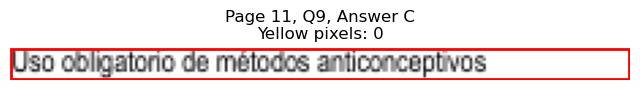

Page 11, Q9 - D: Detected box: x0=327.5, y0=697.0, x1=496.4, y1=708.1
Page 11, Q9, D: Yellow pixels: 0
Page 11, Q9, D: Total non-white pixels: 823
Page 11, Q9, D: Yellow percentage: 0.0%


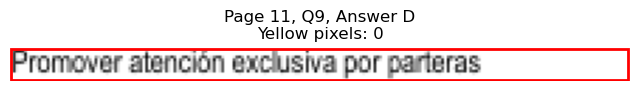


Page 11, Q9 - Selected Answer: B (based on yellow pixel count)





Page 12: Found 3 questions
Page 12, Q1 - A: Detected box: x0=56.6, y0=116.4, x1=65.2, y1=127.4
Page 12, Q1, A: Yellow pixels: 606
Page 12, Q1, A: Total non-white pixels: 720
Page 12, Q1, A: Yellow percentage: 84.2%


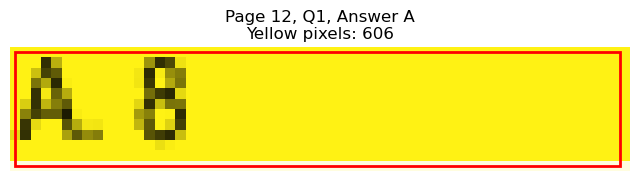

Page 12, Q1 - B: Detected box: x0=56.6, y0=129.0, x1=65.2, y1=140.0
Page 12, Q1, B: Yellow pixels: 0
Page 12, Q1, B: Total non-white pixels: 75
Page 12, Q1, B: Yellow percentage: 0.0%


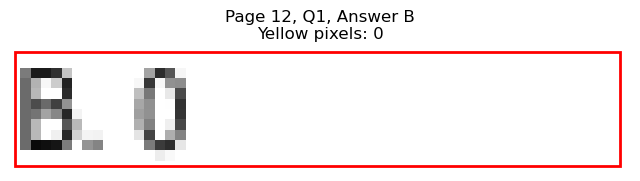

Page 12, Q1 - C: Detected box: x0=315.4, y0=116.4, x1=324.4, y1=127.4
Page 12, Q1, C: Yellow pixels: 0
Page 12, Q1, C: Total non-white pixels: 60
Page 12, Q1, C: Yellow percentage: 0.0%


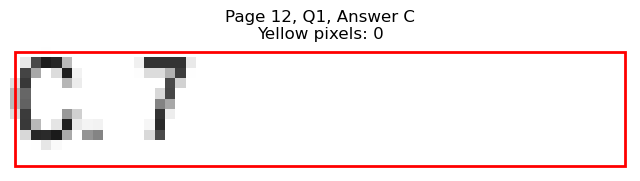

Page 12, Q1 - D: Detected box: x0=315.4, y0=129.0, x1=324.4, y1=140.0
Page 12, Q1, D: Yellow pixels: 0
Page 12, Q1, D: Total non-white pixels: 55
Page 12, Q1, D: Yellow percentage: 0.0%


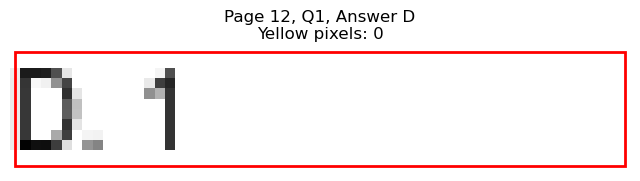


Page 12, Q1 - Selected Answer: A (based on yellow pixel count)




Page 12, Q2 - A: Detected box: x0=68.3, y0=179.5, x1=170.6, y1=190.5
Page 12, Q2, A: Yellow pixels: 0
Page 12, Q2, A: Total non-white pixels: 531
Page 12, Q2, A: Yellow percentage: 0.0%


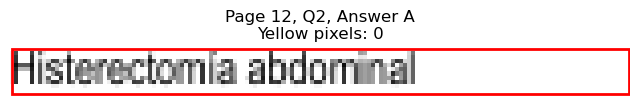

Page 12, Q2 - B: Detected box: x0=68.3, y0=192.1, x1=126.0, y1=203.1
Page 12, Q2, B: Yellow pixels: 0
Page 12, Q2, B: Total non-white pixels: 309
Page 12, Q2, B: Yellow percentage: 0.0%


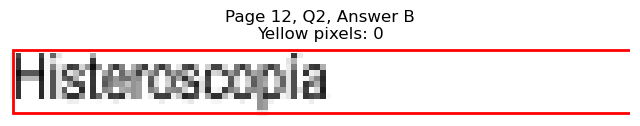

Page 12, Q2 - C: Detected box: x0=327.5, y0=179.5, x1=393.2, y1=190.5
Page 12, Q2, C: Yellow pixels: 117
Page 12, Q2, C: Total non-white pixels: 423
Page 12, Q2, C: Yellow percentage: 27.7%


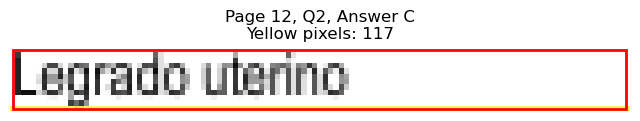

Page 12, Q2 - D: Detected box: x0=327.5, y0=192.1, x1=380.6, y1=203.1
Page 12, Q2, D: Yellow pixels: 949
Page 12, Q2, D: Total non-white pixels: 1144
Page 12, Q2, D: Yellow percentage: 83.0%


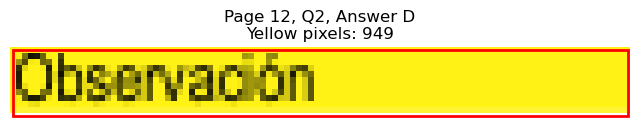


Page 12, Q2 - Selected Answer: D (based on yellow pixel count)




Page 12, Q3 - A: Detected box: x0=68.3, y0=267.8, x1=122.4, y1=278.8
Page 12, Q3, A: Yellow pixels: 1054
Page 12, Q3, A: Total non-white pixels: 1260
Page 12, Q3, A: Yellow percentage: 83.7%


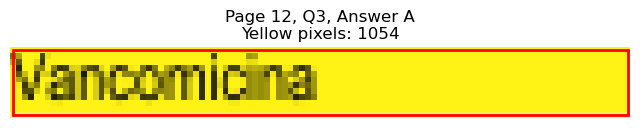

Page 12, Q3 - B: Detected box: x0=68.3, y0=280.5, x1=123.0, y1=291.6
Page 12, Q3, B: Yellow pixels: 0
Page 12, Q3, B: Total non-white pixels: 252
Page 12, Q3, B: Yellow percentage: 0.0%


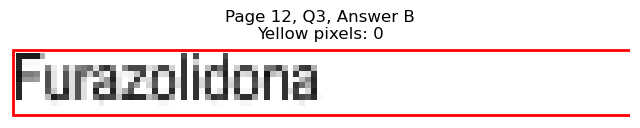

Page 12, Q3 - C: Detected box: x0=327.5, y0=267.8, x1=376.7, y1=278.8
Page 12, Q3, C: Yellow pixels: 0
Page 12, Q3, C: Total non-white pixels: 252
Page 12, Q3, C: Yellow percentage: 0.0%


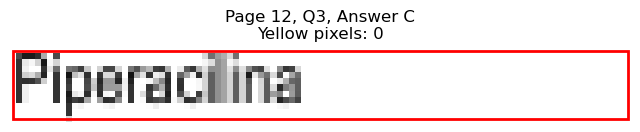

Page 12, Q3 - D: Detected box: x0=327.5, y0=280.5, x1=385.2, y1=291.6
Page 12, Q3, D: Yellow pixels: 0
Page 12, Q3, D: Total non-white pixels: 279
Page 12, Q3, D: Yellow percentage: 0.0%


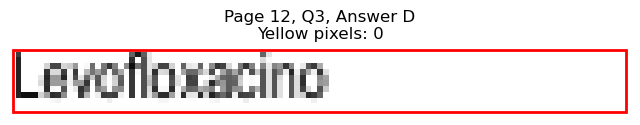


Page 12, Q3 - Selected Answer: A (based on yellow pixel count)






In [6]:
questions_df = extract_questions(pdf_path = pdf_file)
answers_df = extract_answers(pdf_path = pdf_file)
correct_answers_df = extract_correct_answers(pdf_path = pdf_file)

In [7]:
questions_df

question
0   Varón de 21 años, es trasladado por haber sufr...
1   RN producto de parto eutócico, EG 38 semanas, ...
2   Mujer de 48 años en diálisis peritoneal desde ...
3   Varón de 35 años, fumador desde los 14 años, p...
4   Mujer de 75 años, acude por sensación de bulto...
..                                                ...
95  Varón de 59 años, hipertenso, fibrilador y con...
96  El médico SERUM de un C.S. I-2 de una comunida...
97  Mujer de 33 años, acude por hipermenorrea desd...
98  Mujer de 55 años, acude porque hace un mes pre...
99  Varón de 48 años, tratado por absceso glúteo c...

[100 rows x 1 columns]

In [8]:
answers_df

option_A  \
0                                  Vena cava superior   
1                                             Crouzon   
2                           Gentamicina + vancomicina   
3   Engrosamiento de la íntima con placas ateromat...   
4                                                  IV   
..                                                ...   
95                                         Amiodarona   
96    Capacitar a los líderes para atención del parto   
97                                                  8   
98                            Histerectomía abdominal   
99                                        Vancomicina   

                                             option_B  \
0                                           Diafragma   
1                                               Apert   
2                                         Vancomicina   
3   Vasos con inflamación, obstruidos por trombos ...   
4                                                   I   
..                                                ...   
95                                         Furosemida   
96             Asegurar la presencia de un intérprete   
97                                                  0   
98                                      Histeroscopía   
99                                       Furazolidona   

                                             option_C  \
0                              Árbol traqueobronquial   
1                                    Treacher Collins   
2                                         Ceftriaxona   
3   Células inflamatorias dispersas, con calcifica...   
4                                                  II   
..                                                ...   
95                                    Espironolactona   
96         Uso obligatorio de métodos anticonceptivos   
97                                                  7   
98                                    Legrado uterino   
99                                       Piperacilina   

                                             option_D  
0                            Arteria torácica interna  
1                                                Down  
2                           Ceftriaxona + gentamicina  
3   Vasos con densos cúmulos de células atípicas q...  
4                                                 III  
..                                                ...  
95                                          Labetalol  
96           Promover atención exclusiva por parteras  
97                                                  1  
98                                        Observación  
99                                      Levofloxacino  

[100 rows x 4 columns]

In [9]:
correct_answers_df

correct_answer
0               C
1               D
2               A
3               B
4               C
..            ...
95              B
96              B
97              A
98              D
99              A

[100 rows x 1 columns]

In [10]:
total_df = pd.concat([questions_df, answers_df, correct_answers_df], ignore_index = True, axis = 1)
total_df.columns = ["questions", "option_A", "option_B", "option_C", "option_D", "correct_answer"]
total_df

questions  \
0   Varón de 21 años, es trasladado por haber sufr...   
1   RN producto de parto eutócico, EG 38 semanas, ...   
2   Mujer de 48 años en diálisis peritoneal desde ...   
3   Varón de 35 años, fumador desde los 14 años, p...   
4   Mujer de 75 años, acude por sensación de bulto...   
..                                                ...   
95  Varón de 59 años, hipertenso, fibrilador y con...   
96  El médico SERUM de un C.S. I-2 de una comunida...   
97  Mujer de 33 años, acude por hipermenorrea desd...   
98  Mujer de 55 años, acude porque hace un mes pre...   
99  Varón de 48 años, tratado por absceso glúteo c...   

                                             option_A  \
0                                  Vena cava superior   
1                                             Crouzon   
2                           Gentamicina + vancomicina   
3   Engrosamiento de la íntima con placas ateromat...   
4                                                  IV   
..                                                ...   
95                                         Amiodarona   
96    Capacitar a los líderes para atención del parto   
97                                                  8   
98                            Histerectomía abdominal   
99                                        Vancomicina   

                                             option_B  \
0                                           Diafragma   
1                                               Apert   
2                                         Vancomicina   
3   Vasos con inflamación, obstruidos por trombos ...   
4                                                   I   
..                                                ...   
95                                         Furosemida   
96             Asegurar la presencia de un intérprete   
97                                                  0   
98                                      Histeroscopía   
99                                       Furazolidona   

                                             option_C  \
0                              Árbol traqueobronquial   
1                                    Treacher Collins   
2                                         Ceftriaxona   
3   Células inflamatorias dispersas, con calcifica...   
4                                                  II   
..                                                ...   
95                                    Espironolactona   
96         Uso obligatorio de métodos anticonceptivos   
97                                                  7   
98                                    Legrado uterino   
99                                       Piperacilina   

                                             option_D correct_answer  
0                            Arteria torácica interna              C  
1                                                Down              D  
2                           Ceftriaxona + gentamicina              A  
3   Vasos con densos cúmulos de células atípicas q...              B  
4                                                 III              C  
..                                                ...            ...  
95                                          Labetalol              B  
96           Promover atención exclusiva por parteras              B  
97                                                  1              A  
98                                        Observación              D  
99                                      Levofloxacino              A  

[100 rows x 6 columns]

In [11]:
# Extract folder path
folder_path = os.path.dirname(pdf_file)  # Gets the directory path

# Extract filename without extension
file_name = os.path.splitext(os.path.basename(pdf_file))[0]  # Removes the .pdf extension

# Create CSV file path
csv_file = os.path.join(folder_path, f"{file_name}.csv")

# Save a sample DataFrame
total_df.to_csv(csv_file, index=False, encoding="utf-8-sig")
print(f"CSV saved at: {csv_file}")


CSV saved at: /Users/rodrigocarrillo/Documents/Natural Language Processing Projects/Examen Residentado Peru/CONAREME/Year2025/ESPECIALIADAD B.csv
